In [19]:
from tensorflow.keras import datasets

(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [20]:
import torch
from torch.utils.data import DataLoader

train_images = torch.tensor(train_images / 255, dtype=torch.float32)
test_images = torch.tensor(test_images / 255, dtype=torch.float32)

train_images = train_images.unsqueeze(1)
test_images = test_images.unsqueeze(1)

train_loader = DataLoader(train_images, batch_size=9192, shuffle=True)
test_loader = DataLoader(test_images, batch_size=9192, shuffle=False)

In [21]:
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 5, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.linear1 = nn.Linear(64 * 3 * 3, latent_dim)
        self.linear2 = nn.Linear(64 * 3 * 3, latent_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        mu = self.linear1(x)
        logvar = self.linear2(x)
        return mu, logvar

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.linear = nn.Linear(latent_dim, 64 * 3 * 3)
        self.deconv1 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(32, 16, 5, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(16, 1, 5, stride=2, padding=1, output_padding=1)

    def forward(self, z):
        x = self.linear(z)
        x = x.view(-1, 64, 3, 3)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = torch.sigmoid(self.deconv3(x))
        return x

In [23]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)
        self.latent_dim = latent_dim

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar

In [24]:
vae = VAE(latent_dim=16).to('cuda')

In [25]:
class VAELoss(nn.Module):
    def __init__(self):
        super(VAELoss, self).__init__()

    def forward(self, x_hat, x, mu, logvar):
        recon_loss = F.binary_cross_entropy(x_hat, x, reduction='sum')
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return recon_loss + kl_loss, recon_loss, kl_loss

In [26]:
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

def train(model, train_loader, epochs, lr, device):
    writer = SummaryWriter()
    model.to(device)
    criterion = VAELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=0.00001)
    prev_lr = lr
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        recon_loss = 0.0
        kl_loss = 0.0
        train_bar = tqdm(train_loader, desc="Training", leave=False)
        for batch_idx, data in enumerate(train_bar):
            data = data.to(device)
            optimizer.zero_grad()
            x_hat, mu, logvar = model(data)
            loss, recon, kl = criterion(x_hat, data, mu, logvar)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            recon_loss += recon.item()
            kl_loss += kl.item()
            train_bar.set_postfix(loss=running_loss / (batch_idx + 1), recon=recon.item(), kl=kl.item())
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {running_loss / len(train_loader)}, Recon Loss: {recon_loss / len(train_loader)}, KL Loss: {kl_loss / len(train_loader)}")
        writer.add_scalar("Loss/Train", running_loss / len(train_loader), epoch)
        writer.add_scalar("Loss/TrainRecon", recon, epoch)
        writer.add_scalar("Loss/TrainKL", kl, epoch)

        model.eval()
        running_loss = 0.0
        recon_loss = 0.0
        kl_loss = 0.0
        val_bar = tqdm(test_loader, desc="Validation", leave=False)
        for batch_idx, data in enumerate(val_bar):
            data = data.to(device)
            x_hat, mu, logvar = model(data)
            loss, recon, kl = criterion(x_hat, data, mu, logvar)
            running_loss += loss.item()
            recon_loss += recon.item()
            kl_loss += kl.item()
            val_bar.set_postfix(loss=running_loss / (batch_idx + 1), recon=recon.item(), kl=kl.item())
        print(f"Epoch {epoch + 1}/{epochs}, Val Loss: {running_loss / len(test_loader)}, Recon Loss: {recon_loss / len(test_loader)}, KL Loss: {kl_loss / len(test_loader)}")
        writer.add_scalar("Loss/Val", running_loss / len(test_loader), epoch)
        writer.add_scalar("Loss/ValRecon", recon, epoch)
        writer.add_scalar("Loss/ValKL", kl, epoch)
        scheduler.step(running_loss)
        if prev_lr != scheduler.optimizer.param_groups[0]['lr']:
            prev_lr = scheduler.optimizer.param_groups[0]['lr']
            print(f"Learning rate changed to {prev_lr}")
            writer.add_scalar("Learning Rate", prev_lr, epoch)
    writer.close()

In [27]:
train(vae, train_loader, 1000, 0.01, "cuda")

Epoch 1/1000, Train Loss: 3887429.9821428573, Recon Loss: 3821336.9285714286, KL Loss: 66093.11510249546


Epoch 1/1000, Val Loss: 1865841.0625, Recon Loss: 1865367.09375, KL Loss: 473.9703369140625


Epoch 2/1000, Train Loss: 2779815.9821428573, Recon Loss: 2775735.785714286, KL Loss: 4080.185860770089


Epoch 2/1000, Val Loss: 1288884.828125, Recon Loss: 1277267.390625, KL Loss: 11617.44873046875


Epoch 3/1000, Train Loss: 2071077.9464285714, Recon Loss: 2022858.875, KL Loss: 48219.08342633928


Epoch 3/1000, Val Loss: 1153271.90625, Recon Loss: 1103758.1328125, KL Loss: 49513.720703125


Epoch 4/1000, Train Loss: 1942774.5, Recon Loss: 1861730.9107142857, KL Loss: 81043.55524553571


Epoch 4/1000, Val Loss: 1103166.0078125, Recon Loss: 1069724.4609375, KL Loss: 33441.52197265625


Epoch 5/1000, Train Loss: 1867755.3035714286, Recon Loss: 1832770.5535714286, KL Loss: 34984.75697544643


Epoch 5/1000, Val Loss: 1076761.5078125, Recon Loss: 1064033.46875, KL Loss: 12728.024047851562


Epoch 6/1000, Train Loss: 1836898.044642857, Recon Loss: 1817626.732142857, KL Loss: 19271.304827008928


Epoch 6/1000, Val Loss: 1060265.5234375, Recon Loss: 1043792.21875, KL Loss: 16473.314697265625


Epoch 7/1000, Train Loss: 1808171.6875, Recon Loss: 1781543.857142857, KL Loss: 26627.83565848214


Epoch 7/1000, Val Loss: 1044349.6171875, Recon Loss: 1025974.484375, KL Loss: 18375.12841796875


Epoch 8/1000, Train Loss: 1775281.375, Recon Loss: 1742213.1785714286, KL Loss: 33068.19391741072


Epoch 8/1000, Val Loss: 1021995.7578125, Recon Loss: 997829.15625, KL Loss: 24166.572265625


Epoch 9/1000, Train Loss: 1733024.4107142857, Recon Loss: 1694997.2857142857, KL Loss: 38027.12806919643


Epoch 9/1000, Val Loss: 994451.4140625, Recon Loss: 968786.359375, KL Loss: 25665.045654296875


Epoch 10/1000, Train Loss: 1676380.767857143, Recon Loss: 1627997.7767857143, KL Loss: 48382.98158482143


Epoch 10/1000, Val Loss: 961398.3828125, Recon Loss: 926306.90625, KL Loss: 35091.4912109375


Epoch 11/1000, Train Loss: 1623824.8035714286, Recon Loss: 1564540.0714285714, KL Loss: 59284.74665178572


Epoch 11/1000, Val Loss: 930162.0390625, Recon Loss: 892330.4609375, KL Loss: 37831.56494140625


Epoch 12/1000, Train Loss: 1574273.0714285714, Recon Loss: 1504924.2232142857, KL Loss: 69348.85491071429


Epoch 12/1000, Val Loss: 905132.5234375, Recon Loss: 867744.578125, KL Loss: 37387.927001953125


Epoch 13/1000, Train Loss: 1527588.6875, Recon Loss: 1452347.75, KL Loss: 75240.93247767857


Epoch 13/1000, Val Loss: 877908.71875, Recon Loss: 832936.7265625, KL Loss: 44972.0068359375


Epoch 14/1000, Train Loss: 1486698.125, Recon Loss: 1401453.3660714286, KL Loss: 85244.74386160714


Epoch 14/1000, Val Loss: 854558.65625, Recon Loss: 803357.06640625, KL Loss: 51201.6123046875


Epoch 15/1000, Train Loss: 1444263.7142857143, Recon Loss: 1352109.125, KL Loss: 92154.58705357143


Epoch 15/1000, Val Loss: 827199.546875, Recon Loss: 774312.6875, KL Loss: 52886.8466796875


Epoch 16/1000, Train Loss: 1401157.5535714286, Recon Loss: 1301734.6964285714, KL Loss: 99422.83816964286


Epoch 16/1000, Val Loss: 803341.6171875, Recon Loss: 743391.2109375, KL Loss: 59950.3759765625


Epoch 17/1000, Train Loss: 1349369.5982142857, Recon Loss: 1241270.5357142857, KL Loss: 108099.06361607143


Epoch 17/1000, Val Loss: 765545.48046875, Recon Loss: 702009.44921875, KL Loss: 63536.0576171875


Epoch 18/1000, Train Loss: 1299042.7232142857, Recon Loss: 1182886.7857142857, KL Loss: 116155.96205357143


Epoch 18/1000, Val Loss: 739727.2265625, Recon Loss: 666910.9453125, KL Loss: 72816.28125


Epoch 19/1000, Train Loss: 1287095.0625, Recon Loss: 1160669.25, KL Loss: 126425.82477678571


Epoch 19/1000, Val Loss: 740737.04296875, Recon Loss: 671800.33984375, KL Loss: 68936.72265625


Epoch 20/1000, Train Loss: 1251912.25, Recon Loss: 1121090.25, KL Loss: 130822.00558035714


Epoch 20/1000, Val Loss: 710832.52734375, Recon Loss: 630038.4296875, KL Loss: 80794.06640625


Epoch 21/1000, Train Loss: 1213830.1160714286, Recon Loss: 1077558.0625, KL Loss: 136272.06026785713


Epoch 21/1000, Val Loss: 694169.40234375, Recon Loss: 606532.375, KL Loss: 87637.0576171875


Epoch 22/1000, Train Loss: 1186225.955357143, Recon Loss: 1043811.9642857143, KL Loss: 142414.0044642857


Epoch 22/1000, Val Loss: 681115.57421875, Recon Loss: 594828.9375, KL Loss: 86286.63525390625


Epoch 23/1000, Train Loss: 1165213.2410714286, Recon Loss: 1018893.2678571428, KL Loss: 146320.0


Epoch 23/1000, Val Loss: 668584.58984375, Recon Loss: 580043.64453125, KL Loss: 88540.9453125


Epoch 24/1000, Train Loss: 1149257.7142857143, Recon Loss: 999281.9732142857, KL Loss: 149975.73325892858


Epoch 24/1000, Val Loss: 659019.625, Recon Loss: 568988.7265625, KL Loss: 90030.880859375


Epoch 25/1000, Train Loss: 1132705.580357143, Recon Loss: 978662.2946428572, KL Loss: 154043.2890625


Epoch 25/1000, Val Loss: 652863.7265625, Recon Loss: 560533.55078125, KL Loss: 92330.14453125


Epoch 26/1000, Train Loss: 1120073.4910714286, Recon Loss: 963927.5, KL Loss: 156145.99330357142


Epoch 26/1000, Val Loss: 645583.4140625, Recon Loss: 552142.3828125, KL Loss: 93441.060546875


Epoch 27/1000, Train Loss: 1106207.5, Recon Loss: 946399.9107142857, KL Loss: 159807.5982142857


Epoch 27/1000, Val Loss: 641426.171875, Recon Loss: 543461.26171875, KL Loss: 97964.91064453125


Epoch 28/1000, Train Loss: 1095713.1517857143, Recon Loss: 934747.2142857143, KL Loss: 160965.93526785713


Epoch 28/1000, Val Loss: 632508.09375, Recon Loss: 538225.9375, KL Loss: 94282.1796875


Epoch 29/1000, Train Loss: 1081391.017857143, Recon Loss: 917599.8125, KL Loss: 163791.20982142858


Epoch 29/1000, Val Loss: 623804.4921875, Recon Loss: 527361.34375, KL Loss: 96443.119140625


Epoch 30/1000, Train Loss: 1075006.9107142857, Recon Loss: 910052.7767857143, KL Loss: 164954.13839285713


Epoch 30/1000, Val Loss: 624464.3515625, Recon Loss: 527639.63671875, KL Loss: 96824.712890625


Epoch 31/1000, Train Loss: 1083302.642857143, Recon Loss: 917353.5133928572, KL Loss: 165949.13392857142


Epoch 31/1000, Val Loss: 622209.4921875, Recon Loss: 523555.55078125, KL Loss: 98653.966796875


Epoch 32/1000, Train Loss: 1062782.6517857143, Recon Loss: 894750.1160714285, KL Loss: 168032.50669642858


Epoch 32/1000, Val Loss: 611410.984375, Recon Loss: 513764.34765625, KL Loss: 97646.65380859375


Epoch 33/1000, Train Loss: 1054859.732142857, Recon Loss: 886431.8571428572, KL Loss: 168427.8705357143


Epoch 33/1000, Val Loss: 609071.359375, Recon Loss: 509859.11328125, KL Loss: 99212.267578125


Epoch 34/1000, Train Loss: 1047048.8392857143, Recon Loss: 875981.7767857143, KL Loss: 171067.0703125


Epoch 34/1000, Val Loss: 603211.62890625, Recon Loss: 503917.23828125, KL Loss: 99294.359375


Epoch 35/1000, Train Loss: 1037342.0, Recon Loss: 865103.5625, KL Loss: 172238.43526785713


Epoch 35/1000, Val Loss: 599055.53515625, Recon Loss: 499482.65234375, KL Loss: 99572.8974609375


Epoch 36/1000, Train Loss: 1031074.3035714285, Recon Loss: 857302.1919642857, KL Loss: 173772.10044642858


Epoch 36/1000, Val Loss: 595199.2265625, Recon Loss: 494371.8046875, KL Loss: 100827.423828125


Epoch 37/1000, Train Loss: 1030681.1428571428, Recon Loss: 855941.3125, KL Loss: 174739.8482142857


Epoch 37/1000, Val Loss: 598667.94921875, Recon Loss: 494270.25390625, KL Loss: 104397.6640625


Epoch 38/1000, Train Loss: 1058201.0357142857, Recon Loss: 885523.0535714285, KL Loss: 172677.96875


Epoch 38/1000, Val Loss: 609632.6484375, Recon Loss: 506906.62109375, KL Loss: 102726.0498046875


Epoch 39/1000, Train Loss: 1037130.0357142857, Recon Loss: 863047.8392857143, KL Loss: 174082.1986607143


Epoch 39/1000, Val Loss: 595414.48046875, Recon Loss: 490964.578125, KL Loss: 104449.89453125


Epoch 40/1000, Train Loss: 1021956.7946428572, Recon Loss: 846185.7991071428, KL Loss: 175771.0200892857


Epoch 40/1000, Val Loss: 588882.9296875, Recon Loss: 482192.49609375, KL Loss: 106690.419921875


Epoch 41/1000, Train Loss: 1013355.3839285715, Recon Loss: 835990.0714285715, KL Loss: 177365.31473214287


Epoch 41/1000, Val Loss: 585077.8984375, Recon Loss: 476287.578125, KL Loss: 108790.302734375


Epoch 42/1000, Train Loss: 1006618.9285714285, Recon Loss: 827428.5669642857, KL Loss: 179190.35044642858


Epoch 42/1000, Val Loss: 580273.421875, Recon Loss: 473773.48828125, KL Loss: 106499.943359375


Epoch 43/1000, Train Loss: 1000200.6071428572, Recon Loss: 819631.3482142857, KL Loss: 180569.25892857142


Epoch 43/1000, Val Loss: 577867.9375, Recon Loss: 472920.06640625, KL Loss: 104947.892578125


Epoch 44/1000, Train Loss: 996706.0357142857, Recon Loss: 815424.2410714285, KL Loss: 181281.765625


Epoch 44/1000, Val Loss: 576344.0390625, Recon Loss: 471337.2578125, KL Loss: 105006.765625


Epoch 45/1000, Train Loss: 1024583.7946428572, Recon Loss: 845122.7053571428, KL Loss: 179461.078125


Epoch 45/1000, Val Loss: 608504.64453125, Recon Loss: 502640.73046875, KL Loss: 105863.9150390625


Epoch 46/1000, Train Loss: 1024998.3660714285, Recon Loss: 844057.09375, KL Loss: 180941.26339285713


Epoch 46/1000, Val Loss: 601719.875, Recon Loss: 498661.84375, KL Loss: 103058.0556640625


Epoch 47/1000, Train Loss: 1019376.0625, Recon Loss: 840745.0044642857, KL Loss: 178631.0580357143


Epoch 47/1000, Val Loss: 589141.16015625, Recon Loss: 479570.0078125, KL Loss: 109571.1689453125


Epoch 48/1000, Train Loss: 1006123.1785714285, Recon Loss: 823679.0982142857, KL Loss: 182444.09375


Epoch 48/1000, Val Loss: 587220.07421875, Recon Loss: 485996.5625, KL Loss: 101223.49609375


Epoch 49/1000, Train Loss: 999680.4107142857, Recon Loss: 817793.7410714285, KL Loss: 181886.65848214287


Epoch 49/1000, Val Loss: 577942.5625, Recon Loss: 470659.109375, KL Loss: 107283.466796875


Epoch 50/1000, Train Loss: 991151.0625, Recon Loss: 807087.4866071428, KL Loss: 184063.57700892858


Epoch 50/1000, Val Loss: 572836.921875, Recon Loss: 467219.46875, KL Loss: 105617.4853515625


Epoch 51/1000, Train Loss: 984294.7857142857, Recon Loss: 800212.1741071428, KL Loss: 184082.5970982143


Epoch 51/1000, Val Loss: 568791.74609375, Recon Loss: 459104.48828125, KL Loss: 109687.2587890625


Epoch 52/1000, Train Loss: 979596.7232142857, Recon Loss: 792675.90625, KL Loss: 186920.81361607142


Epoch 52/1000, Val Loss: 566581.421875, Recon Loss: 459813.3203125, KL Loss: 106768.099609375


Epoch 53/1000, Train Loss: 977876.5, Recon Loss: 791465.2321428572, KL Loss: 186411.27901785713


Epoch 53/1000, Val Loss: 565168.484375, Recon Loss: 458391.640625, KL Loss: 106776.830078125


Epoch 54/1000, Train Loss: 973268.1160714285, Recon Loss: 786363.5401785715, KL Loss: 186904.5658482143


Epoch 54/1000, Val Loss: 563053.8125, Recon Loss: 454558.2578125, KL Loss: 108495.564453125


Epoch 55/1000, Train Loss: 974281.875, Recon Loss: 785828.1383928572, KL Loss: 188453.74107142858


Epoch 55/1000, Val Loss: 563370.34375, Recon Loss: 455540.37109375, KL Loss: 107829.974609375


Epoch 56/1000, Train Loss: 1017317.8392857143, Recon Loss: 832308.7142857143, KL Loss: 185009.14285714287


Epoch 56/1000, Val Loss: 588772.0, Recon Loss: 477823.53515625, KL Loss: 110948.458984375


Epoch 57/1000, Train Loss: 1001504.3392857143, Recon Loss: 814432.0446428572, KL Loss: 187072.31473214287


Epoch 57/1000, Val Loss: 579734.375, Recon Loss: 475941.703125, KL Loss: 103792.6552734375


Epoch 58/1000, Train Loss: 986008.4553571428, Recon Loss: 800240.0357142857, KL Loss: 185768.421875


Epoch 58/1000, Val Loss: 569750.4140625, Recon Loss: 459229.0234375, KL Loss: 110521.384765625


Epoch 59/1000, Train Loss: 979004.8035714285, Recon Loss: 791984.6785714285, KL Loss: 187020.11830357142


Epoch 59/1000, Val Loss: 567176.7265625, Recon Loss: 460333.14453125, KL Loss: 106843.583984375


Epoch 60/1000, Train Loss: 974517.3571428572, Recon Loss: 785832.9241071428, KL Loss: 188684.421875


Epoch 60/1000, Val Loss: 562708.359375, Recon Loss: 448183.234375, KL Loss: 114525.1318359375


Epoch 61/1000, Train Loss: 967247.3482142857, Recon Loss: 776113.9910714285, KL Loss: 191133.359375


Epoch 61/1000, Val Loss: 559183.1953125, Recon Loss: 449518.9296875, KL Loss: 109664.2822265625


Epoch 62/1000, Train Loss: 963608.9285714285, Recon Loss: 773104.2589285715, KL Loss: 190504.6830357143


Epoch 62/1000, Val Loss: 557375.57421875, Recon Loss: 443003.02734375, KL Loss: 114372.5390625


Epoch 63/1000, Train Loss: 960450.3125, Recon Loss: 768338.8660714285, KL Loss: 192111.4497767857


Epoch 63/1000, Val Loss: 557645.03125, Recon Loss: 445163.3984375, KL Loss: 112481.6318359375


Epoch 64/1000, Train Loss: 965090.8571428572, Recon Loss: 773234.9642857143, KL Loss: 191855.89285714287


Epoch 64/1000, Val Loss: 562437.390625, Recon Loss: 447268.80078125, KL Loss: 115168.5888671875


Epoch 65/1000, Train Loss: 973065.4821428572, Recon Loss: 781831.8080357143, KL Loss: 191233.68973214287


Epoch 65/1000, Val Loss: 565905.89453125, Recon Loss: 456330.37890625, KL Loss: 109575.5


Epoch 66/1000, Train Loss: 969942.0535714285, Recon Loss: 779917.21875, KL Loss: 190024.84151785713


Epoch 66/1000, Val Loss: 561359.19921875, Recon Loss: 446541.65234375, KL Loss: 114817.5546875


Epoch 67/1000, Train Loss: 968632.0803571428, Recon Loss: 776452.0357142857, KL Loss: 192180.0513392857


Epoch 67/1000, Val Loss: 562401.296875, Recon Loss: 455484.6796875, KL Loss: 106916.619140625


Epoch 68/1000, Train Loss: 964545.6339285715, Recon Loss: 773589.9151785715, KL Loss: 190955.74107142858


Epoch 68/1000, Val Loss: 553181.703125, Recon Loss: 439692.24609375, KL Loss: 113489.455078125


Epoch 69/1000, Train Loss: 953884.1964285715, Recon Loss: 760843.2008928572, KL Loss: 193041.00558035713


Epoch 69/1000, Val Loss: 551183.828125, Recon Loss: 435774.6875, KL Loss: 115409.140625


Epoch 70/1000, Train Loss: 949715.2857142857, Recon Loss: 755661.3705357143, KL Loss: 194053.91517857142


Epoch 70/1000, Val Loss: 549986.31640625, Recon Loss: 435640.2578125, KL Loss: 114346.05859375


Epoch 71/1000, Train Loss: 951025.4196428572, Recon Loss: 756969.7857142857, KL Loss: 194055.6294642857


Epoch 71/1000, Val Loss: 551168.90234375, Recon Loss: 434419.57421875, KL Loss: 116749.3291015625


Epoch 72/1000, Train Loss: 973768.3214285715, Recon Loss: 780566.4375, KL Loss: 193201.88839285713


Epoch 72/1000, Val Loss: 566056.03125, Recon Loss: 453318.85546875, KL Loss: 112737.162109375


Epoch 73/1000, Train Loss: 967341.5982142857, Recon Loss: 775799.7455357143, KL Loss: 191541.84486607142


Epoch 73/1000, Val Loss: 561099.609375, Recon Loss: 449506.80078125, KL Loss: 111592.810546875


Epoch 74/1000, Train Loss: 969165.6875, Recon Loss: 777284.7991071428, KL Loss: 191880.89955357142


Epoch 74/1000, Val Loss: 556211.84375, Recon Loss: 442765.08203125, KL Loss: 113446.771484375


Epoch 75/1000, Train Loss: 956647.6875, Recon Loss: 764619.9732142857, KL Loss: 192027.7142857143


Epoch 75/1000, Val Loss: 553527.4375, Recon Loss: 438669.19921875, KL Loss: 114858.2236328125


Epoch 76/1000, Train Loss: 952114.5892857143, Recon Loss: 757792.0625, KL Loss: 194322.52232142858


Epoch 76/1000, Val Loss: 554985.30078125, Recon Loss: 443472.90625, KL Loss: 111512.3935546875
Learning rate changed to 0.005


Epoch 77/1000, Train Loss: 949225.0089285715, Recon Loss: 754789.9375, KL Loss: 194435.078125


Epoch 77/1000, Val Loss: 548060.96875, Recon Loss: 436602.0234375, KL Loss: 111458.9287109375


Epoch 78/1000, Train Loss: 943708.7053571428, Recon Loss: 748892.8303571428, KL Loss: 194815.86607142858


Epoch 78/1000, Val Loss: 545858.44921875, Recon Loss: 432082.1953125, KL Loss: 113776.25390625


Epoch 79/1000, Train Loss: 941115.875, Recon Loss: 745792.8482142857, KL Loss: 195323.02232142858


Epoch 79/1000, Val Loss: 545140.921875, Recon Loss: 431033.37109375, KL Loss: 114107.55859375


Epoch 80/1000, Train Loss: 939507.0892857143, Recon Loss: 743936.4464285715, KL Loss: 195570.6294642857


Epoch 80/1000, Val Loss: 544225.1328125, Recon Loss: 430268.421875, KL Loss: 113956.720703125


Epoch 81/1000, Train Loss: 938257.4107142857, Recon Loss: 742365.6428571428, KL Loss: 195891.77232142858


Epoch 81/1000, Val Loss: 543763.6796875, Recon Loss: 429724.9921875, KL Loss: 114038.685546875


Epoch 82/1000, Train Loss: 937529.375, Recon Loss: 741546.7857142857, KL Loss: 195982.58705357142


Epoch 82/1000, Val Loss: 543130.19140625, Recon Loss: 428175.10546875, KL Loss: 114955.0859375


Epoch 83/1000, Train Loss: 936599.4732142857, Recon Loss: 740744.6160714285, KL Loss: 195854.8560267857


Epoch 83/1000, Val Loss: 542950.18359375, Recon Loss: 427771.2421875, KL Loss: 115178.9345703125


Epoch 84/1000, Train Loss: 936314.1339285715, Recon Loss: 739518.8169642857, KL Loss: 196795.31026785713


Epoch 84/1000, Val Loss: 542225.7890625, Recon Loss: 427651.11328125, KL Loss: 114574.681640625


Epoch 85/1000, Train Loss: 935601.6339285715, Recon Loss: 738832.4821428572, KL Loss: 196769.16294642858


Epoch 85/1000, Val Loss: 542210.8828125, Recon Loss: 426727.33203125, KL Loss: 115483.564453125


Epoch 86/1000, Train Loss: 934786.9017857143, Recon Loss: 738004.6919642857, KL Loss: 196782.21651785713


Epoch 86/1000, Val Loss: 542477.234375, Recon Loss: 426987.515625, KL Loss: 115489.7109375


Epoch 87/1000, Train Loss: 934201.3928571428, Recon Loss: 737297.7767857143, KL Loss: 196903.62276785713


Epoch 87/1000, Val Loss: 541859.6875, Recon Loss: 426958.26953125, KL Loss: 114901.427734375


Epoch 88/1000, Train Loss: 933520.2589285715, Recon Loss: 736569.4375, KL Loss: 196950.82254464287


Epoch 88/1000, Val Loss: 541314.93359375, Recon Loss: 425819.8125, KL Loss: 115495.1298828125


Epoch 89/1000, Train Loss: 932855.3214285715, Recon Loss: 735849.4642857143, KL Loss: 197005.8482142857


Epoch 89/1000, Val Loss: 540960.234375, Recon Loss: 425193.5859375, KL Loss: 115766.646484375


Epoch 90/1000, Train Loss: 932718.0982142857, Recon Loss: 735416.7589285715, KL Loss: 197301.3470982143


Epoch 90/1000, Val Loss: 540940.8046875, Recon Loss: 425277.390625, KL Loss: 115663.412109375


Epoch 91/1000, Train Loss: 932647.4285714285, Recon Loss: 735027.4642857143, KL Loss: 197619.96875


Epoch 91/1000, Val Loss: 540210.6484375, Recon Loss: 425164.05859375, KL Loss: 115046.587890625


Epoch 92/1000, Train Loss: 931943.1964285715, Recon Loss: 734554.78125, KL Loss: 197388.4185267857


Epoch 92/1000, Val Loss: 540223.71484375, Recon Loss: 424495.125, KL Loss: 115728.59765625


Epoch 93/1000, Train Loss: 931099.7053571428, Recon Loss: 733786.8125, KL Loss: 197312.890625


Epoch 93/1000, Val Loss: 539759.92578125, Recon Loss: 424045.91015625, KL Loss: 115714.015625


Epoch 94/1000, Train Loss: 930523.0535714285, Recon Loss: 733107.3169642857, KL Loss: 197415.74776785713


Epoch 94/1000, Val Loss: 539151.4140625, Recon Loss: 423635.8046875, KL Loss: 115515.619140625


Epoch 95/1000, Train Loss: 929976.4910714285, Recon Loss: 732327.4107142857, KL Loss: 197649.08705357142


Epoch 95/1000, Val Loss: 538758.05078125, Recon Loss: 423212.46875, KL Loss: 115545.5908203125


Epoch 96/1000, Train Loss: 928926.34375, Recon Loss: 731562.1339285715, KL Loss: 197364.2064732143


Epoch 96/1000, Val Loss: 538765.8515625, Recon Loss: 423388.0234375, KL Loss: 115377.830078125


Epoch 97/1000, Train Loss: 928673.7410714285, Recon Loss: 730914.4107142857, KL Loss: 197759.328125


Epoch 97/1000, Val Loss: 537995.25, Recon Loss: 422207.3203125, KL Loss: 115787.931640625


Epoch 98/1000, Train Loss: 928615.9821428572, Recon Loss: 730676.7678571428, KL Loss: 197939.21651785713


Epoch 98/1000, Val Loss: 538215.15625, Recon Loss: 422355.8984375, KL Loss: 115859.251953125


Epoch 99/1000, Train Loss: 927950.6785714285, Recon Loss: 729586.0089285715, KL Loss: 198364.65848214287


Epoch 99/1000, Val Loss: 538182.94921875, Recon Loss: 422601.1484375, KL Loss: 115581.7998046875


Epoch 100/1000, Train Loss: 927626.4464285715, Recon Loss: 729309.3303571428, KL Loss: 198317.125


Epoch 100/1000, Val Loss: 537786.75, Recon Loss: 421838.41015625, KL Loss: 115948.3388671875


Epoch 101/1000, Train Loss: 926857.3571428572, Recon Loss: 728828.3303571428, KL Loss: 198029.0267857143


Epoch 101/1000, Val Loss: 536734.8984375, Recon Loss: 420269.1640625, KL Loss: 116465.728515625


Epoch 102/1000, Train Loss: 926495.4330357143, Recon Loss: 728340.4508928572, KL Loss: 198154.98325892858


Epoch 102/1000, Val Loss: 537090.9765625, Recon Loss: 420436.71875, KL Loss: 116654.275390625


Epoch 103/1000, Train Loss: 926249.9732142857, Recon Loss: 727896.3571428572, KL Loss: 198353.6171875


Epoch 103/1000, Val Loss: 536919.875, Recon Loss: 420898.015625, KL Loss: 116021.845703125


Epoch 104/1000, Train Loss: 926407.2142857143, Recon Loss: 727947.7589285715, KL Loss: 198459.44642857142


Epoch 104/1000, Val Loss: 536593.359375, Recon Loss: 420174.5625, KL Loss: 116418.8046875


Epoch 105/1000, Train Loss: 928547.8928571428, Recon Loss: 730222.3080357143, KL Loss: 198325.5859375


Epoch 105/1000, Val Loss: 540022.64453125, Recon Loss: 425369.0703125, KL Loss: 114653.5908203125


Epoch 106/1000, Train Loss: 933662.0580357143, Recon Loss: 736105.2276785715, KL Loss: 197556.82589285713


Epoch 106/1000, Val Loss: 538400.9765625, Recon Loss: 422730.40234375, KL Loss: 115670.5654296875


Epoch 107/1000, Train Loss: 926380.7321428572, Recon Loss: 728974.4285714285, KL Loss: 197406.3125


Epoch 107/1000, Val Loss: 536665.375, Recon Loss: 420323.16796875, KL Loss: 116342.193359375


Epoch 108/1000, Train Loss: 927254.2544642857, Recon Loss: 728797.8660714285, KL Loss: 198456.39174107142


Epoch 108/1000, Val Loss: 537731.36328125, Recon Loss: 423033.078125, KL Loss: 114698.29296875


Epoch 109/1000, Train Loss: 925089.7857142857, Recon Loss: 727101.5714285715, KL Loss: 197988.20535714287


Epoch 109/1000, Val Loss: 535613.0546875, Recon Loss: 420244.7578125, KL Loss: 115368.296875


Epoch 110/1000, Train Loss: 923736.5133928572, Recon Loss: 725375.6517857143, KL Loss: 198360.8627232143


Epoch 110/1000, Val Loss: 535778.3046875, Recon Loss: 419926.9453125, KL Loss: 115851.373046875


Epoch 111/1000, Train Loss: 924288.9821428572, Recon Loss: 726043.8839285715, KL Loss: 198245.10379464287


Epoch 111/1000, Val Loss: 536716.6796875, Recon Loss: 422475.921875, KL Loss: 114240.7568359375


Epoch 112/1000, Train Loss: 925073.4107142857, Recon Loss: 726861.6785714285, KL Loss: 198211.72098214287


Epoch 112/1000, Val Loss: 537166.61328125, Recon Loss: 420814.14453125, KL Loss: 116352.4775390625


Epoch 113/1000, Train Loss: 925277.4553571428, Recon Loss: 727148.9196428572, KL Loss: 198128.52901785713


Epoch 113/1000, Val Loss: 535997.58984375, Recon Loss: 420652.78515625, KL Loss: 115344.7978515625


Epoch 114/1000, Train Loss: 922516.1785714285, Recon Loss: 724351.21875, KL Loss: 198164.95870535713


Epoch 114/1000, Val Loss: 534516.61328125, Recon Loss: 419231.640625, KL Loss: 115284.9736328125


Epoch 115/1000, Train Loss: 921967.34375, Recon Loss: 722947.875, KL Loss: 199019.4642857143


Epoch 115/1000, Val Loss: 535108.0390625, Recon Loss: 420113.40625, KL Loss: 114994.625


Epoch 116/1000, Train Loss: 923009.7053571428, Recon Loss: 724694.1964285715, KL Loss: 198315.51785714287


Epoch 116/1000, Val Loss: 535491.765625, Recon Loss: 418834.75390625, KL Loss: 116657.01953125


Epoch 117/1000, Train Loss: 925700.7321428572, Recon Loss: 727613.5089285715, KL Loss: 198087.22544642858


Epoch 117/1000, Val Loss: 538951.96875, Recon Loss: 423911.4765625, KL Loss: 115040.486328125


Epoch 118/1000, Train Loss: 925384.3973214285, Recon Loss: 727885.7678571428, KL Loss: 197498.6216517857


Epoch 118/1000, Val Loss: 534669.55859375, Recon Loss: 418095.87890625, KL Loss: 116573.6962890625


Epoch 119/1000, Train Loss: 920223.0446428572, Recon Loss: 721569.3571428572, KL Loss: 198653.68861607142


Epoch 119/1000, Val Loss: 533527.36328125, Recon Loss: 417857.06640625, KL Loss: 115670.28125


Epoch 120/1000, Train Loss: 919795.71875, Recon Loss: 721028.7991071428, KL Loss: 198766.91517857142


Epoch 120/1000, Val Loss: 534446.6484375, Recon Loss: 418579.19140625, KL Loss: 115867.462890625


Epoch 121/1000, Train Loss: 920545.5892857143, Recon Loss: 722183.5044642857, KL Loss: 198362.09375


Epoch 121/1000, Val Loss: 534880.4296875, Recon Loss: 418353.0546875, KL Loss: 116527.3837890625


Epoch 122/1000, Train Loss: 921723.3660714285, Recon Loss: 722672.5401785715, KL Loss: 199050.828125


Epoch 122/1000, Val Loss: 535853.0625, Recon Loss: 420767.3515625, KL Loss: 115085.693359375


Epoch 123/1000, Train Loss: 925564.2053571428, Recon Loss: 727276.1517857143, KL Loss: 198288.0580357143


Epoch 123/1000, Val Loss: 538099.69921875, Recon Loss: 421637.6171875, KL Loss: 116462.07421875


Epoch 124/1000, Train Loss: 925025.2053571428, Recon Loss: 727149.8035714285, KL Loss: 197875.40401785713


Epoch 124/1000, Val Loss: 533214.3125, Recon Loss: 417610.13671875, KL Loss: 115604.1748046875


Epoch 125/1000, Train Loss: 921382.3482142857, Recon Loss: 723054.7767857143, KL Loss: 198327.58035714287


Epoch 125/1000, Val Loss: 535272.4921875, Recon Loss: 420085.16796875, KL Loss: 115187.3251953125


Epoch 126/1000, Train Loss: 919747.625, Recon Loss: 721484.1294642857, KL Loss: 198263.48660714287


Epoch 126/1000, Val Loss: 532247.75, Recon Loss: 415415.11328125, KL Loss: 116832.638671875


Epoch 127/1000, Train Loss: 918318.0267857143, Recon Loss: 719193.3571428572, KL Loss: 199124.6607142857


Epoch 127/1000, Val Loss: 532860.9609375, Recon Loss: 416390.70703125, KL Loss: 116470.25390625


Epoch 128/1000, Train Loss: 919209.9285714285, Recon Loss: 720250.3482142857, KL Loss: 198959.5747767857


Epoch 128/1000, Val Loss: 534387.4375, Recon Loss: 418061.94140625, KL Loss: 116325.48046875


Epoch 129/1000, Train Loss: 918918.4776785715, Recon Loss: 720117.5446428572, KL Loss: 198800.91964285713


Epoch 129/1000, Val Loss: 533353.68359375, Recon Loss: 417188.53515625, KL Loss: 116165.1552734375


Epoch 130/1000, Train Loss: 919085.1964285715, Recon Loss: 720141.0133928572, KL Loss: 198944.18973214287


Epoch 130/1000, Val Loss: 532601.3515625, Recon Loss: 417046.98046875, KL Loss: 115554.369140625


Epoch 131/1000, Train Loss: 916224.9955357143, Recon Loss: 717515.2232142857, KL Loss: 198709.7767857143


Epoch 131/1000, Val Loss: 531414.859375, Recon Loss: 414673.984375, KL Loss: 116740.873046875


Epoch 132/1000, Train Loss: 915570.0267857143, Recon Loss: 716049.1517857143, KL Loss: 199520.88392857142


Epoch 132/1000, Val Loss: 531389.4765625, Recon Loss: 415244.75, KL Loss: 116144.7109375


Epoch 133/1000, Train Loss: 915827.4642857143, Recon Loss: 716524.7142857143, KL Loss: 199302.75


Epoch 133/1000, Val Loss: 531832.90625, Recon Loss: 415660.37890625, KL Loss: 116172.5107421875


Epoch 134/1000, Train Loss: 915827.4464285715, Recon Loss: 716809.5580357143, KL Loss: 199017.88169642858


Epoch 134/1000, Val Loss: 531723.9609375, Recon Loss: 415374.4453125, KL Loss: 116349.513671875


Epoch 135/1000, Train Loss: 920074.5803571428, Recon Loss: 721215.3526785715, KL Loss: 198859.2299107143


Epoch 135/1000, Val Loss: 535510.13671875, Recon Loss: 418554.23046875, KL Loss: 116955.9072265625


Epoch 136/1000, Train Loss: 928120.7142857143, Recon Loss: 729762.6785714285, KL Loss: 198358.03348214287


Epoch 136/1000, Val Loss: 533831.25, Recon Loss: 419261.2578125, KL Loss: 114569.998046875


Epoch 137/1000, Train Loss: 916479.4107142857, Recon Loss: 718081.9910714285, KL Loss: 198397.41964285713


Epoch 137/1000, Val Loss: 532014.734375, Recon Loss: 415713.5078125, KL Loss: 116301.228515625
Learning rate changed to 0.0025


Epoch 138/1000, Train Loss: 914879.4107142857, Recon Loss: 715749.9375, KL Loss: 199129.46651785713


Epoch 138/1000, Val Loss: 531302.05078125, Recon Loss: 415319.05859375, KL Loss: 115982.9921875


Epoch 139/1000, Train Loss: 914327.0133928572, Recon Loss: 715414.8035714285, KL Loss: 198912.2232142857


Epoch 139/1000, Val Loss: 532268.21875, Recon Loss: 416616.69140625, KL Loss: 115651.513671875


Epoch 140/1000, Train Loss: 913914.2232142857, Recon Loss: 714937.5446428572, KL Loss: 198976.6841517857


Epoch 140/1000, Val Loss: 530714.0625, Recon Loss: 414122.015625, KL Loss: 116592.044921875


Epoch 141/1000, Train Loss: 913876.2589285715, Recon Loss: 714464.7767857143, KL Loss: 199411.4799107143


Epoch 141/1000, Val Loss: 531110.1875, Recon Loss: 414718.4921875, KL Loss: 116391.677734375


Epoch 142/1000, Train Loss: 913279.7053571428, Recon Loss: 714314.3571428572, KL Loss: 198965.3482142857


Epoch 142/1000, Val Loss: 530517.0390625, Recon Loss: 413787.67578125, KL Loss: 116729.349609375


Epoch 143/1000, Train Loss: 913136.4151785715, Recon Loss: 713325.5714285715, KL Loss: 199810.84263392858


Epoch 143/1000, Val Loss: 530666.78125, Recon Loss: 414923.546875, KL Loss: 115743.248046875


Epoch 144/1000, Train Loss: 912615.4375, Recon Loss: 712955.1160714285, KL Loss: 199660.328125


Epoch 144/1000, Val Loss: 529677.4375, Recon Loss: 412976.0390625, KL Loss: 116701.3828125


Epoch 145/1000, Train Loss: 912379.6026785715, Recon Loss: 712729.6785714285, KL Loss: 199649.9263392857


Epoch 145/1000, Val Loss: 530097.390625, Recon Loss: 413994.609375, KL Loss: 116102.775390625


Epoch 146/1000, Train Loss: 911645.5848214285, Recon Loss: 712559.4508928572, KL Loss: 199086.13950892858


Epoch 146/1000, Val Loss: 529261.421875, Recon Loss: 412654.51953125, KL Loss: 116606.904296875


Epoch 147/1000, Train Loss: 911409.7276785715, Recon Loss: 711890.6696428572, KL Loss: 199519.046875


Epoch 147/1000, Val Loss: 529400.7265625, Recon Loss: 413260.21875, KL Loss: 116140.509765625


Epoch 148/1000, Train Loss: 911467.0892857143, Recon Loss: 711916.25, KL Loss: 199550.8325892857


Epoch 148/1000, Val Loss: 528965.2421875, Recon Loss: 412433.0234375, KL Loss: 116532.220703125


Epoch 149/1000, Train Loss: 911092.7276785715, Recon Loss: 711500.8348214285, KL Loss: 199591.89620535713


Epoch 149/1000, Val Loss: 528521.51171875, Recon Loss: 412210.3671875, KL Loss: 116311.13671875


Epoch 150/1000, Train Loss: 910847.4642857143, Recon Loss: 711052.5357142857, KL Loss: 199794.93526785713


Epoch 150/1000, Val Loss: 528077.71875, Recon Loss: 411182.4921875, KL Loss: 116895.212890625


Epoch 151/1000, Train Loss: 910484.5625, Recon Loss: 711046.3482142857, KL Loss: 199438.2154017857


Epoch 151/1000, Val Loss: 527943.55078125, Recon Loss: 411201.1171875, KL Loss: 116742.44140625


Epoch 152/1000, Train Loss: 910195.7857142857, Recon Loss: 710113.1875, KL Loss: 200082.60044642858


Epoch 152/1000, Val Loss: 528314.1875, Recon Loss: 412149.4765625, KL Loss: 116164.7109375


Epoch 153/1000, Train Loss: 909971.2767857143, Recon Loss: 710361.3392857143, KL Loss: 199609.9419642857


Epoch 153/1000, Val Loss: 527866.984375, Recon Loss: 411393.0546875, KL Loss: 116473.931640625


Epoch 154/1000, Train Loss: 909852.8839285715, Recon Loss: 710290.75, KL Loss: 199562.1361607143


Epoch 154/1000, Val Loss: 527999.28125, Recon Loss: 411264.3671875, KL Loss: 116734.9130859375


Epoch 155/1000, Train Loss: 909614.8482142857, Recon Loss: 709721.8705357143, KL Loss: 199892.96986607142


Epoch 155/1000, Val Loss: 527822.609375, Recon Loss: 411423.12109375, KL Loss: 116399.486328125


Epoch 156/1000, Train Loss: 909536.8303571428, Recon Loss: 709850.0267857143, KL Loss: 199686.796875


Epoch 156/1000, Val Loss: 527691.484375, Recon Loss: 411035.453125, KL Loss: 116656.029296875


Epoch 157/1000, Train Loss: 909129.1473214285, Recon Loss: 709246.4107142857, KL Loss: 199882.73995535713


Epoch 157/1000, Val Loss: 528168.6640625, Recon Loss: 411617.5625, KL Loss: 116551.1181640625


Epoch 158/1000, Train Loss: 909164.1428571428, Recon Loss: 709501.0089285715, KL Loss: 199663.14732142858


Epoch 158/1000, Val Loss: 527401.8515625, Recon Loss: 411157.5234375, KL Loss: 116244.3203125


Epoch 159/1000, Train Loss: 909653.0491071428, Recon Loss: 709295.875, KL Loss: 200357.17857142858


Epoch 159/1000, Val Loss: 527568.3515625, Recon Loss: 410826.859375, KL Loss: 116741.501953125


Epoch 160/1000, Train Loss: 908890.1294642857, Recon Loss: 709311.9375, KL Loss: 199578.20089285713


Epoch 160/1000, Val Loss: 527120.65625, Recon Loss: 409886.71875, KL Loss: 117233.939453125


Epoch 161/1000, Train Loss: 908732.8125, Recon Loss: 708783.8392857143, KL Loss: 199948.97098214287


Epoch 161/1000, Val Loss: 527682.8359375, Recon Loss: 411421.44921875, KL Loss: 116261.39453125


Epoch 162/1000, Train Loss: 908814.6785714285, Recon Loss: 708910.96875, KL Loss: 199903.7075892857


Epoch 162/1000, Val Loss: 527039.42578125, Recon Loss: 410102.15625, KL Loss: 116937.25390625


Epoch 163/1000, Train Loss: 908335.0982142857, Recon Loss: 708805.5178571428, KL Loss: 199529.57700892858


Epoch 163/1000, Val Loss: 526952.046875, Recon Loss: 410207.9140625, KL Loss: 116744.125


Epoch 164/1000, Train Loss: 908417.8928571428, Recon Loss: 708140.0848214285, KL Loss: 200277.80357142858


Epoch 164/1000, Val Loss: 527787.89453125, Recon Loss: 411163.51171875, KL Loss: 116624.3818359375


Epoch 165/1000, Train Loss: 908132.3571428572, Recon Loss: 708446.3928571428, KL Loss: 199685.96651785713


Epoch 165/1000, Val Loss: 527394.8671875, Recon Loss: 410237.8203125, KL Loss: 117157.052734375


Epoch 166/1000, Train Loss: 908074.1339285715, Recon Loss: 708059.8214285715, KL Loss: 200014.328125


Epoch 166/1000, Val Loss: 527610.203125, Recon Loss: 411093.6640625, KL Loss: 116516.537109375


Epoch 167/1000, Train Loss: 908043.6607142857, Recon Loss: 707943.8035714285, KL Loss: 200099.8638392857


Epoch 167/1000, Val Loss: 527446.4453125, Recon Loss: 411231.43359375, KL Loss: 116215.0126953125


Epoch 168/1000, Train Loss: 908308.5714285715, Recon Loss: 708252.7142857143, KL Loss: 200055.85714285713


Epoch 168/1000, Val Loss: 527216.03125, Recon Loss: 410356.93359375, KL Loss: 116859.1044921875


Epoch 169/1000, Train Loss: 907630.0982142857, Recon Loss: 707682.3080357143, KL Loss: 199947.77901785713


Epoch 169/1000, Val Loss: 526736.2734375, Recon Loss: 410196.41015625, KL Loss: 116539.861328125


Epoch 170/1000, Train Loss: 907368.7544642857, Recon Loss: 707709.5044642857, KL Loss: 199659.2421875


Epoch 170/1000, Val Loss: 527101.87890625, Recon Loss: 410147.11328125, KL Loss: 116954.765625


Epoch 171/1000, Train Loss: 907802.5267857143, Recon Loss: 707427.7589285715, KL Loss: 200374.7689732143


Epoch 171/1000, Val Loss: 527022.55859375, Recon Loss: 410230.16796875, KL Loss: 116792.3828125


Epoch 172/1000, Train Loss: 907261.2678571428, Recon Loss: 707294.21875, KL Loss: 199967.0502232143


Epoch 172/1000, Val Loss: 527139.6171875, Recon Loss: 410448.9921875, KL Loss: 116690.6103515625


Epoch 173/1000, Train Loss: 907115.1116071428, Recon Loss: 707482.0803571428, KL Loss: 199633.03013392858


Epoch 173/1000, Val Loss: 526940.3125, Recon Loss: 409696.7578125, KL Loss: 117243.5478515625


Epoch 174/1000, Train Loss: 907045.6696428572, Recon Loss: 706981.53125, KL Loss: 200064.13839285713


Epoch 174/1000, Val Loss: 527338.890625, Recon Loss: 411157.26953125, KL Loss: 116181.6064453125


Epoch 175/1000, Train Loss: 906790.7857142857, Recon Loss: 706920.2232142857, KL Loss: 199870.56138392858


Epoch 175/1000, Val Loss: 526728.296875, Recon Loss: 410315.171875, KL Loss: 116413.1259765625
Learning rate changed to 0.00125


Epoch 176/1000, Train Loss: 906886.4732142857, Recon Loss: 707243.7946428572, KL Loss: 199642.67299107142


Epoch 176/1000, Val Loss: 526413.73046875, Recon Loss: 409704.36328125, KL Loss: 116709.3515625


Epoch 177/1000, Train Loss: 906116.7410714285, Recon Loss: 705923.2857142857, KL Loss: 200193.4575892857


Epoch 177/1000, Val Loss: 526447.40234375, Recon Loss: 409825.265625, KL Loss: 116622.12890625


Epoch 178/1000, Train Loss: 906372.9955357143, Recon Loss: 706704.1607142857, KL Loss: 199668.83482142858


Epoch 178/1000, Val Loss: 526343.82421875, Recon Loss: 409313.296875, KL Loss: 117030.5361328125


Epoch 179/1000, Train Loss: 905976.0625, Recon Loss: 705627.9821428572, KL Loss: 200348.0825892857


Epoch 179/1000, Val Loss: 526085.9453125, Recon Loss: 409657.2890625, KL Loss: 116428.6572265625


Epoch 180/1000, Train Loss: 905633.1339285715, Recon Loss: 706098.1651785715, KL Loss: 199534.97433035713


Epoch 180/1000, Val Loss: 525962.6953125, Recon Loss: 409235.9609375, KL Loss: 116726.734375


Epoch 181/1000, Train Loss: 906068.7276785715, Recon Loss: 705864.2946428572, KL Loss: 200204.43080357142


Epoch 181/1000, Val Loss: 525973.43359375, Recon Loss: 408873.98046875, KL Loss: 117099.453125


Epoch 182/1000, Train Loss: 906025.0446428572, Recon Loss: 706043.8035714285, KL Loss: 199981.25


Epoch 182/1000, Val Loss: 525772.5, Recon Loss: 409419.9609375, KL Loss: 116352.5390625


Epoch 183/1000, Train Loss: 906054.5, Recon Loss: 705834.6071428572, KL Loss: 200219.89174107142


Epoch 183/1000, Val Loss: 525727.9140625, Recon Loss: 408295.9921875, KL Loss: 117431.916015625


Epoch 184/1000, Train Loss: 905535.6696428572, Recon Loss: 705324.5089285715, KL Loss: 200211.16517857142


Epoch 184/1000, Val Loss: 525517.4453125, Recon Loss: 409083.0, KL Loss: 116434.4443359375


Epoch 185/1000, Train Loss: 905869.8392857143, Recon Loss: 705663.0133928572, KL Loss: 200206.84151785713


Epoch 185/1000, Val Loss: 525064.39453125, Recon Loss: 407830.4609375, KL Loss: 117233.9404296875


Epoch 186/1000, Train Loss: 905520.6785714285, Recon Loss: 705155.0714285715, KL Loss: 200365.60044642858


Epoch 186/1000, Val Loss: 525533.01171875, Recon Loss: 408882.0859375, KL Loss: 116650.93359375


Epoch 187/1000, Train Loss: 905672.5178571428, Recon Loss: 705669.5, KL Loss: 200003.015625


Epoch 187/1000, Val Loss: 525572.890625, Recon Loss: 408499.59375, KL Loss: 117073.291015625


Epoch 188/1000, Train Loss: 905198.1651785715, Recon Loss: 704902.6116071428, KL Loss: 200295.56138392858


Epoch 188/1000, Val Loss: 525387.46484375, Recon Loss: 408805.4375, KL Loss: 116582.03515625


Epoch 189/1000, Train Loss: 905087.3125, Recon Loss: 705122.6428571428, KL Loss: 199964.66629464287


Epoch 189/1000, Val Loss: 525489.35546875, Recon Loss: 408666.296875, KL Loss: 116823.0595703125


Epoch 190/1000, Train Loss: 905145.7991071428, Recon Loss: 704959.7678571428, KL Loss: 200186.0234375


Epoch 190/1000, Val Loss: 525403.1796875, Recon Loss: 408416.9375, KL Loss: 116986.236328125


Epoch 191/1000, Train Loss: 904955.28125, Recon Loss: 704988.875, KL Loss: 199966.4174107143


Epoch 191/1000, Val Loss: 525494.0546875, Recon Loss: 408695.984375, KL Loss: 116798.0634765625
Learning rate changed to 0.000625


Epoch 192/1000, Train Loss: 904954.25, Recon Loss: 704860.3080357143, KL Loss: 200093.94419642858


Epoch 192/1000, Val Loss: 525296.0234375, Recon Loss: 408326.5625, KL Loss: 116969.453125


Epoch 193/1000, Train Loss: 904373.75, Recon Loss: 704182.5714285715, KL Loss: 200191.1763392857


Epoch 193/1000, Val Loss: 524858.96875, Recon Loss: 408262.40625, KL Loss: 116596.5712890625


Epoch 194/1000, Train Loss: 905023.9910714285, Recon Loss: 705038.6964285715, KL Loss: 199985.3091517857


Epoch 194/1000, Val Loss: 524577.4921875, Recon Loss: 407691.07421875, KL Loss: 116886.400390625


Epoch 195/1000, Train Loss: 904389.3392857143, Recon Loss: 704140.2901785715, KL Loss: 200249.04910714287


Epoch 195/1000, Val Loss: 524795.6796875, Recon Loss: 407839.9921875, KL Loss: 116955.6796875


Epoch 196/1000, Train Loss: 904437.3214285715, Recon Loss: 704082.8839285715, KL Loss: 200354.43973214287


Epoch 196/1000, Val Loss: 525123.765625, Recon Loss: 408434.125, KL Loss: 116689.626953125


Epoch 197/1000, Train Loss: 904706.1473214285, Recon Loss: 704876.5625, KL Loss: 199829.5982142857


Epoch 197/1000, Val Loss: 525141.12109375, Recon Loss: 408382.69140625, KL Loss: 116758.421875


Epoch 198/1000, Train Loss: 904608.5267857143, Recon Loss: 704270.5357142857, KL Loss: 200337.98660714287


Epoch 198/1000, Val Loss: 525028.171875, Recon Loss: 407855.01171875, KL Loss: 117173.1689453125


Epoch 199/1000, Train Loss: 904618.2455357143, Recon Loss: 703979.2678571428, KL Loss: 200638.98325892858


Epoch 199/1000, Val Loss: 524369.3984375, Recon Loss: 407451.09765625, KL Loss: 116918.302734375


Epoch 200/1000, Train Loss: 904655.2723214285, Recon Loss: 704572.1517857143, KL Loss: 200083.1060267857


Epoch 200/1000, Val Loss: 524990.8984375, Recon Loss: 408189.91015625, KL Loss: 116801.0029296875


Epoch 201/1000, Train Loss: 904518.2276785715, Recon Loss: 704085.59375, KL Loss: 200432.6450892857


Epoch 201/1000, Val Loss: 524922.7109375, Recon Loss: 407892.4453125, KL Loss: 117030.267578125


Epoch 202/1000, Train Loss: 904132.3660714285, Recon Loss: 703969.4419642857, KL Loss: 200162.9185267857


Epoch 202/1000, Val Loss: 524906.16015625, Recon Loss: 408291.6796875, KL Loss: 116614.48046875


Epoch 203/1000, Train Loss: 904054.9821428572, Recon Loss: 704178.4821428572, KL Loss: 199876.50223214287


Epoch 203/1000, Val Loss: 525274.46875, Recon Loss: 408412.6015625, KL Loss: 116861.861328125


Epoch 204/1000, Train Loss: 904332.7633928572, Recon Loss: 704057.2767857143, KL Loss: 200275.48660714287


Epoch 204/1000, Val Loss: 524746.1796875, Recon Loss: 407906.8359375, KL Loss: 116839.34375


Epoch 205/1000, Train Loss: 904294.375, Recon Loss: 704062.3348214285, KL Loss: 200232.0345982143


Epoch 205/1000, Val Loss: 524931.7734375, Recon Loss: 407962.453125, KL Loss: 116969.3046875
Learning rate changed to 0.0003125


Epoch 206/1000, Train Loss: 904315.2098214285, Recon Loss: 704028.3839285715, KL Loss: 200286.8236607143


Epoch 206/1000, Val Loss: 525108.046875, Recon Loss: 408273.8125, KL Loss: 116834.236328125


Epoch 207/1000, Train Loss: 904110.0089285715, Recon Loss: 703897.2232142857, KL Loss: 200212.78794642858


Epoch 207/1000, Val Loss: 525136.6875, Recon Loss: 408258.421875, KL Loss: 116878.25


Epoch 208/1000, Train Loss: 904385.4017857143, Recon Loss: 704141.6339285715, KL Loss: 200243.7611607143


Epoch 208/1000, Val Loss: 524852.42578125, Recon Loss: 407895.171875, KL Loss: 116957.2470703125


Epoch 209/1000, Train Loss: 903793.1339285715, Recon Loss: 703449.4107142857, KL Loss: 200343.7232142857


Epoch 209/1000, Val Loss: 524664.8828125, Recon Loss: 407755.1953125, KL Loss: 116909.6943359375


Epoch 210/1000, Train Loss: 903983.2410714285, Recon Loss: 703767.2366071428, KL Loss: 200216.02120535713


Epoch 210/1000, Val Loss: 524980.65625, Recon Loss: 408174.828125, KL Loss: 116805.841796875


Epoch 211/1000, Train Loss: 903882.3660714285, Recon Loss: 703763.8660714285, KL Loss: 200118.50111607142


Epoch 211/1000, Val Loss: 525112.6484375, Recon Loss: 408321.0859375, KL Loss: 116791.5625
Learning rate changed to 0.00015625


Epoch 212/1000, Train Loss: 903939.1428571428, Recon Loss: 703892.5178571428, KL Loss: 200046.61160714287


Epoch 212/1000, Val Loss: 524490.84375, Recon Loss: 407696.21875, KL Loss: 116794.6328125


Epoch 213/1000, Train Loss: 903865.5848214285, Recon Loss: 703709.84375, KL Loss: 200155.75


Epoch 213/1000, Val Loss: 524926.44140625, Recon Loss: 408072.5625, KL Loss: 116853.8779296875


Epoch 214/1000, Train Loss: 904002.0625, Recon Loss: 703763.5580357143, KL Loss: 200238.515625


Epoch 214/1000, Val Loss: 524724.66796875, Recon Loss: 407824.8203125, KL Loss: 116899.84765625


Epoch 215/1000, Train Loss: 904273.0446428572, Recon Loss: 703941.7723214285, KL Loss: 200331.2700892857


Epoch 215/1000, Val Loss: 524310.76953125, Recon Loss: 407343.23828125, KL Loss: 116967.5390625


Epoch 216/1000, Train Loss: 903776.53125, Recon Loss: 703389.7857142857, KL Loss: 200386.74441964287


Epoch 216/1000, Val Loss: 524600.69921875, Recon Loss: 407692.6171875, KL Loss: 116908.07421875


Epoch 217/1000, Train Loss: 904119.28125, Recon Loss: 703902.1294642857, KL Loss: 200217.15848214287


Epoch 217/1000, Val Loss: 524735.5625, Recon Loss: 407885.75, KL Loss: 116849.822265625


Epoch 218/1000, Train Loss: 903925.2142857143, Recon Loss: 703693.5848214285, KL Loss: 200231.63504464287


Epoch 218/1000, Val Loss: 524873.0078125, Recon Loss: 407987.16796875, KL Loss: 116885.82421875


Epoch 219/1000, Train Loss: 904061.75, Recon Loss: 703792.7589285715, KL Loss: 200269.00223214287


Epoch 219/1000, Val Loss: 524360.95703125, Recon Loss: 407444.953125, KL Loss: 116916.01953125


Epoch 220/1000, Train Loss: 904114.0267857143, Recon Loss: 703768.6830357143, KL Loss: 200345.34933035713


Epoch 220/1000, Val Loss: 524951.3046875, Recon Loss: 407974.109375, KL Loss: 116977.193359375


Epoch 221/1000, Train Loss: 903804.9017857143, Recon Loss: 703419.8035714285, KL Loss: 200385.09486607142


Epoch 221/1000, Val Loss: 524899.1875, Recon Loss: 407988.84375, KL Loss: 116910.341796875
Learning rate changed to 7.8125e-05


Epoch 222/1000, Train Loss: 903806.6383928572, Recon Loss: 703572.9017857143, KL Loss: 200233.72544642858


Epoch 222/1000, Val Loss: 524640.40234375, Recon Loss: 407796.8984375, KL Loss: 116843.50390625


Epoch 223/1000, Train Loss: 903953.2901785715, Recon Loss: 703772.8616071428, KL Loss: 200180.4296875


Epoch 223/1000, Val Loss: 524416.58203125, Recon Loss: 407553.3515625, KL Loss: 116863.2216796875


Epoch 224/1000, Train Loss: 903793.6964285715, Recon Loss: 703553.28125, KL Loss: 200240.42745535713


Epoch 224/1000, Val Loss: 524160.1015625, Recon Loss: 407254.5, KL Loss: 116905.6005859375


Epoch 225/1000, Train Loss: 904021.5267857143, Recon Loss: 703731.7678571428, KL Loss: 200289.75669642858


Epoch 225/1000, Val Loss: 524338.890625, Recon Loss: 407418.53125, KL Loss: 116920.369140625


Epoch 226/1000, Train Loss: 903652.9732142857, Recon Loss: 703360.1339285715, KL Loss: 200292.8404017857


Epoch 226/1000, Val Loss: 524876.0625, Recon Loss: 407997.484375, KL Loss: 116878.568359375


Epoch 227/1000, Train Loss: 903991.6339285715, Recon Loss: 703765.6339285715, KL Loss: 200226.0


Epoch 227/1000, Val Loss: 524953.5390625, Recon Loss: 408069.17578125, KL Loss: 116884.3798828125


Epoch 228/1000, Train Loss: 904142.3883928572, Recon Loss: 703851.0714285715, KL Loss: 200291.31919642858


Epoch 228/1000, Val Loss: 524521.703125, Recon Loss: 407558.29296875, KL Loss: 116963.4248046875


Epoch 229/1000, Train Loss: 903971.5357142857, Recon Loss: 703581.4330357143, KL Loss: 200390.09933035713


Epoch 229/1000, Val Loss: 524835.58203125, Recon Loss: 407866.25, KL Loss: 116969.3173828125


Epoch 230/1000, Train Loss: 903726.9464285715, Recon Loss: 703372.5133928572, KL Loss: 200354.43526785713


Epoch 230/1000, Val Loss: 524110.93359375, Recon Loss: 407194.72265625, KL Loss: 116916.2119140625
Learning rate changed to 3.90625e-05


Epoch 231/1000, Train Loss: 903687.7232142857, Recon Loss: 703413.3526785715, KL Loss: 200274.3671875


Epoch 231/1000, Val Loss: 525014.15625, Recon Loss: 408139.375, KL Loss: 116874.7734375


Epoch 232/1000, Train Loss: 903709.5401785715, Recon Loss: 703498.6071428572, KL Loss: 200210.94754464287


Epoch 232/1000, Val Loss: 524414.1640625, Recon Loss: 407556.0859375, KL Loss: 116858.076171875


Epoch 233/1000, Train Loss: 903834.1875, Recon Loss: 703636.5535714285, KL Loss: 200197.6138392857


Epoch 233/1000, Val Loss: 524862.4140625, Recon Loss: 407996.296875, KL Loss: 116866.109375


Epoch 234/1000, Train Loss: 904000.3482142857, Recon Loss: 703787.0848214285, KL Loss: 200213.2544642857


Epoch 234/1000, Val Loss: 524597.375, Recon Loss: 407715.03125, KL Loss: 116882.3369140625


Epoch 235/1000, Train Loss: 903825.7589285715, Recon Loss: 703562.1294642857, KL Loss: 200263.63169642858


Epoch 235/1000, Val Loss: 524295.66796875, Recon Loss: 407383.93359375, KL Loss: 116911.7490234375


Epoch 236/1000, Train Loss: 903892.5357142857, Recon Loss: 703602.6964285715, KL Loss: 200289.84375


Epoch 236/1000, Val Loss: 525021.27734375, Recon Loss: 408113.71875, KL Loss: 116907.55078125
Learning rate changed to 1.953125e-05


Epoch 237/1000, Train Loss: 903572.8169642857, Recon Loss: 703291.8928571428, KL Loss: 200280.91964285713


Epoch 237/1000, Val Loss: 524567.6640625, Recon Loss: 407664.4765625, KL Loss: 116903.177734375


Epoch 238/1000, Train Loss: 903690.6339285715, Recon Loss: 703417.5535714285, KL Loss: 200273.0892857143


Epoch 238/1000, Val Loss: 524609.97265625, Recon Loss: 407713.3828125, KL Loss: 116896.59765625


Epoch 239/1000, Train Loss: 903598.3348214285, Recon Loss: 703347.8526785715, KL Loss: 200250.4732142857


Epoch 239/1000, Val Loss: 524746.69921875, Recon Loss: 407873.87109375, KL Loss: 116872.8203125


Epoch 240/1000, Train Loss: 903747.1607142857, Recon Loss: 703531.0803571428, KL Loss: 200216.08816964287


Epoch 240/1000, Val Loss: 524656.75, Recon Loss: 407795.4765625, KL Loss: 116861.2734375


Epoch 241/1000, Train Loss: 903732.1607142857, Recon Loss: 703536.4598214285, KL Loss: 200195.70982142858


Epoch 241/1000, Val Loss: 524615.6484375, Recon Loss: 407767.2265625, KL Loss: 116848.416015625


Epoch 242/1000, Train Loss: 903707.7455357143, Recon Loss: 703530.2946428572, KL Loss: 200177.4486607143


Epoch 242/1000, Val Loss: 524720.27734375, Recon Loss: 407881.046875, KL Loss: 116839.22265625
Learning rate changed to 1e-05


Epoch 243/1000, Train Loss: 903645.3660714285, Recon Loss: 703476.5446428572, KL Loss: 200168.82142857142


Epoch 243/1000, Val Loss: 525156.25, Recon Loss: 408318.28515625, KL Loss: 116837.9580078125


Epoch 244/1000, Train Loss: 903801.1875, Recon Loss: 703637.6785714285, KL Loss: 200163.51785714287


Epoch 244/1000, Val Loss: 525157.625, Recon Loss: 408324.109375, KL Loss: 116833.505859375


Epoch 245/1000, Train Loss: 903980.5, Recon Loss: 703821.1785714285, KL Loss: 200159.31919642858


Epoch 245/1000, Val Loss: 524597.515625, Recon Loss: 407762.90234375, KL Loss: 116834.61328125


Epoch 246/1000, Train Loss: 904010.8392857143, Recon Loss: 703843.8214285715, KL Loss: 200167.015625


Epoch 246/1000, Val Loss: 524528.953125, Recon Loss: 407682.03515625, KL Loss: 116846.919921875


Epoch 247/1000, Train Loss: 903611.0803571428, Recon Loss: 703424.6383928572, KL Loss: 200186.44642857142


Epoch 247/1000, Val Loss: 524667.890625, Recon Loss: 407815.91796875, KL Loss: 116851.98046875


Epoch 248/1000, Train Loss: 903989.6830357143, Recon Loss: 703797.6964285715, KL Loss: 200191.97767857142


Epoch 248/1000, Val Loss: 524558.625, Recon Loss: 407701.859375, KL Loss: 116856.767578125


Epoch 249/1000, Train Loss: 903551.8794642857, Recon Loss: 703352.2767857143, KL Loss: 200199.61049107142


Epoch 249/1000, Val Loss: 524451.421875, Recon Loss: 407593.421875, KL Loss: 116857.998046875


Epoch 250/1000, Train Loss: 903734.7053571428, Recon Loss: 703533.8125, KL Loss: 200200.8861607143


Epoch 250/1000, Val Loss: 523952.64453125, Recon Loss: 407090.234375, KL Loss: 116862.4248046875


Epoch 251/1000, Train Loss: 903605.7767857143, Recon Loss: 703400.1339285715, KL Loss: 200205.6450892857


Epoch 251/1000, Val Loss: 525165.296875, Recon Loss: 408304.6171875, KL Loss: 116860.662109375


Epoch 252/1000, Train Loss: 903563.6875, Recon Loss: 703363.84375, KL Loss: 200199.8392857143


Epoch 252/1000, Val Loss: 524696.515625, Recon Loss: 407841.71875, KL Loss: 116854.7802734375


Epoch 253/1000, Train Loss: 903522.0401785715, Recon Loss: 703334.8660714285, KL Loss: 200187.1796875


Epoch 253/1000, Val Loss: 524570.28515625, Recon Loss: 407725.21484375, KL Loss: 116845.0703125


Epoch 254/1000, Train Loss: 903740.84375, Recon Loss: 703562.3258928572, KL Loss: 200178.52455357142


Epoch 254/1000, Val Loss: 524548.4453125, Recon Loss: 407698.75, KL Loss: 116849.7041015625


Epoch 255/1000, Train Loss: 903504.875, Recon Loss: 703318.0401785715, KL Loss: 200186.83370535713


Epoch 255/1000, Val Loss: 524644.19140625, Recon Loss: 407793.62890625, KL Loss: 116850.5546875


Epoch 256/1000, Train Loss: 903587.6785714285, Recon Loss: 703401.5982142857, KL Loss: 200186.078125


Epoch 256/1000, Val Loss: 524756.61328125, Recon Loss: 407909.28125, KL Loss: 116847.3408203125


Epoch 257/1000, Train Loss: 903772.8125, Recon Loss: 703594.71875, KL Loss: 200178.09486607142


Epoch 257/1000, Val Loss: 525090.3515625, Recon Loss: 408246.8046875, KL Loss: 116843.541015625


Epoch 258/1000, Train Loss: 903868.8839285715, Recon Loss: 703696.4419642857, KL Loss: 200172.4419642857


Epoch 258/1000, Val Loss: 524467.953125, Recon Loss: 407625.71875, KL Loss: 116842.2265625


Epoch 259/1000, Train Loss: 903773.2767857143, Recon Loss: 703605.5178571428, KL Loss: 200167.75223214287


Epoch 259/1000, Val Loss: 524787.62890625, Recon Loss: 407953.265625, KL Loss: 116834.36328125


Epoch 260/1000, Train Loss: 903394.7053571428, Recon Loss: 703235.7053571428, KL Loss: 200159.0111607143


Epoch 260/1000, Val Loss: 524383.26953125, Recon Loss: 407551.30859375, KL Loss: 116831.953125


Epoch 261/1000, Train Loss: 903603.2455357143, Recon Loss: 703452.6964285715, KL Loss: 200150.55357142858


Epoch 261/1000, Val Loss: 524716.296875, Recon Loss: 407889.12890625, KL Loss: 116827.1845703125


Epoch 262/1000, Train Loss: 903802.8392857143, Recon Loss: 703658.0625, KL Loss: 200144.7700892857


Epoch 262/1000, Val Loss: 524592.1875, Recon Loss: 407761.32421875, KL Loss: 116830.880859375


Epoch 263/1000, Train Loss: 903706.78125, Recon Loss: 703551.4196428572, KL Loss: 200155.3705357143


Epoch 263/1000, Val Loss: 524714.296875, Recon Loss: 407880.64453125, KL Loss: 116833.654296875


Epoch 264/1000, Train Loss: 903680.71875, Recon Loss: 703519.7455357143, KL Loss: 200160.97433035713


Epoch 264/1000, Val Loss: 524119.421875, Recon Loss: 407282.1328125, KL Loss: 116837.2978515625


Epoch 265/1000, Train Loss: 903630.2678571428, Recon Loss: 703462.1919642857, KL Loss: 200168.0669642857


Epoch 265/1000, Val Loss: 524544.2265625, Recon Loss: 407705.2109375, KL Loss: 116838.998046875


Epoch 266/1000, Train Loss: 903515.25, Recon Loss: 703345.8482142857, KL Loss: 200169.3950892857


Epoch 266/1000, Val Loss: 524928.90625, Recon Loss: 408089.8046875, KL Loss: 116839.1005859375


Epoch 267/1000, Train Loss: 903864.5892857143, Recon Loss: 703695.4821428572, KL Loss: 200169.1171875


Epoch 267/1000, Val Loss: 524735.375, Recon Loss: 407894.21875, KL Loss: 116841.1484375


Epoch 268/1000, Train Loss: 903799.3392857143, Recon Loss: 703621.9821428572, KL Loss: 200177.3560267857


Epoch 268/1000, Val Loss: 524708.9921875, Recon Loss: 407860.51953125, KL Loss: 116848.466796875


Epoch 269/1000, Train Loss: 903756.6428571428, Recon Loss: 703573.0178571428, KL Loss: 200183.6283482143


Epoch 269/1000, Val Loss: 524679.1171875, Recon Loss: 407830.9609375, KL Loss: 116848.154296875


Epoch 270/1000, Train Loss: 903626.1160714285, Recon Loss: 703440.5089285715, KL Loss: 200185.60267857142


Epoch 270/1000, Val Loss: 524468.6953125, Recon Loss: 407617.32421875, KL Loss: 116851.376953125


Epoch 271/1000, Train Loss: 903748.2767857143, Recon Loss: 703556.4241071428, KL Loss: 200191.85267857142


Epoch 271/1000, Val Loss: 524627.72265625, Recon Loss: 407773.23046875, KL Loss: 116854.5087890625


Epoch 272/1000, Train Loss: 903541.1339285715, Recon Loss: 703348.3214285715, KL Loss: 200192.81919642858


Epoch 272/1000, Val Loss: 524954.703125, Recon Loss: 408104.0078125, KL Loss: 116850.7109375


Epoch 273/1000, Train Loss: 903497.5446428572, Recon Loss: 703311.3660714285, KL Loss: 200186.18973214287


Epoch 273/1000, Val Loss: 524568.5078125, Recon Loss: 407724.9140625, KL Loss: 116843.5859375


Epoch 274/1000, Train Loss: 903765.9241071428, Recon Loss: 703592.3125, KL Loss: 200173.60044642858


Epoch 274/1000, Val Loss: 524510.76953125, Recon Loss: 407669.734375, KL Loss: 116841.04296875


Epoch 275/1000, Train Loss: 903827.0982142857, Recon Loss: 703651.0357142857, KL Loss: 200176.06361607142


Epoch 275/1000, Val Loss: 524739.0390625, Recon Loss: 407890.28515625, KL Loss: 116848.76171875


Epoch 276/1000, Train Loss: 903964.3660714285, Recon Loss: 703770.1517857143, KL Loss: 200194.22098214287


Epoch 276/1000, Val Loss: 524686.77734375, Recon Loss: 407827.31640625, KL Loss: 116859.4765625


Epoch 277/1000, Train Loss: 903791.0982142857, Recon Loss: 703583.8839285715, KL Loss: 200207.21205357142


Epoch 277/1000, Val Loss: 524844.703125, Recon Loss: 407982.69921875, KL Loss: 116862.0029296875


Epoch 278/1000, Train Loss: 903899.4107142857, Recon Loss: 703688.0446428572, KL Loss: 200211.36160714287


Epoch 278/1000, Val Loss: 524551.26953125, Recon Loss: 407686.0625, KL Loss: 116865.2080078125


Epoch 279/1000, Train Loss: 903535.34375, Recon Loss: 703325.0625, KL Loss: 200210.2734375


Epoch 279/1000, Val Loss: 524502.17578125, Recon Loss: 407639.93359375, KL Loss: 116862.2421875


Epoch 280/1000, Train Loss: 903724.6026785715, Recon Loss: 703515.4196428572, KL Loss: 200209.18191964287


Epoch 280/1000, Val Loss: 524564.0078125, Recon Loss: 407699.67578125, KL Loss: 116864.3466796875


Epoch 281/1000, Train Loss: 903724.6071428572, Recon Loss: 703515.4375, KL Loss: 200209.1841517857


Epoch 281/1000, Val Loss: 524665.96875, Recon Loss: 407803.1171875, KL Loss: 116862.8671875


Epoch 282/1000, Train Loss: 903892.1160714285, Recon Loss: 703678.8303571428, KL Loss: 200213.29017857142


Epoch 282/1000, Val Loss: 524595.98046875, Recon Loss: 407727.9921875, KL Loss: 116867.9970703125


Epoch 283/1000, Train Loss: 903994.2232142857, Recon Loss: 703773.5089285715, KL Loss: 200220.72098214287


Epoch 283/1000, Val Loss: 524227.59375, Recon Loss: 407354.0390625, KL Loss: 116873.564453125


Epoch 284/1000, Train Loss: 903723.5982142857, Recon Loss: 703491.1339285715, KL Loss: 200232.45089285713


Epoch 284/1000, Val Loss: 524646.05859375, Recon Loss: 407766.4375, KL Loss: 116879.62109375


Epoch 285/1000, Train Loss: 903526.2946428572, Recon Loss: 703291.6071428572, KL Loss: 200234.6841517857


Epoch 285/1000, Val Loss: 524722.73828125, Recon Loss: 407846.390625, KL Loss: 116876.3310546875


Epoch 286/1000, Train Loss: 904099.1830357143, Recon Loss: 703869.9732142857, KL Loss: 200229.2075892857


Epoch 286/1000, Val Loss: 524621.3671875, Recon Loss: 407745.0859375, KL Loss: 116876.275390625


Epoch 287/1000, Train Loss: 903771.75, Recon Loss: 703534.875, KL Loss: 200236.87276785713


Epoch 287/1000, Val Loss: 524848.92578125, Recon Loss: 407960.60546875, KL Loss: 116888.328125


Epoch 288/1000, Train Loss: 903740.8705357143, Recon Loss: 703490.9866071428, KL Loss: 200249.8794642857


Epoch 288/1000, Val Loss: 525274.5703125, Recon Loss: 408386.640625, KL Loss: 116887.9287109375


Epoch 289/1000, Train Loss: 903814.5446428572, Recon Loss: 703563.2946428572, KL Loss: 200251.24776785713


Epoch 289/1000, Val Loss: 524588.74609375, Recon Loss: 407698.5703125, KL Loss: 116890.18359375


Epoch 290/1000, Train Loss: 903767.5714285715, Recon Loss: 703516.7142857143, KL Loss: 200250.84933035713


Epoch 290/1000, Val Loss: 524227.78125, Recon Loss: 407339.62109375, KL Loss: 116888.150390625


Epoch 291/1000, Train Loss: 903762.1071428572, Recon Loss: 703511.0, KL Loss: 200251.1049107143


Epoch 291/1000, Val Loss: 524958.3125, Recon Loss: 408070.2578125, KL Loss: 116888.048828125


Epoch 292/1000, Train Loss: 903632.09375, Recon Loss: 703384.6473214285, KL Loss: 200247.45424107142


Epoch 292/1000, Val Loss: 524740.0, Recon Loss: 407853.953125, KL Loss: 116886.0478515625


Epoch 293/1000, Train Loss: 903773.7678571428, Recon Loss: 703527.4642857143, KL Loss: 200246.31138392858


Epoch 293/1000, Val Loss: 524598.0546875, Recon Loss: 407713.1484375, KL Loss: 116884.908203125


Epoch 294/1000, Train Loss: 903680.4241071428, Recon Loss: 703432.9017857143, KL Loss: 200247.51674107142


Epoch 294/1000, Val Loss: 524339.3125, Recon Loss: 407453.33984375, KL Loss: 116885.9638671875


Epoch 295/1000, Train Loss: 903904.2053571428, Recon Loss: 703662.1696428572, KL Loss: 200242.04017857142


Epoch 295/1000, Val Loss: 524553.4609375, Recon Loss: 407673.203125, KL Loss: 116880.263671875


Epoch 296/1000, Train Loss: 903746.3794642857, Recon Loss: 703511.6428571428, KL Loss: 200234.7377232143


Epoch 296/1000, Val Loss: 524691.3671875, Recon Loss: 407813.234375, KL Loss: 116878.126953125


Epoch 297/1000, Train Loss: 903552.3169642857, Recon Loss: 703324.2142857143, KL Loss: 200228.1015625


Epoch 297/1000, Val Loss: 524488.69921875, Recon Loss: 407618.375, KL Loss: 116870.3310546875


Epoch 298/1000, Train Loss: 903729.7946428572, Recon Loss: 703512.6964285715, KL Loss: 200217.1049107143


Epoch 298/1000, Val Loss: 524625.92578125, Recon Loss: 407754.8125, KL Loss: 116871.1201171875


Epoch 299/1000, Train Loss: 903414.7589285715, Recon Loss: 703195.8125, KL Loss: 200218.94754464287


Epoch 299/1000, Val Loss: 524552.69921875, Recon Loss: 407686.078125, KL Loss: 116866.63671875


Epoch 300/1000, Train Loss: 903698.2232142857, Recon Loss: 703481.8973214285, KL Loss: 200216.328125


Epoch 300/1000, Val Loss: 524973.6171875, Recon Loss: 408107.51953125, KL Loss: 116866.103515625


Epoch 301/1000, Train Loss: 903600.8794642857, Recon Loss: 703392.3258928572, KL Loss: 200208.5591517857


Epoch 301/1000, Val Loss: 524851.39453125, Recon Loss: 407991.7890625, KL Loss: 116859.60546875


Epoch 302/1000, Train Loss: 903655.7366071428, Recon Loss: 703453.4776785715, KL Loss: 200202.265625


Epoch 302/1000, Val Loss: 524704.890625, Recon Loss: 407844.31640625, KL Loss: 116860.572265625


Epoch 303/1000, Train Loss: 903586.4598214285, Recon Loss: 703379.2767857143, KL Loss: 200207.18638392858


Epoch 303/1000, Val Loss: 524360.2421875, Recon Loss: 407494.5859375, KL Loss: 116865.654296875


Epoch 304/1000, Train Loss: 903973.5625, Recon Loss: 703759.7455357143, KL Loss: 200213.81919642858


Epoch 304/1000, Val Loss: 524626.390625, Recon Loss: 407753.453125, KL Loss: 116872.9296875


Epoch 305/1000, Train Loss: 903842.6607142857, Recon Loss: 703613.4642857143, KL Loss: 200229.2075892857


Epoch 305/1000, Val Loss: 524136.25390625, Recon Loss: 407254.38671875, KL Loss: 116881.8525390625


Epoch 306/1000, Train Loss: 904050.7232142857, Recon Loss: 703805.2901785715, KL Loss: 200245.43973214287


Epoch 306/1000, Val Loss: 524907.6015625, Recon Loss: 408016.05078125, KL Loss: 116891.56640625


Epoch 307/1000, Train Loss: 903986.9330357143, Recon Loss: 703726.4642857143, KL Loss: 200260.47098214287


Epoch 307/1000, Val Loss: 524463.4296875, Recon Loss: 407564.72265625, KL Loss: 116898.72265625


Epoch 308/1000, Train Loss: 903681.1875, Recon Loss: 703406.9151785715, KL Loss: 200274.2700892857


Epoch 308/1000, Val Loss: 524458.390625, Recon Loss: 407551.74609375, KL Loss: 116906.6533203125


Epoch 309/1000, Train Loss: 903645.8258928572, Recon Loss: 703365.0, KL Loss: 200280.83035714287


Epoch 309/1000, Val Loss: 524406.5390625, Recon Loss: 407502.921875, KL Loss: 116903.6083984375


Epoch 310/1000, Train Loss: 904131.6205357143, Recon Loss: 703852.625, KL Loss: 200279.00111607142


Epoch 310/1000, Val Loss: 524102.65234375, Recon Loss: 407190.65625, KL Loss: 116911.98828125


Epoch 311/1000, Train Loss: 903549.75, Recon Loss: 703256.7142857143, KL Loss: 200293.0357142857


Epoch 311/1000, Val Loss: 524979.2109375, Recon Loss: 408062.8046875, KL Loss: 116916.404296875


Epoch 312/1000, Train Loss: 903405.4598214285, Recon Loss: 703110.8482142857, KL Loss: 200294.6015625


Epoch 312/1000, Val Loss: 524676.71484375, Recon Loss: 407766.3359375, KL Loss: 116910.3935546875


Epoch 313/1000, Train Loss: 903557.5892857143, Recon Loss: 703272.4776785715, KL Loss: 200285.11160714287


Epoch 313/1000, Val Loss: 524657.87890625, Recon Loss: 407753.24609375, KL Loss: 116904.625


Epoch 314/1000, Train Loss: 903569.7321428572, Recon Loss: 703294.6160714285, KL Loss: 200275.1138392857


Epoch 314/1000, Val Loss: 524395.375, Recon Loss: 407496.73046875, KL Loss: 116898.63671875


Epoch 315/1000, Train Loss: 903859.4821428572, Recon Loss: 703591.7723214285, KL Loss: 200267.70535714287


Epoch 315/1000, Val Loss: 524536.12109375, Recon Loss: 407638.203125, KL Loss: 116897.9169921875


Epoch 316/1000, Train Loss: 903720.7946428572, Recon Loss: 703454.1785714285, KL Loss: 200266.61830357142


Epoch 316/1000, Val Loss: 524859.703125, Recon Loss: 407962.3671875, KL Loss: 116897.3369140625


Epoch 317/1000, Train Loss: 903740.15625, Recon Loss: 703474.5178571428, KL Loss: 200265.640625


Epoch 317/1000, Val Loss: 524528.3359375, Recon Loss: 407631.78125, KL Loss: 116896.548828125


Epoch 318/1000, Train Loss: 903462.6383928572, Recon Loss: 703198.5267857143, KL Loss: 200264.11607142858


Epoch 318/1000, Val Loss: 524693.6953125, Recon Loss: 407804.19140625, KL Loss: 116889.513671875


Epoch 319/1000, Train Loss: 903633.9553571428, Recon Loss: 703390.8169642857, KL Loss: 200243.13392857142


Epoch 319/1000, Val Loss: 524869.58203125, Recon Loss: 407995.59375, KL Loss: 116874.0048828125


Epoch 320/1000, Train Loss: 903660.6026785715, Recon Loss: 703439.8660714285, KL Loss: 200220.7377232143


Epoch 320/1000, Val Loss: 524466.8125, Recon Loss: 407600.57421875, KL Loss: 116866.2470703125


Epoch 321/1000, Train Loss: 903800.0267857143, Recon Loss: 703590.2053571428, KL Loss: 200209.8125


Epoch 321/1000, Val Loss: 524744.5859375, Recon Loss: 407881.21875, KL Loss: 116863.361328125


Epoch 322/1000, Train Loss: 903704.1607142857, Recon Loss: 703493.1026785715, KL Loss: 200211.0513392857


Epoch 322/1000, Val Loss: 524388.28125, Recon Loss: 407525.8046875, KL Loss: 116862.474609375


Epoch 323/1000, Train Loss: 903637.2678571428, Recon Loss: 703429.6517857143, KL Loss: 200207.61160714287


Epoch 323/1000, Val Loss: 524752.3125, Recon Loss: 407890.65234375, KL Loss: 116861.673828125


Epoch 324/1000, Train Loss: 903637.4017857143, Recon Loss: 703435.1696428572, KL Loss: 200202.23325892858


Epoch 324/1000, Val Loss: 524560.1328125, Recon Loss: 407702.2109375, KL Loss: 116857.9365234375


Epoch 325/1000, Train Loss: 903806.9419642857, Recon Loss: 703603.7008928572, KL Loss: 200203.23660714287


Epoch 325/1000, Val Loss: 524682.01171875, Recon Loss: 407821.3125, KL Loss: 116860.69921875


Epoch 326/1000, Train Loss: 903660.6964285715, Recon Loss: 703451.2633928572, KL Loss: 200209.4330357143


Epoch 326/1000, Val Loss: 524727.3203125, Recon Loss: 407863.546875, KL Loss: 116863.78125


Epoch 327/1000, Train Loss: 903553.0, Recon Loss: 703342.7589285715, KL Loss: 200210.24330357142


Epoch 327/1000, Val Loss: 524317.234375, Recon Loss: 407455.9609375, KL Loss: 116861.2724609375


Epoch 328/1000, Train Loss: 903840.3392857143, Recon Loss: 703632.0758928572, KL Loss: 200208.26339285713


Epoch 328/1000, Val Loss: 524725.80859375, Recon Loss: 407863.265625, KL Loss: 116862.52734375


Epoch 329/1000, Train Loss: 903677.7410714285, Recon Loss: 703467.5446428572, KL Loss: 200210.1919642857


Epoch 329/1000, Val Loss: 524385.4375, Recon Loss: 407522.15234375, KL Loss: 116863.28515625


Epoch 330/1000, Train Loss: 903766.6294642857, Recon Loss: 703553.3214285715, KL Loss: 200213.31138392858


Epoch 330/1000, Val Loss: 524556.96875, Recon Loss: 407686.56640625, KL Loss: 116870.388671875


Epoch 331/1000, Train Loss: 903672.0892857143, Recon Loss: 703447.4642857143, KL Loss: 200224.61830357142


Epoch 331/1000, Val Loss: 524394.1484375, Recon Loss: 407518.96875, KL Loss: 116875.181640625


Epoch 332/1000, Train Loss: 903791.71875, Recon Loss: 703562.2723214285, KL Loss: 200229.44419642858


Epoch 332/1000, Val Loss: 524587.4765625, Recon Loss: 407712.66015625, KL Loss: 116874.8076171875


Epoch 333/1000, Train Loss: 903866.125, Recon Loss: 703630.9732142857, KL Loss: 200235.1517857143


Epoch 333/1000, Val Loss: 524484.46875, Recon Loss: 407601.9140625, KL Loss: 116882.5625


Epoch 334/1000, Train Loss: 903698.5848214285, Recon Loss: 703450.6517857143, KL Loss: 200247.9419642857


Epoch 334/1000, Val Loss: 524929.1484375, Recon Loss: 408041.3515625, KL Loss: 116887.7978515625


Epoch 335/1000, Train Loss: 903719.2589285715, Recon Loss: 703462.3482142857, KL Loss: 200256.9174107143


Epoch 335/1000, Val Loss: 524398.7578125, Recon Loss: 407505.8984375, KL Loss: 116892.8515625


Epoch 336/1000, Train Loss: 903517.5758928572, Recon Loss: 703259.3080357143, KL Loss: 200258.2578125


Epoch 336/1000, Val Loss: 525307.484375, Recon Loss: 408420.59765625, KL Loss: 116886.8876953125


Epoch 337/1000, Train Loss: 903871.3214285715, Recon Loss: 703617.9464285715, KL Loss: 200253.36607142858


Epoch 337/1000, Val Loss: 523858.6328125, Recon Loss: 406966.5078125, KL Loss: 116892.1396484375


Epoch 338/1000, Train Loss: 903707.2008928572, Recon Loss: 703448.9910714285, KL Loss: 200258.2142857143


Epoch 338/1000, Val Loss: 524510.3359375, Recon Loss: 407622.828125, KL Loss: 116887.505859375


Epoch 339/1000, Train Loss: 903404.0535714285, Recon Loss: 703159.2767857143, KL Loss: 200244.78236607142


Epoch 339/1000, Val Loss: 524311.4296875, Recon Loss: 407432.15625, KL Loss: 116879.2666015625


Epoch 340/1000, Train Loss: 903659.4196428572, Recon Loss: 703428.9375, KL Loss: 200230.49107142858


Epoch 340/1000, Val Loss: 524628.96875, Recon Loss: 407756.234375, KL Loss: 116872.7197265625


Epoch 341/1000, Train Loss: 903569.6071428572, Recon Loss: 703344.1830357143, KL Loss: 200225.43526785713


Epoch 341/1000, Val Loss: 524752.84765625, Recon Loss: 407879.91015625, KL Loss: 116872.9296875


Epoch 342/1000, Train Loss: 903632.65625, Recon Loss: 703406.7142857143, KL Loss: 200225.9453125


Epoch 342/1000, Val Loss: 524819.734375, Recon Loss: 407942.53515625, KL Loss: 116877.1982421875


Epoch 343/1000, Train Loss: 903542.2410714285, Recon Loss: 703312.0803571428, KL Loss: 200230.15066964287


Epoch 343/1000, Val Loss: 524682.34375, Recon Loss: 407809.96875, KL Loss: 116872.384765625


Epoch 344/1000, Train Loss: 903491.3660714285, Recon Loss: 703273.5089285715, KL Loss: 200217.859375


Epoch 344/1000, Val Loss: 524364.265625, Recon Loss: 407501.17578125, KL Loss: 116863.091796875


Epoch 345/1000, Train Loss: 903843.40625, Recon Loss: 703637.8928571428, KL Loss: 200205.5200892857


Epoch 345/1000, Val Loss: 524255.2265625, Recon Loss: 407394.1171875, KL Loss: 116861.095703125


Epoch 346/1000, Train Loss: 903457.1294642857, Recon Loss: 703249.9241071428, KL Loss: 200207.20089285713


Epoch 346/1000, Val Loss: 524889.60546875, Recon Loss: 408028.65234375, KL Loss: 116860.953125


Epoch 347/1000, Train Loss: 903439.9821428572, Recon Loss: 703241.8125, KL Loss: 200198.1685267857


Epoch 347/1000, Val Loss: 524431.38671875, Recon Loss: 407580.08984375, KL Loss: 116851.3125


Epoch 348/1000, Train Loss: 903761.1473214285, Recon Loss: 703581.0982142857, KL Loss: 200180.0513392857


Epoch 348/1000, Val Loss: 524587.1796875, Recon Loss: 407744.0703125, KL Loss: 116843.103515625


Epoch 349/1000, Train Loss: 903590.7589285715, Recon Loss: 703415.5178571428, KL Loss: 200175.2455357143


Epoch 349/1000, Val Loss: 524709.03515625, Recon Loss: 407864.90625, KL Loss: 116844.1123046875


Epoch 350/1000, Train Loss: 903531.2008928572, Recon Loss: 703356.3035714285, KL Loss: 200174.89955357142


Epoch 350/1000, Val Loss: 524248.6015625, Recon Loss: 407406.5234375, KL Loss: 116842.095703125


Epoch 351/1000, Train Loss: 903559.1339285715, Recon Loss: 703386.7410714285, KL Loss: 200172.390625


Epoch 351/1000, Val Loss: 524438.25, Recon Loss: 407595.921875, KL Loss: 116842.3427734375


Epoch 352/1000, Train Loss: 903984.7857142857, Recon Loss: 703809.1785714285, KL Loss: 200175.61160714287


Epoch 352/1000, Val Loss: 524370.40234375, Recon Loss: 407518.1484375, KL Loss: 116852.2626953125


Epoch 353/1000, Train Loss: 903396.4776785715, Recon Loss: 703197.875, KL Loss: 200198.59151785713


Epoch 353/1000, Val Loss: 525029.5625, Recon Loss: 408165.44921875, KL Loss: 116864.12109375


Epoch 354/1000, Train Loss: 903510.4642857143, Recon Loss: 703302.4107142857, KL Loss: 200208.0502232143


Epoch 354/1000, Val Loss: 524438.24609375, Recon Loss: 407579.84765625, KL Loss: 116858.390625


Epoch 355/1000, Train Loss: 903705.0580357143, Recon Loss: 703505.9821428572, KL Loss: 200199.0658482143


Epoch 355/1000, Val Loss: 524615.296875, Recon Loss: 407758.92578125, KL Loss: 116856.3642578125


Epoch 356/1000, Train Loss: 903637.6964285715, Recon Loss: 703432.4464285715, KL Loss: 200205.25669642858


Epoch 356/1000, Val Loss: 524599.8125, Recon Loss: 407733.08984375, KL Loss: 116866.7236328125


Epoch 357/1000, Train Loss: 903728.8660714285, Recon Loss: 703508.6026785715, KL Loss: 200220.2700892857


Epoch 357/1000, Val Loss: 524599.2109375, Recon Loss: 407724.16015625, KL Loss: 116875.06640625


Epoch 358/1000, Train Loss: 903531.3571428572, Recon Loss: 703299.8392857143, KL Loss: 200231.5122767857


Epoch 358/1000, Val Loss: 524852.5546875, Recon Loss: 407976.9375, KL Loss: 116875.607421875


Epoch 359/1000, Train Loss: 903999.5848214285, Recon Loss: 703768.875, KL Loss: 200230.70535714287


Epoch 359/1000, Val Loss: 524921.20703125, Recon Loss: 408042.26953125, KL Loss: 116878.9443359375


Epoch 360/1000, Train Loss: 903643.9776785715, Recon Loss: 703402.7410714285, KL Loss: 200241.2421875


Epoch 360/1000, Val Loss: 524782.5, Recon Loss: 407898.92578125, KL Loss: 116883.580078125


Epoch 361/1000, Train Loss: 903611.1517857143, Recon Loss: 703368.9821428572, KL Loss: 200242.16517857142


Epoch 361/1000, Val Loss: 524741.0546875, Recon Loss: 407860.828125, KL Loss: 116880.224609375


Epoch 362/1000, Train Loss: 903312.28125, Recon Loss: 703077.8214285715, KL Loss: 200234.46763392858


Epoch 362/1000, Val Loss: 524434.6328125, Recon Loss: 407561.87109375, KL Loss: 116872.755859375


Epoch 363/1000, Train Loss: 903652.5625, Recon Loss: 703429.4642857143, KL Loss: 200223.10044642858


Epoch 363/1000, Val Loss: 524976.8125, Recon Loss: 408110.2421875, KL Loss: 116866.552734375


Epoch 364/1000, Train Loss: 903665.2857142857, Recon Loss: 703454.0267857143, KL Loss: 200211.25


Epoch 364/1000, Val Loss: 524429.20703125, Recon Loss: 407568.96875, KL Loss: 116860.23046875


Epoch 365/1000, Train Loss: 903838.0, Recon Loss: 703629.0357142857, KL Loss: 200208.9564732143


Epoch 365/1000, Val Loss: 524904.25, Recon Loss: 408039.44921875, KL Loss: 116864.78515625


Epoch 366/1000, Train Loss: 904034.6339285715, Recon Loss: 703815.9464285715, KL Loss: 200218.67857142858


Epoch 366/1000, Val Loss: 524604.859375, Recon Loss: 407728.125, KL Loss: 116876.75


Epoch 367/1000, Train Loss: 903559.7589285715, Recon Loss: 703317.4419642857, KL Loss: 200242.31026785713


Epoch 367/1000, Val Loss: 524257.1328125, Recon Loss: 407370.1640625, KL Loss: 116886.978515625


Epoch 368/1000, Train Loss: 903350.1473214285, Recon Loss: 703099.7678571428, KL Loss: 200250.39285714287


Epoch 368/1000, Val Loss: 524110.7578125, Recon Loss: 407227.71875, KL Loss: 116883.037109375


Epoch 369/1000, Train Loss: 903493.0, Recon Loss: 703257.0758928572, KL Loss: 200235.90848214287


Epoch 369/1000, Val Loss: 524619.4765625, Recon Loss: 407748.15234375, KL Loss: 116871.333984375


Epoch 370/1000, Train Loss: 903465.25, Recon Loss: 703246.2321428572, KL Loss: 200219.0033482143


Epoch 370/1000, Val Loss: 524342.78125, Recon Loss: 407477.625, KL Loss: 116865.158203125


Epoch 371/1000, Train Loss: 903754.8035714285, Recon Loss: 703544.1607142857, KL Loss: 200210.64620535713


Epoch 371/1000, Val Loss: 524996.26953125, Recon Loss: 408132.28515625, KL Loss: 116863.984375


Epoch 372/1000, Train Loss: 903306.625, Recon Loss: 703098.8392857143, KL Loss: 200207.78236607142


Epoch 372/1000, Val Loss: 525057.13671875, Recon Loss: 408196.90625, KL Loss: 116860.22265625


Epoch 373/1000, Train Loss: 903560.7857142857, Recon Loss: 703361.6741071428, KL Loss: 200199.0982142857


Epoch 373/1000, Val Loss: 524313.51171875, Recon Loss: 407461.453125, KL Loss: 116852.06640625


Epoch 374/1000, Train Loss: 903468.7544642857, Recon Loss: 703283.7098214285, KL Loss: 200185.04575892858


Epoch 374/1000, Val Loss: 524676.47265625, Recon Loss: 407826.77734375, KL Loss: 116849.6884765625


Epoch 375/1000, Train Loss: 903660.1517857143, Recon Loss: 703473.7901785715, KL Loss: 200186.3549107143


Epoch 375/1000, Val Loss: 524507.9453125, Recon Loss: 407653.9453125, KL Loss: 116853.9833984375


Epoch 376/1000, Train Loss: 903622.2678571428, Recon Loss: 703428.4598214285, KL Loss: 200193.81808035713


Epoch 376/1000, Val Loss: 524284.5234375, Recon Loss: 407428.47265625, KL Loss: 116856.052734375


Epoch 377/1000, Train Loss: 903659.6294642857, Recon Loss: 703462.5848214285, KL Loss: 200197.03683035713


Epoch 377/1000, Val Loss: 524533.6875, Recon Loss: 407677.8046875, KL Loss: 116855.900390625


Epoch 378/1000, Train Loss: 903390.7946428572, Recon Loss: 703195.1785714285, KL Loss: 200195.6205357143


Epoch 378/1000, Val Loss: 524795.24609375, Recon Loss: 407942.703125, KL Loss: 116852.52734375


Epoch 379/1000, Train Loss: 903352.1383928572, Recon Loss: 703158.9464285715, KL Loss: 200193.18973214287


Epoch 379/1000, Val Loss: 524257.91015625, Recon Loss: 407407.3125, KL Loss: 116850.5908203125


Epoch 380/1000, Train Loss: 903779.8660714285, Recon Loss: 703595.28125, KL Loss: 200184.58705357142


Epoch 380/1000, Val Loss: 524931.1640625, Recon Loss: 408083.546875, KL Loss: 116847.6181640625


Epoch 381/1000, Train Loss: 903704.1428571428, Recon Loss: 703520.0491071428, KL Loss: 200184.09375


Epoch 381/1000, Val Loss: 524317.80078125, Recon Loss: 407467.796875, KL Loss: 116849.99609375


Epoch 382/1000, Train Loss: 903768.3392857143, Recon Loss: 703583.1071428572, KL Loss: 200185.2299107143


Epoch 382/1000, Val Loss: 524675.21875, Recon Loss: 407823.43359375, KL Loss: 116851.78515625


Epoch 383/1000, Train Loss: 903625.1517857143, Recon Loss: 703436.2991071428, KL Loss: 200188.84375


Epoch 383/1000, Val Loss: 524587.05078125, Recon Loss: 407734.734375, KL Loss: 116852.3173828125


Epoch 384/1000, Train Loss: 903426.375, Recon Loss: 703239.7142857143, KL Loss: 200186.66629464287


Epoch 384/1000, Val Loss: 524277.5390625, Recon Loss: 407429.48828125, KL Loss: 116848.05078125


Epoch 385/1000, Train Loss: 903318.3214285715, Recon Loss: 703143.9419642857, KL Loss: 200174.38169642858


Epoch 385/1000, Val Loss: 524422.2578125, Recon Loss: 407588.80859375, KL Loss: 116833.431640625


Epoch 386/1000, Train Loss: 903455.8973214285, Recon Loss: 703301.5, KL Loss: 200154.40513392858


Epoch 386/1000, Val Loss: 524736.6640625, Recon Loss: 407912.375, KL Loss: 116824.287109375


Epoch 387/1000, Train Loss: 903798.5892857143, Recon Loss: 703652.5982142857, KL Loss: 200145.99107142858


Epoch 387/1000, Val Loss: 524459.80859375, Recon Loss: 407628.7734375, KL Loss: 116831.03515625


Epoch 388/1000, Train Loss: 903703.1830357143, Recon Loss: 703538.9196428572, KL Loss: 200164.26004464287


Epoch 388/1000, Val Loss: 524552.3828125, Recon Loss: 407709.44140625, KL Loss: 116842.931640625


Epoch 389/1000, Train Loss: 903782.03125, Recon Loss: 703601.4196428572, KL Loss: 200180.6171875


Epoch 389/1000, Val Loss: 524257.3828125, Recon Loss: 407407.6875, KL Loss: 116849.701171875


Epoch 390/1000, Train Loss: 903345.8526785715, Recon Loss: 703159.21875, KL Loss: 200186.625


Epoch 390/1000, Val Loss: 524584.0546875, Recon Loss: 407738.7265625, KL Loss: 116845.3134765625


Epoch 391/1000, Train Loss: 903734.9151785715, Recon Loss: 703555.7321428572, KL Loss: 200179.1763392857


Epoch 391/1000, Val Loss: 524791.0234375, Recon Loss: 407944.7890625, KL Loss: 116846.228515625


Epoch 392/1000, Train Loss: 903650.75, Recon Loss: 703464.1875, KL Loss: 200186.56473214287


Epoch 392/1000, Val Loss: 524212.03125, Recon Loss: 407356.58203125, KL Loss: 116855.466796875


Epoch 393/1000, Train Loss: 903438.1160714285, Recon Loss: 703233.1785714285, KL Loss: 200204.9419642857


Epoch 393/1000, Val Loss: 525008.05078125, Recon Loss: 408142.1796875, KL Loss: 116865.8701171875


Epoch 394/1000, Train Loss: 903419.3973214285, Recon Loss: 703196.5892857143, KL Loss: 200222.81808035713


Epoch 394/1000, Val Loss: 524093.38671875, Recon Loss: 407218.84375, KL Loss: 116874.5439453125


Epoch 395/1000, Train Loss: 903657.1383928572, Recon Loss: 703424.3794642857, KL Loss: 200232.76450892858


Epoch 395/1000, Val Loss: 524745.3671875, Recon Loss: 407868.375, KL Loss: 116876.974609375


Epoch 396/1000, Train Loss: 903801.2723214285, Recon Loss: 703558.2142857143, KL Loss: 200243.06473214287


Epoch 396/1000, Val Loss: 524385.59765625, Recon Loss: 407497.734375, KL Loss: 116887.8544921875


Epoch 397/1000, Train Loss: 903654.7008928572, Recon Loss: 703400.9375, KL Loss: 200253.75892857142


Epoch 397/1000, Val Loss: 524805.83984375, Recon Loss: 407915.69140625, KL Loss: 116890.1328125


Epoch 398/1000, Train Loss: 903729.2276785715, Recon Loss: 703470.7767857143, KL Loss: 200258.44419642858


Epoch 398/1000, Val Loss: 524626.3046875, Recon Loss: 407734.375, KL Loss: 116891.943359375


Epoch 399/1000, Train Loss: 903602.1160714285, Recon Loss: 703349.2767857143, KL Loss: 200252.8392857143


Epoch 399/1000, Val Loss: 524746.55078125, Recon Loss: 407865.734375, KL Loss: 116880.81640625


Epoch 400/1000, Train Loss: 903618.8839285715, Recon Loss: 703382.9910714285, KL Loss: 200235.9017857143


Epoch 400/1000, Val Loss: 524709.5078125, Recon Loss: 407833.48046875, KL Loss: 116876.037109375


Epoch 401/1000, Train Loss: 903577.3482142857, Recon Loss: 703347.7723214285, KL Loss: 200229.57589285713


Epoch 401/1000, Val Loss: 524850.34765625, Recon Loss: 407978.09765625, KL Loss: 116872.2578125


Epoch 402/1000, Train Loss: 903738.7232142857, Recon Loss: 703509.5267857143, KL Loss: 200229.1986607143


Epoch 402/1000, Val Loss: 524622.5546875, Recon Loss: 407746.40625, KL Loss: 116876.1484375


Epoch 403/1000, Train Loss: 903823.0, Recon Loss: 703586.1696428572, KL Loss: 200236.83035714287


Epoch 403/1000, Val Loss: 524740.86328125, Recon Loss: 407858.296875, KL Loss: 116882.5498046875


Epoch 404/1000, Train Loss: 903483.4107142857, Recon Loss: 703237.9196428572, KL Loss: 200245.49776785713


Epoch 404/1000, Val Loss: 524772.984375, Recon Loss: 407888.890625, KL Loss: 116884.078125


Epoch 405/1000, Train Loss: 903565.6830357143, Recon Loss: 703321.5446428572, KL Loss: 200244.1450892857


Epoch 405/1000, Val Loss: 524346.62109375, Recon Loss: 407463.48046875, KL Loss: 116883.15625


Epoch 406/1000, Train Loss: 903588.0044642857, Recon Loss: 703343.2767857143, KL Loss: 200244.71651785713


Epoch 406/1000, Val Loss: 524671.1640625, Recon Loss: 407790.44140625, KL Loss: 116880.720703125


Epoch 407/1000, Train Loss: 903810.0357142857, Recon Loss: 703572.4241071428, KL Loss: 200237.61830357142


Epoch 407/1000, Val Loss: 524450.1953125, Recon Loss: 407571.2421875, KL Loss: 116878.9453125


Epoch 408/1000, Train Loss: 903717.8303571428, Recon Loss: 703473.9151785715, KL Loss: 200243.90401785713


Epoch 408/1000, Val Loss: 524302.23828125, Recon Loss: 407416.3515625, KL Loss: 116885.88671875


Epoch 409/1000, Train Loss: 903339.6071428572, Recon Loss: 703094.1473214285, KL Loss: 200245.45089285713


Epoch 409/1000, Val Loss: 524373.9453125, Recon Loss: 407494.70703125, KL Loss: 116879.236328125


Epoch 410/1000, Train Loss: 903377.2991071428, Recon Loss: 703150.0178571428, KL Loss: 200227.2700892857


Epoch 410/1000, Val Loss: 524386.84375, Recon Loss: 407524.84765625, KL Loss: 116861.9951171875


Epoch 411/1000, Train Loss: 903376.1964285715, Recon Loss: 703175.03125, KL Loss: 200201.16964285713


Epoch 411/1000, Val Loss: 524581.14453125, Recon Loss: 407725.13671875, KL Loss: 116856.0224609375


Epoch 412/1000, Train Loss: 903395.1383928572, Recon Loss: 703206.5446428572, KL Loss: 200188.58705357142


Epoch 412/1000, Val Loss: 524704.7734375, Recon Loss: 407856.34375, KL Loss: 116848.447265625


Epoch 413/1000, Train Loss: 903379.4732142857, Recon Loss: 703197.4464285715, KL Loss: 200182.0234375


Epoch 413/1000, Val Loss: 524464.82421875, Recon Loss: 407620.046875, KL Loss: 116844.7763671875


Epoch 414/1000, Train Loss: 903597.0491071428, Recon Loss: 703411.4866071428, KL Loss: 200185.578125


Epoch 414/1000, Val Loss: 524664.5546875, Recon Loss: 407812.4140625, KL Loss: 116852.140625


Epoch 415/1000, Train Loss: 903507.5892857143, Recon Loss: 703316.6517857143, KL Loss: 200190.94308035713


Epoch 415/1000, Val Loss: 524418.2578125, Recon Loss: 407569.65625, KL Loss: 116848.607421875


Epoch 416/1000, Train Loss: 903828.8035714285, Recon Loss: 703639.0625, KL Loss: 200189.7388392857


Epoch 416/1000, Val Loss: 524635.58203125, Recon Loss: 407781.08203125, KL Loss: 116854.5


Epoch 417/1000, Train Loss: 903499.0535714285, Recon Loss: 703296.4464285715, KL Loss: 200202.6060267857


Epoch 417/1000, Val Loss: 524110.81640625, Recon Loss: 407249.765625, KL Loss: 116861.0654296875


Epoch 418/1000, Train Loss: 903526.6875, Recon Loss: 703325.3482142857, KL Loss: 200201.33705357142


Epoch 418/1000, Val Loss: 524080.97265625, Recon Loss: 407223.5546875, KL Loss: 116857.43359375


Epoch 419/1000, Train Loss: 903616.6026785715, Recon Loss: 703417.7053571428, KL Loss: 200198.89955357142


Epoch 419/1000, Val Loss: 525054.49609375, Recon Loss: 408198.7421875, KL Loss: 116855.75390625


Epoch 420/1000, Train Loss: 903389.0714285715, Recon Loss: 703188.5982142857, KL Loss: 200200.47098214287


Epoch 420/1000, Val Loss: 524827.8671875, Recon Loss: 407968.31640625, KL Loss: 116859.5673828125


Epoch 421/1000, Train Loss: 903497.8214285715, Recon Loss: 703290.4732142857, KL Loss: 200207.34151785713


Epoch 421/1000, Val Loss: 524912.6640625, Recon Loss: 408046.88671875, KL Loss: 116865.7919921875


Epoch 422/1000, Train Loss: 903871.6607142857, Recon Loss: 703645.3839285715, KL Loss: 200226.265625


Epoch 422/1000, Val Loss: 524397.76171875, Recon Loss: 407516.47265625, KL Loss: 116881.2744140625


Epoch 423/1000, Train Loss: 903658.5357142857, Recon Loss: 703398.8705357143, KL Loss: 200259.67410714287


Epoch 423/1000, Val Loss: 524578.4609375, Recon Loss: 407678.07421875, KL Loss: 116900.40234375


Epoch 424/1000, Train Loss: 903750.3125, Recon Loss: 703459.0535714285, KL Loss: 200291.25223214287


Epoch 424/1000, Val Loss: 525000.8203125, Recon Loss: 408082.1796875, KL Loss: 116918.634765625


Epoch 425/1000, Train Loss: 903471.8839285715, Recon Loss: 703160.8526785715, KL Loss: 200311.02901785713


Epoch 425/1000, Val Loss: 524762.43359375, Recon Loss: 407842.92578125, KL Loss: 116919.5


Epoch 426/1000, Train Loss: 903570.3883928572, Recon Loss: 703269.5982142857, KL Loss: 200300.8013392857


Epoch 426/1000, Val Loss: 524816.890625, Recon Loss: 407906.3203125, KL Loss: 116910.578125


Epoch 427/1000, Train Loss: 903513.2276785715, Recon Loss: 703223.7232142857, KL Loss: 200289.50892857142


Epoch 427/1000, Val Loss: 524438.8046875, Recon Loss: 407532.71875, KL Loss: 116906.0869140625


Epoch 428/1000, Train Loss: 903537.8839285715, Recon Loss: 703258.0491071428, KL Loss: 200279.83035714287


Epoch 428/1000, Val Loss: 524703.08203125, Recon Loss: 407804.0, KL Loss: 116899.08984375


Epoch 429/1000, Train Loss: 903539.2098214285, Recon Loss: 703272.3348214285, KL Loss: 200266.8828125


Epoch 429/1000, Val Loss: 524678.765625, Recon Loss: 407785.3125, KL Loss: 116893.466796875


Epoch 430/1000, Train Loss: 903440.2678571428, Recon Loss: 703183.6785714285, KL Loss: 200256.59598214287


Epoch 430/1000, Val Loss: 524414.3125, Recon Loss: 407530.86328125, KL Loss: 116883.431640625


Epoch 431/1000, Train Loss: 903991.1205357143, Recon Loss: 703745.8035714285, KL Loss: 200245.3158482143


Epoch 431/1000, Val Loss: 524860.0859375, Recon Loss: 407975.21875, KL Loss: 116884.849609375


Epoch 432/1000, Train Loss: 903482.8392857143, Recon Loss: 703231.4732142857, KL Loss: 200251.36941964287


Epoch 432/1000, Val Loss: 523709.91796875, Recon Loss: 406822.984375, KL Loss: 116886.93359375


Epoch 433/1000, Train Loss: 903579.1205357143, Recon Loss: 703326.9910714285, KL Loss: 200252.12723214287


Epoch 433/1000, Val Loss: 524545.98828125, Recon Loss: 407658.109375, KL Loss: 116887.87109375


Epoch 434/1000, Train Loss: 903725.1026785715, Recon Loss: 703470.9732142857, KL Loss: 200254.13504464287


Epoch 434/1000, Val Loss: 524338.1640625, Recon Loss: 407443.6953125, KL Loss: 116894.486328125


Epoch 435/1000, Train Loss: 903372.1785714285, Recon Loss: 703105.5758928572, KL Loss: 200266.61160714287


Epoch 435/1000, Val Loss: 524521.13671875, Recon Loss: 407623.2109375, KL Loss: 116897.9404296875


Epoch 436/1000, Train Loss: 903493.1651785715, Recon Loss: 703221.0223214285, KL Loss: 200272.140625


Epoch 436/1000, Val Loss: 524410.77734375, Recon Loss: 407519.640625, KL Loss: 116891.12890625


Epoch 437/1000, Train Loss: 903967.2589285715, Recon Loss: 703709.28125, KL Loss: 200257.9732142857


Epoch 437/1000, Val Loss: 524518.54296875, Recon Loss: 407623.63671875, KL Loss: 116894.8896484375


Epoch 438/1000, Train Loss: 903516.8348214285, Recon Loss: 703249.1919642857, KL Loss: 200267.6450892857


Epoch 438/1000, Val Loss: 524213.75390625, Recon Loss: 407319.8046875, KL Loss: 116893.9560546875


Epoch 439/1000, Train Loss: 903610.5, Recon Loss: 703348.1294642857, KL Loss: 200262.36160714287


Epoch 439/1000, Val Loss: 524629.9921875, Recon Loss: 407741.30859375, KL Loss: 116888.6826171875


Epoch 440/1000, Train Loss: 903644.4553571428, Recon Loss: 703389.2321428572, KL Loss: 200255.23325892858


Epoch 440/1000, Val Loss: 524326.92578125, Recon Loss: 407435.7421875, KL Loss: 116891.1669921875


Epoch 441/1000, Train Loss: 903629.4553571428, Recon Loss: 703363.8660714285, KL Loss: 200265.60044642858


Epoch 441/1000, Val Loss: 524904.43359375, Recon Loss: 408004.421875, KL Loss: 116900.01953125


Epoch 442/1000, Train Loss: 903445.6875, Recon Loss: 703159.0982142857, KL Loss: 200286.5825892857


Epoch 442/1000, Val Loss: 524606.8515625, Recon Loss: 407692.2578125, KL Loss: 116914.595703125


Epoch 443/1000, Train Loss: 903477.1785714285, Recon Loss: 703179.2589285715, KL Loss: 200297.9107142857


Epoch 443/1000, Val Loss: 524536.15625, Recon Loss: 407632.1796875, KL Loss: 116903.9765625


Epoch 444/1000, Train Loss: 903579.2142857143, Recon Loss: 703299.8392857143, KL Loss: 200279.38169642858


Epoch 444/1000, Val Loss: 524580.73828125, Recon Loss: 407684.8671875, KL Loss: 116895.8779296875


Epoch 445/1000, Train Loss: 903577.2008928572, Recon Loss: 703313.1875, KL Loss: 200264.0200892857


Epoch 445/1000, Val Loss: 524369.96484375, Recon Loss: 407482.4140625, KL Loss: 116887.54296875


Epoch 446/1000, Train Loss: 903438.3125, Recon Loss: 703185.8839285715, KL Loss: 200252.43526785713


Epoch 446/1000, Val Loss: 524430.84375, Recon Loss: 407547.87109375, KL Loss: 116882.9873046875


Epoch 447/1000, Train Loss: 903160.1517857143, Recon Loss: 702915.4017857143, KL Loss: 200244.7455357143


Epoch 447/1000, Val Loss: 524855.21484375, Recon Loss: 407970.01171875, KL Loss: 116885.2099609375


Epoch 448/1000, Train Loss: 903627.8571428572, Recon Loss: 703373.2053571428, KL Loss: 200254.64955357142


Epoch 448/1000, Val Loss: 524519.3359375, Recon Loss: 407627.359375, KL Loss: 116891.986328125


Epoch 449/1000, Train Loss: 903252.6875, Recon Loss: 702999.09375, KL Loss: 200253.59263392858


Epoch 449/1000, Val Loss: 524614.21875, Recon Loss: 407737.2578125, KL Loss: 116876.955078125


Epoch 450/1000, Train Loss: 903547.2098214285, Recon Loss: 703300.7767857143, KL Loss: 200246.421875


Epoch 450/1000, Val Loss: 524195.94140625, Recon Loss: 407308.953125, KL Loss: 116887.00390625


Epoch 451/1000, Train Loss: 903660.2142857143, Recon Loss: 703411.2410714285, KL Loss: 200248.98214285713


Epoch 451/1000, Val Loss: 524369.9140625, Recon Loss: 407486.703125, KL Loss: 116883.2265625


Epoch 452/1000, Train Loss: 903411.7142857143, Recon Loss: 703158.9598214285, KL Loss: 200252.7578125


Epoch 452/1000, Val Loss: 524586.2265625, Recon Loss: 407698.8515625, KL Loss: 116887.3759765625


Epoch 453/1000, Train Loss: 903511.1517857143, Recon Loss: 703253.0580357143, KL Loss: 200258.10044642858


Epoch 453/1000, Val Loss: 524507.61328125, Recon Loss: 407619.6875, KL Loss: 116887.91796875


Epoch 454/1000, Train Loss: 903493.2857142857, Recon Loss: 703242.3526785715, KL Loss: 200250.92857142858


Epoch 454/1000, Val Loss: 524405.7890625, Recon Loss: 407524.98828125, KL Loss: 116880.7919921875


Epoch 455/1000, Train Loss: 903439.8482142857, Recon Loss: 703203.2678571428, KL Loss: 200236.58035714287


Epoch 455/1000, Val Loss: 524424.0078125, Recon Loss: 407553.015625, KL Loss: 116870.994140625


Epoch 456/1000, Train Loss: 903601.2142857143, Recon Loss: 703377.6294642857, KL Loss: 200223.5814732143


Epoch 456/1000, Val Loss: 524556.8203125, Recon Loss: 407694.0078125, KL Loss: 116862.7958984375


Epoch 457/1000, Train Loss: 903569.1205357143, Recon Loss: 703358.6607142857, KL Loss: 200210.4609375


Epoch 457/1000, Val Loss: 524424.9375, Recon Loss: 407567.0625, KL Loss: 116857.857421875


Epoch 458/1000, Train Loss: 903367.9375, Recon Loss: 703169.8348214285, KL Loss: 200198.1060267857


Epoch 458/1000, Val Loss: 524398.0078125, Recon Loss: 407542.8046875, KL Loss: 116855.208984375


Epoch 459/1000, Train Loss: 903624.9910714285, Recon Loss: 703426.1696428572, KL Loss: 200198.82142857142


Epoch 459/1000, Val Loss: 524822.9921875, Recon Loss: 407969.421875, KL Loss: 116853.5703125


Epoch 460/1000, Train Loss: 903667.3571428572, Recon Loss: 703467.6964285715, KL Loss: 200199.6517857143


Epoch 460/1000, Val Loss: 524466.5234375, Recon Loss: 407606.62890625, KL Loss: 116859.904296875


Epoch 461/1000, Train Loss: 903510.6607142857, Recon Loss: 703298.5535714285, KL Loss: 200212.1127232143


Epoch 461/1000, Val Loss: 524658.0234375, Recon Loss: 407796.0625, KL Loss: 116861.958984375


Epoch 462/1000, Train Loss: 903558.5625, Recon Loss: 703340.8839285715, KL Loss: 200217.68080357142


Epoch 462/1000, Val Loss: 524225.7578125, Recon Loss: 407355.95703125, KL Loss: 116869.81640625


Epoch 463/1000, Train Loss: 903547.2142857143, Recon Loss: 703325.8169642857, KL Loss: 200221.39955357142


Epoch 463/1000, Val Loss: 524293.671875, Recon Loss: 407433.953125, KL Loss: 116859.708984375


Epoch 464/1000, Train Loss: 903271.7857142857, Recon Loss: 703074.6919642857, KL Loss: 200197.08816964287


Epoch 464/1000, Val Loss: 524643.4765625, Recon Loss: 407799.296875, KL Loss: 116844.1708984375


Epoch 465/1000, Train Loss: 903316.1160714285, Recon Loss: 703137.7366071428, KL Loss: 200178.3794642857


Epoch 465/1000, Val Loss: 524131.69140625, Recon Loss: 407291.4375, KL Loss: 116840.2451171875


Epoch 466/1000, Train Loss: 903358.5044642857, Recon Loss: 703179.4285714285, KL Loss: 200179.07142857142


Epoch 466/1000, Val Loss: 524613.9296875, Recon Loss: 407766.828125, KL Loss: 116847.103515625


Epoch 467/1000, Train Loss: 903468.2678571428, Recon Loss: 703275.9642857143, KL Loss: 200192.3080357143


Epoch 467/1000, Val Loss: 524613.06640625, Recon Loss: 407753.4921875, KL Loss: 116859.55859375


Epoch 468/1000, Train Loss: 903345.7142857143, Recon Loss: 703136.3973214285, KL Loss: 200209.32142857142


Epoch 468/1000, Val Loss: 524631.43359375, Recon Loss: 407768.6015625, KL Loss: 116862.81640625


Epoch 469/1000, Train Loss: 903308.8839285715, Recon Loss: 703096.6919642857, KL Loss: 200212.18080357142


Epoch 469/1000, Val Loss: 524025.84375, Recon Loss: 407161.9375, KL Loss: 116863.9072265625


Epoch 470/1000, Train Loss: 903470.2276785715, Recon Loss: 703260.2946428572, KL Loss: 200209.93526785713


Epoch 470/1000, Val Loss: 524358.5859375, Recon Loss: 407499.3984375, KL Loss: 116859.177734375


Epoch 471/1000, Train Loss: 903431.9776785715, Recon Loss: 703219.7767857143, KL Loss: 200212.1841517857


Epoch 471/1000, Val Loss: 524178.37890625, Recon Loss: 407319.28125, KL Loss: 116859.09765625


Epoch 472/1000, Train Loss: 903233.1919642857, Recon Loss: 703034.8571428572, KL Loss: 200198.3404017857


Epoch 472/1000, Val Loss: 524390.7578125, Recon Loss: 407538.6328125, KL Loss: 116852.123046875


Epoch 473/1000, Train Loss: 903570.3526785715, Recon Loss: 703369.5401785715, KL Loss: 200200.8091517857


Epoch 473/1000, Val Loss: 524729.8046875, Recon Loss: 407870.375, KL Loss: 116859.4375


Epoch 474/1000, Train Loss: 903290.2946428572, Recon Loss: 703080.4732142857, KL Loss: 200209.8325892857


Epoch 474/1000, Val Loss: 524600.85546875, Recon Loss: 407743.5546875, KL Loss: 116857.2939453125


Epoch 475/1000, Train Loss: 903209.8705357143, Recon Loss: 703017.3348214285, KL Loss: 200192.54464285713


Epoch 475/1000, Val Loss: 524545.71875, Recon Loss: 407700.6640625, KL Loss: 116845.072265625


Epoch 476/1000, Train Loss: 903469.4151785715, Recon Loss: 703293.3571428572, KL Loss: 200176.05357142858


Epoch 476/1000, Val Loss: 524398.59375, Recon Loss: 407561.7890625, KL Loss: 116836.8193359375


Epoch 477/1000, Train Loss: 903244.2142857143, Recon Loss: 703080.5892857143, KL Loss: 200163.6138392857


Epoch 477/1000, Val Loss: 524331.2890625, Recon Loss: 407505.890625, KL Loss: 116825.392578125


Epoch 478/1000, Train Loss: 903514.7410714285, Recon Loss: 703364.4017857143, KL Loss: 200150.34375


Epoch 478/1000, Val Loss: 524803.0703125, Recon Loss: 407974.80078125, KL Loss: 116828.275390625


Epoch 479/1000, Train Loss: 903500.8169642857, Recon Loss: 703340.3035714285, KL Loss: 200160.52232142858


Epoch 479/1000, Val Loss: 524112.65625, Recon Loss: 407269.6484375, KL Loss: 116842.9921875


Epoch 480/1000, Train Loss: 903437.9107142857, Recon Loss: 703248.8035714285, KL Loss: 200189.109375


Epoch 480/1000, Val Loss: 524159.96875, Recon Loss: 407306.9921875, KL Loss: 116852.982421875


Epoch 481/1000, Train Loss: 903156.15625, Recon Loss: 702960.09375, KL Loss: 200196.06138392858


Epoch 481/1000, Val Loss: 524561.21484375, Recon Loss: 407713.06640625, KL Loss: 116848.1640625


Epoch 482/1000, Train Loss: 903570.875, Recon Loss: 703382.4017857143, KL Loss: 200188.46875


Epoch 482/1000, Val Loss: 524417.6953125, Recon Loss: 407567.2734375, KL Loss: 116850.4296875


Epoch 483/1000, Train Loss: 903150.875, Recon Loss: 702956.6071428572, KL Loss: 200194.265625


Epoch 483/1000, Val Loss: 524555.421875, Recon Loss: 407706.3828125, KL Loss: 116849.046875


Epoch 484/1000, Train Loss: 903409.4464285715, Recon Loss: 703226.0267857143, KL Loss: 200183.4174107143


Epoch 484/1000, Val Loss: 523866.76953125, Recon Loss: 407021.0, KL Loss: 116845.77734375


Epoch 485/1000, Train Loss: 903706.4910714285, Recon Loss: 703512.3571428572, KL Loss: 200194.13392857142


Epoch 485/1000, Val Loss: 524559.77734375, Recon Loss: 407697.87109375, KL Loss: 116861.9150390625


Epoch 486/1000, Train Loss: 903702.3705357143, Recon Loss: 703480.875, KL Loss: 200221.50111607142


Epoch 486/1000, Val Loss: 524308.640625, Recon Loss: 407437.2890625, KL Loss: 116871.337890625


Epoch 487/1000, Train Loss: 903141.78125, Recon Loss: 702914.2366071428, KL Loss: 200227.54799107142


Epoch 487/1000, Val Loss: 524825.265625, Recon Loss: 407955.43359375, KL Loss: 116869.841796875


Epoch 488/1000, Train Loss: 903244.2366071428, Recon Loss: 703014.6339285715, KL Loss: 200229.60825892858


Epoch 488/1000, Val Loss: 524616.6171875, Recon Loss: 407747.0234375, KL Loss: 116869.611328125


Epoch 489/1000, Train Loss: 903263.875, Recon Loss: 703037.7455357143, KL Loss: 200226.12388392858


Epoch 489/1000, Val Loss: 524850.06640625, Recon Loss: 407981.94921875, KL Loss: 116868.1328125


Epoch 490/1000, Train Loss: 903508.4107142857, Recon Loss: 703281.3258928572, KL Loss: 200227.09151785713


Epoch 490/1000, Val Loss: 524256.14453125, Recon Loss: 407386.0234375, KL Loss: 116870.12890625


Epoch 491/1000, Train Loss: 903417.1696428572, Recon Loss: 703193.7232142857, KL Loss: 200223.43638392858


Epoch 491/1000, Val Loss: 524536.1484375, Recon Loss: 407668.875, KL Loss: 116867.2646484375


Epoch 492/1000, Train Loss: 903518.9196428572, Recon Loss: 703292.8482142857, KL Loss: 200226.07142857142


Epoch 492/1000, Val Loss: 524513.97265625, Recon Loss: 407647.1484375, KL Loss: 116866.81640625


Epoch 493/1000, Train Loss: 903281.0357142857, Recon Loss: 703057.1517857143, KL Loss: 200223.8950892857


Epoch 493/1000, Val Loss: 524263.625, Recon Loss: 407398.62109375, KL Loss: 116865.013671875


Epoch 494/1000, Train Loss: 903628.9107142857, Recon Loss: 703412.8214285715, KL Loss: 200216.078125


Epoch 494/1000, Val Loss: 524164.625, Recon Loss: 407301.796875, KL Loss: 116862.830078125


Epoch 495/1000, Train Loss: 903581.7991071428, Recon Loss: 703356.9285714285, KL Loss: 200224.86160714287


Epoch 495/1000, Val Loss: 524391.28125, Recon Loss: 407518.60546875, KL Loss: 116872.66796875


Epoch 496/1000, Train Loss: 903223.0357142857, Recon Loss: 702998.78125, KL Loss: 200224.25669642858


Epoch 496/1000, Val Loss: 524220.578125, Recon Loss: 407361.20703125, KL Loss: 116859.353515625


Epoch 497/1000, Train Loss: 903321.09375, Recon Loss: 703119.9642857143, KL Loss: 200201.13058035713


Epoch 497/1000, Val Loss: 524246.640625, Recon Loss: 407395.87109375, KL Loss: 116850.759765625


Epoch 498/1000, Train Loss: 903537.8303571428, Recon Loss: 703341.4955357143, KL Loss: 200196.3392857143


Epoch 498/1000, Val Loss: 524258.2421875, Recon Loss: 407403.828125, KL Loss: 116854.4140625


Epoch 499/1000, Train Loss: 903340.0758928572, Recon Loss: 703134.1428571428, KL Loss: 200205.921875


Epoch 499/1000, Val Loss: 524880.16796875, Recon Loss: 408017.56640625, KL Loss: 116862.6015625


Epoch 500/1000, Train Loss: 903265.6160714285, Recon Loss: 703044.1607142857, KL Loss: 200221.4575892857


Epoch 500/1000, Val Loss: 524224.48046875, Recon Loss: 407354.03125, KL Loss: 116870.4423828125


Epoch 501/1000, Train Loss: 903437.4464285715, Recon Loss: 703215.5625, KL Loss: 200221.890625


Epoch 501/1000, Val Loss: 524537.4296875, Recon Loss: 407673.0078125, KL Loss: 116864.421875


Epoch 502/1000, Train Loss: 903649.0401785715, Recon Loss: 703422.7544642857, KL Loss: 200226.28348214287


Epoch 502/1000, Val Loss: 524230.9453125, Recon Loss: 407353.8515625, KL Loss: 116877.1005859375


Epoch 503/1000, Train Loss: 903350.1651785715, Recon Loss: 703106.5714285715, KL Loss: 200243.59263392858


Epoch 503/1000, Val Loss: 524478.8984375, Recon Loss: 407597.234375, KL Loss: 116881.671875


Epoch 504/1000, Train Loss: 903488.6830357143, Recon Loss: 703234.4955357143, KL Loss: 200254.1752232143


Epoch 504/1000, Val Loss: 524329.3203125, Recon Loss: 407430.56640625, KL Loss: 116898.751953125


Epoch 505/1000, Train Loss: 903235.8125, Recon Loss: 702949.5357142857, KL Loss: 200286.27232142858


Epoch 505/1000, Val Loss: 524778.12109375, Recon Loss: 407874.39453125, KL Loss: 116903.7119140625


Epoch 506/1000, Train Loss: 903565.2455357143, Recon Loss: 703291.3392857143, KL Loss: 200273.9174107143


Epoch 506/1000, Val Loss: 524153.71875, Recon Loss: 407265.3671875, KL Loss: 116888.369140625


Epoch 507/1000, Train Loss: 903552.375, Recon Loss: 703302.2901785715, KL Loss: 200250.08705357142


Epoch 507/1000, Val Loss: 524533.6640625, Recon Loss: 407655.1015625, KL Loss: 116878.544921875


Epoch 508/1000, Train Loss: 903237.9776785715, Recon Loss: 702994.2053571428, KL Loss: 200243.78013392858


Epoch 508/1000, Val Loss: 524450.734375, Recon Loss: 407570.2890625, KL Loss: 116880.4609375


Epoch 509/1000, Train Loss: 903572.5714285715, Recon Loss: 703326.7991071428, KL Loss: 200245.77455357142


Epoch 509/1000, Val Loss: 523970.57421875, Recon Loss: 407087.14453125, KL Loss: 116883.4365234375


Epoch 510/1000, Train Loss: 903341.1071428572, Recon Loss: 703085.9598214285, KL Loss: 200255.15401785713


Epoch 510/1000, Val Loss: 524670.578125, Recon Loss: 407785.90234375, KL Loss: 116884.69140625


Epoch 511/1000, Train Loss: 903571.1517857143, Recon Loss: 703312.4955357143, KL Loss: 200258.65625


Epoch 511/1000, Val Loss: 524866.484375, Recon Loss: 407975.5390625, KL Loss: 116890.947265625


Epoch 512/1000, Train Loss: 903444.2901785715, Recon Loss: 703175.125, KL Loss: 200269.1607142857


Epoch 512/1000, Val Loss: 523936.34765625, Recon Loss: 407039.69140625, KL Loss: 116896.6708984375


Epoch 513/1000, Train Loss: 903655.0178571428, Recon Loss: 703383.3125, KL Loss: 200271.69308035713


Epoch 513/1000, Val Loss: 524585.640625, Recon Loss: 407683.3671875, KL Loss: 116902.2744140625


Epoch 514/1000, Train Loss: 903353.6607142857, Recon Loss: 703062.9330357143, KL Loss: 200290.72544642858


Epoch 514/1000, Val Loss: 524726.99609375, Recon Loss: 407809.87890625, KL Loss: 116917.1328125


Epoch 515/1000, Train Loss: 903118.9375, Recon Loss: 702813.0089285715, KL Loss: 200305.92857142858


Epoch 515/1000, Val Loss: 524862.92578125, Recon Loss: 407952.41796875, KL Loss: 116910.5068359375


Epoch 516/1000, Train Loss: 903102.4910714285, Recon Loss: 702818.6517857143, KL Loss: 200283.85044642858


Epoch 516/1000, Val Loss: 524064.5859375, Recon Loss: 407170.3125, KL Loss: 116894.2734375


Epoch 517/1000, Train Loss: 903213.375, Recon Loss: 702964.9285714285, KL Loss: 200248.4419642857


Epoch 517/1000, Val Loss: 524569.6875, Recon Loss: 407703.83984375, KL Loss: 116865.853515625


Epoch 518/1000, Train Loss: 903508.8482142857, Recon Loss: 703307.1116071428, KL Loss: 200201.74107142858


Epoch 518/1000, Val Loss: 524791.2890625, Recon Loss: 407941.8125, KL Loss: 116849.4755859375


Epoch 519/1000, Train Loss: 903329.9955357143, Recon Loss: 703136.7053571428, KL Loss: 200193.296875


Epoch 519/1000, Val Loss: 524385.46484375, Recon Loss: 407528.94140625, KL Loss: 116856.5224609375


Epoch 520/1000, Train Loss: 903508.59375, Recon Loss: 703299.625, KL Loss: 200208.96651785713


Epoch 520/1000, Val Loss: 524699.75390625, Recon Loss: 407832.38671875, KL Loss: 116867.359375


Epoch 521/1000, Train Loss: 903355.3660714285, Recon Loss: 703127.1696428572, KL Loss: 200228.1919642857


Epoch 521/1000, Val Loss: 524707.6484375, Recon Loss: 407824.33984375, KL Loss: 116883.3173828125


Epoch 522/1000, Train Loss: 903021.8392857143, Recon Loss: 702781.1517857143, KL Loss: 200240.69419642858


Epoch 522/1000, Val Loss: 524656.83203125, Recon Loss: 407782.9375, KL Loss: 116873.9111328125


Epoch 523/1000, Train Loss: 903554.4732142857, Recon Loss: 703326.4464285715, KL Loss: 200228.02901785713


Epoch 523/1000, Val Loss: 524569.640625, Recon Loss: 407694.9609375, KL Loss: 116874.6953125


Epoch 524/1000, Train Loss: 903435.6071428572, Recon Loss: 703192.3928571428, KL Loss: 200243.20535714287


Epoch 524/1000, Val Loss: 524489.5546875, Recon Loss: 407606.046875, KL Loss: 116883.5234375


Epoch 525/1000, Train Loss: 903526.1964285715, Recon Loss: 703283.3392857143, KL Loss: 200242.85825892858


Epoch 525/1000, Val Loss: 524399.59765625, Recon Loss: 407519.921875, KL Loss: 116879.6767578125


Epoch 526/1000, Train Loss: 903599.1517857143, Recon Loss: 703354.5758928572, KL Loss: 200244.58705357142


Epoch 526/1000, Val Loss: 524441.015625, Recon Loss: 407555.8125, KL Loss: 116885.212890625


Epoch 527/1000, Train Loss: 903385.3660714285, Recon Loss: 703121.71875, KL Loss: 200263.63169642858


Epoch 527/1000, Val Loss: 524067.953125, Recon Loss: 407171.12890625, KL Loss: 116896.818359375


Epoch 528/1000, Train Loss: 903353.34375, Recon Loss: 703081.6071428572, KL Loss: 200271.734375


Epoch 528/1000, Val Loss: 524112.98828125, Recon Loss: 407218.62109375, KL Loss: 116894.3828125


Epoch 529/1000, Train Loss: 903352.4642857143, Recon Loss: 703084.9553571428, KL Loss: 200267.52232142858


Epoch 529/1000, Val Loss: 524443.75, Recon Loss: 407552.5859375, KL Loss: 116891.1640625


Epoch 530/1000, Train Loss: 903293.9285714285, Recon Loss: 703027.0401785715, KL Loss: 200266.8828125


Epoch 530/1000, Val Loss: 524575.88671875, Recon Loss: 407681.875, KL Loss: 116894.0029296875


Epoch 531/1000, Train Loss: 903477.9642857143, Recon Loss: 703219.9419642857, KL Loss: 200258.02232142858


Epoch 531/1000, Val Loss: 524280.69140625, Recon Loss: 407392.484375, KL Loss: 116888.21484375


Epoch 532/1000, Train Loss: 903403.0267857143, Recon Loss: 703127.9375, KL Loss: 200275.09375


Epoch 532/1000, Val Loss: 524535.09375, Recon Loss: 407625.96875, KL Loss: 116909.1171875


Epoch 533/1000, Train Loss: 903322.1205357143, Recon Loss: 703028.6785714285, KL Loss: 200293.44642857142


Epoch 533/1000, Val Loss: 524714.46484375, Recon Loss: 407806.64453125, KL Loss: 116907.8349609375


Epoch 534/1000, Train Loss: 903496.5803571428, Recon Loss: 703206.75, KL Loss: 200289.83705357142


Epoch 534/1000, Val Loss: 524422.0859375, Recon Loss: 407517.28125, KL Loss: 116904.802734375


Epoch 535/1000, Train Loss: 903522.4196428572, Recon Loss: 703238.8928571428, KL Loss: 200283.52232142858


Epoch 535/1000, Val Loss: 524955.01953125, Recon Loss: 408053.359375, KL Loss: 116901.6767578125


Epoch 536/1000, Train Loss: 903367.2544642857, Recon Loss: 703086.2678571428, KL Loss: 200280.9888392857


Epoch 536/1000, Val Loss: 523832.8828125, Recon Loss: 406930.80078125, KL Loss: 116902.0732421875


Epoch 537/1000, Train Loss: 903390.9642857143, Recon Loss: 703111.4375, KL Loss: 200279.51785714287


Epoch 537/1000, Val Loss: 524181.2578125, Recon Loss: 407275.828125, KL Loss: 116905.427734375


Epoch 538/1000, Train Loss: 903129.9910714285, Recon Loss: 702839.0, KL Loss: 200290.99776785713


Epoch 538/1000, Val Loss: 524521.8125, Recon Loss: 407613.8828125, KL Loss: 116907.9228515625


Epoch 539/1000, Train Loss: 903426.6741071428, Recon Loss: 703146.4196428572, KL Loss: 200280.26674107142


Epoch 539/1000, Val Loss: 524946.34375, Recon Loss: 408052.0390625, KL Loss: 116894.3125


Epoch 540/1000, Train Loss: 903313.5267857143, Recon Loss: 703053.6383928572, KL Loss: 200259.8950892857


Epoch 540/1000, Val Loss: 524728.96484375, Recon Loss: 407846.24609375, KL Loss: 116882.7109375


Epoch 541/1000, Train Loss: 903466.1071428572, Recon Loss: 703222.9464285715, KL Loss: 200243.1517857143


Epoch 541/1000, Val Loss: 524829.65234375, Recon Loss: 407945.2109375, KL Loss: 116884.44921875


Epoch 542/1000, Train Loss: 903269.6473214285, Recon Loss: 703004.7946428572, KL Loss: 200264.84933035713


Epoch 542/1000, Val Loss: 524296.33984375, Recon Loss: 407398.0390625, KL Loss: 116898.3076171875


Epoch 543/1000, Train Loss: 903198.1160714285, Recon Loss: 702927.1339285715, KL Loss: 200270.97433035713


Epoch 543/1000, Val Loss: 524203.7578125, Recon Loss: 407313.3125, KL Loss: 116890.427734375


Epoch 544/1000, Train Loss: 903025.1830357143, Recon Loss: 702784.1428571428, KL Loss: 200241.046875


Epoch 544/1000, Val Loss: 524590.859375, Recon Loss: 407725.890625, KL Loss: 116864.9765625


Epoch 545/1000, Train Loss: 903463.4955357143, Recon Loss: 703249.875, KL Loss: 200213.60714285713


Epoch 545/1000, Val Loss: 524373.4921875, Recon Loss: 407513.1015625, KL Loss: 116860.4072265625


Epoch 546/1000, Train Loss: 903441.6785714285, Recon Loss: 703247.2901785715, KL Loss: 200194.3939732143


Epoch 546/1000, Val Loss: 524069.3125, Recon Loss: 407224.49609375, KL Loss: 116844.7998046875


Epoch 547/1000, Train Loss: 903480.2633928572, Recon Loss: 703289.6428571428, KL Loss: 200190.6294642857


Epoch 547/1000, Val Loss: 524546.46484375, Recon Loss: 407687.03515625, KL Loss: 116859.421875


Epoch 548/1000, Train Loss: 902973.53125, Recon Loss: 702762.96875, KL Loss: 200210.5546875


Epoch 548/1000, Val Loss: 524264.8203125, Recon Loss: 407406.078125, KL Loss: 116858.736328125


Epoch 549/1000, Train Loss: 903373.1830357143, Recon Loss: 703168.4285714285, KL Loss: 200204.75111607142


Epoch 549/1000, Val Loss: 524544.8671875, Recon Loss: 407684.296875, KL Loss: 116860.587890625


Epoch 550/1000, Train Loss: 903270.4553571428, Recon Loss: 703059.8348214285, KL Loss: 200210.63169642858


Epoch 550/1000, Val Loss: 524509.4765625, Recon Loss: 407643.9140625, KL Loss: 116865.5625


Epoch 551/1000, Train Loss: 903378.2410714285, Recon Loss: 703162.3660714285, KL Loss: 200215.8705357143


Epoch 551/1000, Val Loss: 524302.1875, Recon Loss: 407441.94140625, KL Loss: 116860.26171875


Epoch 552/1000, Train Loss: 903405.6116071428, Recon Loss: 703192.2589285715, KL Loss: 200213.35379464287


Epoch 552/1000, Val Loss: 524003.66796875, Recon Loss: 407137.7578125, KL Loss: 116865.90234375


Epoch 553/1000, Train Loss: 903299.4821428572, Recon Loss: 703072.8258928572, KL Loss: 200226.65848214287


Epoch 553/1000, Val Loss: 524882.484375, Recon Loss: 408008.44921875, KL Loss: 116874.03515625


Epoch 554/1000, Train Loss: 903258.2410714285, Recon Loss: 703019.2678571428, KL Loss: 200238.96875


Epoch 554/1000, Val Loss: 524162.12109375, Recon Loss: 407284.41796875, KL Loss: 116877.7021484375


Epoch 555/1000, Train Loss: 903386.3883928572, Recon Loss: 703140.2633928572, KL Loss: 200246.1138392857


Epoch 555/1000, Val Loss: 524558.1640625, Recon Loss: 407670.37109375, KL Loss: 116887.8095703125


Epoch 556/1000, Train Loss: 903411.1919642857, Recon Loss: 703138.2991071428, KL Loss: 200272.8939732143


Epoch 556/1000, Val Loss: 524488.4921875, Recon Loss: 407583.9453125, KL Loss: 116904.552734375


Epoch 557/1000, Train Loss: 903436.4330357143, Recon Loss: 703145.2410714285, KL Loss: 200291.20089285713


Epoch 557/1000, Val Loss: 524322.6328125, Recon Loss: 407411.9296875, KL Loss: 116910.701171875


Epoch 558/1000, Train Loss: 903296.9285714285, Recon Loss: 703004.0446428572, KL Loss: 200292.88169642858


Epoch 558/1000, Val Loss: 524243.5859375, Recon Loss: 407335.328125, KL Loss: 116908.267578125


Epoch 559/1000, Train Loss: 903473.9196428572, Recon Loss: 703184.0892857143, KL Loss: 200289.8404017857


Epoch 559/1000, Val Loss: 524612.30859375, Recon Loss: 407703.65234375, KL Loss: 116908.671875


Epoch 560/1000, Train Loss: 903418.7946428572, Recon Loss: 703118.7857142857, KL Loss: 200300.00558035713


Epoch 560/1000, Val Loss: 524382.80859375, Recon Loss: 407463.7734375, KL Loss: 116919.03515625


Epoch 561/1000, Train Loss: 903254.9866071428, Recon Loss: 702940.0, KL Loss: 200314.97767857142


Epoch 561/1000, Val Loss: 524117.75390625, Recon Loss: 407191.671875, KL Loss: 116926.0751953125


Epoch 562/1000, Train Loss: 903595.7589285715, Recon Loss: 703275.125, KL Loss: 200320.6294642857


Epoch 562/1000, Val Loss: 524594.8125, Recon Loss: 407667.01171875, KL Loss: 116927.787109375


Epoch 563/1000, Train Loss: 903291.9285714285, Recon Loss: 702965.1517857143, KL Loss: 200326.7767857143


Epoch 563/1000, Val Loss: 523769.7421875, Recon Loss: 406835.25, KL Loss: 116934.4931640625


Epoch 564/1000, Train Loss: 903346.8035714285, Recon Loss: 703009.3839285715, KL Loss: 200337.42410714287


Epoch 564/1000, Val Loss: 524412.09765625, Recon Loss: 407476.64453125, KL Loss: 116935.4453125


Epoch 565/1000, Train Loss: 903106.0758928572, Recon Loss: 702775.3392857143, KL Loss: 200330.72767857142


Epoch 565/1000, Val Loss: 524677.37890625, Recon Loss: 407757.0546875, KL Loss: 116920.31640625


Epoch 566/1000, Train Loss: 903040.6696428572, Recon Loss: 702743.2455357143, KL Loss: 200297.4263392857


Epoch 566/1000, Val Loss: 524236.18359375, Recon Loss: 407336.88671875, KL Loss: 116899.3115234375


Epoch 567/1000, Train Loss: 903237.5892857143, Recon Loss: 702977.6785714285, KL Loss: 200259.9107142857


Epoch 567/1000, Val Loss: 524581.0546875, Recon Loss: 407706.6953125, KL Loss: 116874.349609375


Epoch 568/1000, Train Loss: 903613.2053571428, Recon Loss: 703374.40625, KL Loss: 200238.80245535713


Epoch 568/1000, Val Loss: 524115.8046875, Recon Loss: 407233.1953125, KL Loss: 116882.5947265625


Epoch 569/1000, Train Loss: 903091.3258928572, Recon Loss: 702831.2946428572, KL Loss: 200260.0390625


Epoch 569/1000, Val Loss: 524579.7890625, Recon Loss: 407692.60546875, KL Loss: 116887.18359375


Epoch 570/1000, Train Loss: 903247.4107142857, Recon Loss: 703004.2544642857, KL Loss: 200243.14955357142


Epoch 570/1000, Val Loss: 524493.3828125, Recon Loss: 407618.6015625, KL Loss: 116874.779296875


Epoch 571/1000, Train Loss: 903243.1339285715, Recon Loss: 703010.1830357143, KL Loss: 200232.9375


Epoch 571/1000, Val Loss: 524021.06640625, Recon Loss: 407148.08984375, KL Loss: 116872.96875


Epoch 572/1000, Train Loss: 903200.7366071428, Recon Loss: 702962.6875, KL Loss: 200238.0502232143


Epoch 572/1000, Val Loss: 524720.1875, Recon Loss: 407839.9453125, KL Loss: 116880.2265625


Epoch 573/1000, Train Loss: 903289.1875, Recon Loss: 703043.0803571428, KL Loss: 200246.1049107143


Epoch 573/1000, Val Loss: 524044.140625, Recon Loss: 407161.7890625, KL Loss: 116882.3359375


Epoch 574/1000, Train Loss: 903355.4285714285, Recon Loss: 703101.4107142857, KL Loss: 200254.02455357142


Epoch 574/1000, Val Loss: 524141.3125, Recon Loss: 407254.30859375, KL Loss: 116887.001953125


Epoch 575/1000, Train Loss: 903262.6517857143, Recon Loss: 703009.6339285715, KL Loss: 200253.02120535713


Epoch 575/1000, Val Loss: 524502.80859375, Recon Loss: 407621.5390625, KL Loss: 116881.2607421875


Epoch 576/1000, Train Loss: 903069.9464285715, Recon Loss: 702832.7544642857, KL Loss: 200237.19419642858


Epoch 576/1000, Val Loss: 524190.9140625, Recon Loss: 407323.87890625, KL Loss: 116867.025390625


Epoch 577/1000, Train Loss: 903149.5133928572, Recon Loss: 702938.7589285715, KL Loss: 200210.7455357143


Epoch 577/1000, Val Loss: 524492.7109375, Recon Loss: 407642.20703125, KL Loss: 116850.5029296875


Epoch 578/1000, Train Loss: 903473.1428571428, Recon Loss: 703281.5223214285, KL Loss: 200191.61830357142


Epoch 578/1000, Val Loss: 523990.40625, Recon Loss: 407141.23046875, KL Loss: 116849.19140625


Epoch 579/1000, Train Loss: 903058.84375, Recon Loss: 702859.4151785715, KL Loss: 200199.42299107142


Epoch 579/1000, Val Loss: 524491.05078125, Recon Loss: 407634.01953125, KL Loss: 116857.03125


Epoch 580/1000, Train Loss: 903661.5982142857, Recon Loss: 703452.5089285715, KL Loss: 200209.09151785713


Epoch 580/1000, Val Loss: 524334.92578125, Recon Loss: 407453.9765625, KL Loss: 116880.93359375


Epoch 581/1000, Train Loss: 903144.9732142857, Recon Loss: 702881.8125, KL Loss: 200263.15625


Epoch 581/1000, Val Loss: 524352.13671875, Recon Loss: 407452.0078125, KL Loss: 116900.1279296875


Epoch 582/1000, Train Loss: 903065.71875, Recon Loss: 702798.46875, KL Loss: 200267.2455357143


Epoch 582/1000, Val Loss: 523998.609375, Recon Loss: 407120.1640625, KL Loss: 116878.431640625


Epoch 583/1000, Train Loss: 903317.8973214285, Recon Loss: 703096.6919642857, KL Loss: 200221.2109375


Epoch 583/1000, Val Loss: 524499.23828125, Recon Loss: 407641.80859375, KL Loss: 116857.4453125


Epoch 584/1000, Train Loss: 903264.1651785715, Recon Loss: 703067.1071428572, KL Loss: 200197.06026785713


Epoch 584/1000, Val Loss: 524350.6171875, Recon Loss: 407499.1015625, KL Loss: 116851.513671875


Epoch 585/1000, Train Loss: 903674.5178571428, Recon Loss: 703467.5401785715, KL Loss: 200206.97098214287


Epoch 585/1000, Val Loss: 524533.65625, Recon Loss: 407667.5625, KL Loss: 116866.080078125


Epoch 586/1000, Train Loss: 902911.1339285715, Recon Loss: 702670.4107142857, KL Loss: 200240.73660714287


Epoch 586/1000, Val Loss: 524413.6796875, Recon Loss: 407515.1015625, KL Loss: 116898.591796875


Epoch 587/1000, Train Loss: 903131.8973214285, Recon Loss: 702850.6071428572, KL Loss: 200281.2845982143


Epoch 587/1000, Val Loss: 524795.96875, Recon Loss: 407883.74609375, KL Loss: 116912.240234375


Epoch 588/1000, Train Loss: 903380.40625, Recon Loss: 703072.75, KL Loss: 200307.66183035713


Epoch 588/1000, Val Loss: 523971.43359375, Recon Loss: 407048.01953125, KL Loss: 116923.4306640625


Epoch 589/1000, Train Loss: 903377.6741071428, Recon Loss: 703063.0803571428, KL Loss: 200314.5904017857


Epoch 589/1000, Val Loss: 525123.828125, Recon Loss: 408203.57421875, KL Loss: 116920.26171875


Epoch 590/1000, Train Loss: 903531.0491071428, Recon Loss: 703213.3125, KL Loss: 200317.73214285713


Epoch 590/1000, Val Loss: 524065.48828125, Recon Loss: 407134.8828125, KL Loss: 116930.62109375


Epoch 591/1000, Train Loss: 903242.9910714285, Recon Loss: 702910.1785714285, KL Loss: 200332.80580357142


Epoch 591/1000, Val Loss: 524699.125, Recon Loss: 407767.4296875, KL Loss: 116931.6962890625


Epoch 592/1000, Train Loss: 903253.2366071428, Recon Loss: 702929.7544642857, KL Loss: 200323.48549107142


Epoch 592/1000, Val Loss: 524565.01171875, Recon Loss: 407651.6328125, KL Loss: 116913.3955078125


Epoch 593/1000, Train Loss: 903470.4285714285, Recon Loss: 703192.25, KL Loss: 200278.1674107143


Epoch 593/1000, Val Loss: 524410.44140625, Recon Loss: 407519.26171875, KL Loss: 116891.1875


Epoch 594/1000, Train Loss: 903716.8883928572, Recon Loss: 703419.3392857143, KL Loss: 200297.5502232143


Epoch 594/1000, Val Loss: 524320.3828125, Recon Loss: 407385.5859375, KL Loss: 116934.7978515625


Epoch 595/1000, Train Loss: 903255.4464285715, Recon Loss: 702909.5178571428, KL Loss: 200345.921875


Epoch 595/1000, Val Loss: 524039.5703125, Recon Loss: 407100.56640625, KL Loss: 116939.0185546875


Epoch 596/1000, Train Loss: 903053.5625, Recon Loss: 702720.2678571428, KL Loss: 200333.28683035713


Epoch 596/1000, Val Loss: 524090.671875, Recon Loss: 407165.3828125, KL Loss: 116925.2744140625


Epoch 597/1000, Train Loss: 903207.8616071428, Recon Loss: 702897.6785714285, KL Loss: 200310.17075892858


Epoch 597/1000, Val Loss: 524142.16015625, Recon Loss: 407237.19921875, KL Loss: 116904.9599609375


Epoch 598/1000, Train Loss: 903189.0892857143, Recon Loss: 702907.7767857143, KL Loss: 200281.29910714287


Epoch 598/1000, Val Loss: 524215.375, Recon Loss: 407319.28125, KL Loss: 116896.103515625


Epoch 599/1000, Train Loss: 903271.8303571428, Recon Loss: 702996.2321428572, KL Loss: 200275.59151785713


Epoch 599/1000, Val Loss: 524506.2265625, Recon Loss: 407609.37109375, KL Loss: 116896.853515625


Epoch 600/1000, Train Loss: 903103.2589285715, Recon Loss: 702834.1964285715, KL Loss: 200269.0625


Epoch 600/1000, Val Loss: 524420.87109375, Recon Loss: 407531.55078125, KL Loss: 116889.3125


Epoch 601/1000, Train Loss: 903451.4196428572, Recon Loss: 703190.0669642857, KL Loss: 200261.36607142858


Epoch 601/1000, Val Loss: 524119.9765625, Recon Loss: 407228.828125, KL Loss: 116891.134765625


Epoch 602/1000, Train Loss: 903211.0357142857, Recon Loss: 702957.0133928572, KL Loss: 200254.03013392858


Epoch 602/1000, Val Loss: 524215.359375, Recon Loss: 407335.42578125, KL Loss: 116879.9248046875


Epoch 603/1000, Train Loss: 903399.2098214285, Recon Loss: 703154.0, KL Loss: 200245.20424107142


Epoch 603/1000, Val Loss: 524641.84375, Recon Loss: 407748.2890625, KL Loss: 116893.5556640625


Epoch 604/1000, Train Loss: 903120.9821428572, Recon Loss: 702838.7276785715, KL Loss: 200282.2544642857


Epoch 604/1000, Val Loss: 524333.109375, Recon Loss: 407420.46875, KL Loss: 116912.642578125


Epoch 605/1000, Train Loss: 903386.3839285715, Recon Loss: 703073.1339285715, KL Loss: 200313.24888392858


Epoch 605/1000, Val Loss: 524804.234375, Recon Loss: 407879.34375, KL Loss: 116924.880859375


Epoch 606/1000, Train Loss: 903310.90625, Recon Loss: 702999.4285714285, KL Loss: 200311.4799107143


Epoch 606/1000, Val Loss: 524201.41796875, Recon Loss: 407293.203125, KL Loss: 116908.2060546875


Epoch 607/1000, Train Loss: 903393.9285714285, Recon Loss: 703101.3839285715, KL Loss: 200292.54910714287


Epoch 607/1000, Val Loss: 524557.15625, Recon Loss: 407648.8828125, KL Loss: 116908.287109375


Epoch 608/1000, Train Loss: 903339.9508928572, Recon Loss: 703052.90625, KL Loss: 200287.0435267857


Epoch 608/1000, Val Loss: 523931.5234375, Recon Loss: 407024.71484375, KL Loss: 116906.8154296875


Epoch 609/1000, Train Loss: 903173.1428571428, Recon Loss: 702879.6160714285, KL Loss: 200293.53794642858


Epoch 609/1000, Val Loss: 524244.953125, Recon Loss: 407339.234375, KL Loss: 116905.7255859375


Epoch 610/1000, Train Loss: 903038.5848214285, Recon Loss: 702756.8125, KL Loss: 200281.79017857142


Epoch 610/1000, Val Loss: 524136.83984375, Recon Loss: 407239.1484375, KL Loss: 116897.68359375


Epoch 611/1000, Train Loss: 903099.3571428572, Recon Loss: 702820.8392857143, KL Loss: 200278.51339285713


Epoch 611/1000, Val Loss: 524432.4140625, Recon Loss: 407529.5546875, KL Loss: 116902.841796875


Epoch 612/1000, Train Loss: 903490.3616071428, Recon Loss: 703207.2767857143, KL Loss: 200283.08816964287


Epoch 612/1000, Val Loss: 524554.7421875, Recon Loss: 407646.6328125, KL Loss: 116908.115234375


Epoch 613/1000, Train Loss: 903021.5178571428, Recon Loss: 702724.8125, KL Loss: 200296.703125


Epoch 613/1000, Val Loss: 523909.796875, Recon Loss: 406999.91015625, KL Loss: 116909.8935546875


Epoch 614/1000, Train Loss: 903323.9732142857, Recon Loss: 703020.5401785715, KL Loss: 200303.4375


Epoch 614/1000, Val Loss: 524506.296875, Recon Loss: 407587.3984375, KL Loss: 116918.890625


Epoch 615/1000, Train Loss: 903251.3125, Recon Loss: 702931.0892857143, KL Loss: 200320.22544642858


Epoch 615/1000, Val Loss: 524485.17578125, Recon Loss: 407548.0859375, KL Loss: 116937.08203125


Epoch 616/1000, Train Loss: 903242.25, Recon Loss: 702891.5892857143, KL Loss: 200350.6517857143


Epoch 616/1000, Val Loss: 524179.546875, Recon Loss: 407235.84375, KL Loss: 116943.693359375


Epoch 617/1000, Train Loss: 902962.0223214285, Recon Loss: 702610.9732142857, KL Loss: 200351.05580357142


Epoch 617/1000, Val Loss: 524783.71875, Recon Loss: 407848.5703125, KL Loss: 116935.138671875


Epoch 618/1000, Train Loss: 903007.8258928572, Recon Loss: 702684.1339285715, KL Loss: 200323.68973214287


Epoch 618/1000, Val Loss: 524390.51171875, Recon Loss: 407479.2421875, KL Loss: 116911.28515625


Epoch 619/1000, Train Loss: 903315.9464285715, Recon Loss: 703029.0357142857, KL Loss: 200286.90625


Epoch 619/1000, Val Loss: 523932.10546875, Recon Loss: 407027.27734375, KL Loss: 116904.8203125


Epoch 620/1000, Train Loss: 903092.9642857143, Recon Loss: 702804.7589285715, KL Loss: 200288.21316964287


Epoch 620/1000, Val Loss: 524113.4375, Recon Loss: 407216.5859375, KL Loss: 116896.8662109375


Epoch 621/1000, Train Loss: 902981.1875, Recon Loss: 702727.1785714285, KL Loss: 200254.0


Epoch 621/1000, Val Loss: 524246.44140625, Recon Loss: 407377.40625, KL Loss: 116869.03515625


Epoch 622/1000, Train Loss: 903193.4866071428, Recon Loss: 702969.9196428572, KL Loss: 200223.55357142858


Epoch 622/1000, Val Loss: 524755.65234375, Recon Loss: 407892.65234375, KL Loss: 116863.0146484375


Epoch 623/1000, Train Loss: 903233.6651785715, Recon Loss: 703018.8303571428, KL Loss: 200214.82589285713


Epoch 623/1000, Val Loss: 524305.37890625, Recon Loss: 407439.78125, KL Loss: 116865.6123046875


Epoch 624/1000, Train Loss: 903175.1607142857, Recon Loss: 702944.7142857143, KL Loss: 200230.44642857142


Epoch 624/1000, Val Loss: 524388.76953125, Recon Loss: 407508.734375, KL Loss: 116880.02734375


Epoch 625/1000, Train Loss: 903177.2321428572, Recon Loss: 702922.5089285715, KL Loss: 200254.71875


Epoch 625/1000, Val Loss: 524378.37890625, Recon Loss: 407485.95703125, KL Loss: 116892.40625


Epoch 626/1000, Train Loss: 903058.8928571428, Recon Loss: 702795.3392857143, KL Loss: 200263.56026785713


Epoch 626/1000, Val Loss: 523661.6484375, Recon Loss: 406772.015625, KL Loss: 116889.6396484375


Epoch 627/1000, Train Loss: 903253.0178571428, Recon Loss: 702989.4866071428, KL Loss: 200263.5267857143


Epoch 627/1000, Val Loss: 524506.5546875, Recon Loss: 407612.83984375, KL Loss: 116893.724609375


Epoch 628/1000, Train Loss: 903070.8214285715, Recon Loss: 702795.2008928572, KL Loss: 200275.61607142858


Epoch 628/1000, Val Loss: 524179.22265625, Recon Loss: 407267.9296875, KL Loss: 116911.2861328125


Epoch 629/1000, Train Loss: 903404.1026785715, Recon Loss: 703090.8660714285, KL Loss: 200313.24330357142


Epoch 629/1000, Val Loss: 524242.140625, Recon Loss: 407312.7890625, KL Loss: 116929.345703125


Epoch 630/1000, Train Loss: 903188.125, Recon Loss: 702853.7053571428, KL Loss: 200334.42857142858


Epoch 630/1000, Val Loss: 524231.7890625, Recon Loss: 407301.4921875, KL Loss: 116930.3046875


Epoch 631/1000, Train Loss: 902998.0625, Recon Loss: 702673.4553571428, KL Loss: 200324.61607142858


Epoch 631/1000, Val Loss: 524187.30078125, Recon Loss: 407263.41015625, KL Loss: 116923.9052734375


Epoch 632/1000, Train Loss: 903386.3839285715, Recon Loss: 703076.1651785715, KL Loss: 200310.2220982143


Epoch 632/1000, Val Loss: 524494.5859375, Recon Loss: 407577.91796875, KL Loss: 116916.6513671875


Epoch 633/1000, Train Loss: 902980.1160714285, Recon Loss: 702674.0401785715, KL Loss: 200306.078125


Epoch 633/1000, Val Loss: 524277.58203125, Recon Loss: 407368.61328125, KL Loss: 116908.9775390625


Epoch 634/1000, Train Loss: 903149.8839285715, Recon Loss: 702858.0133928572, KL Loss: 200291.86830357142


Epoch 634/1000, Val Loss: 524270.54296875, Recon Loss: 407361.98046875, KL Loss: 116908.5703125


Epoch 635/1000, Train Loss: 903164.125, Recon Loss: 702865.2857142857, KL Loss: 200298.83035714287


Epoch 635/1000, Val Loss: 523855.01171875, Recon Loss: 406938.48046875, KL Loss: 116916.5390625


Epoch 636/1000, Train Loss: 903319.3660714285, Recon Loss: 703000.3125, KL Loss: 200319.0658482143


Epoch 636/1000, Val Loss: 524718.2734375, Recon Loss: 407781.0390625, KL Loss: 116937.220703125


Epoch 637/1000, Train Loss: 903401.9285714285, Recon Loss: 703048.9553571428, KL Loss: 200352.97767857142


Epoch 637/1000, Val Loss: 523964.109375, Recon Loss: 407013.359375, KL Loss: 116950.740234375


Epoch 638/1000, Train Loss: 903326.8883928572, Recon Loss: 702963.8794642857, KL Loss: 200363.015625


Epoch 638/1000, Val Loss: 524341.4765625, Recon Loss: 407390.95703125, KL Loss: 116950.52734375


Epoch 639/1000, Train Loss: 903258.1339285715, Recon Loss: 702896.9553571428, KL Loss: 200361.17410714287


Epoch 639/1000, Val Loss: 524335.640625, Recon Loss: 407395.96875, KL Loss: 116939.677734375


Epoch 640/1000, Train Loss: 902889.6607142857, Recon Loss: 702558.4375, KL Loss: 200331.22767857142


Epoch 640/1000, Val Loss: 524354.4765625, Recon Loss: 407430.16796875, KL Loss: 116924.322265625


Epoch 641/1000, Train Loss: 903289.2946428572, Recon Loss: 702968.3303571428, KL Loss: 200320.95982142858


Epoch 641/1000, Val Loss: 524245.6484375, Recon Loss: 407317.546875, KL Loss: 116928.09375


Epoch 642/1000, Train Loss: 903159.8035714285, Recon Loss: 702840.6294642857, KL Loss: 200319.1752232143


Epoch 642/1000, Val Loss: 524441.56640625, Recon Loss: 407522.7421875, KL Loss: 116918.82421875


Epoch 643/1000, Train Loss: 903173.1785714285, Recon Loss: 702871.2410714285, KL Loss: 200301.9375


Epoch 643/1000, Val Loss: 524180.0703125, Recon Loss: 407267.8359375, KL Loss: 116912.25


Epoch 644/1000, Train Loss: 903166.3571428572, Recon Loss: 702867.0982142857, KL Loss: 200299.2611607143


Epoch 644/1000, Val Loss: 524430.3203125, Recon Loss: 407516.921875, KL Loss: 116913.390625


Epoch 645/1000, Train Loss: 903122.0401785715, Recon Loss: 702816.4285714285, KL Loss: 200305.609375


Epoch 645/1000, Val Loss: 524411.58984375, Recon Loss: 407489.98828125, KL Loss: 116921.6025390625


Epoch 646/1000, Train Loss: 903194.4598214285, Recon Loss: 702881.9017857143, KL Loss: 200312.56808035713


Epoch 646/1000, Val Loss: 524550.6015625, Recon Loss: 407626.69921875, KL Loss: 116923.904296875


Epoch 647/1000, Train Loss: 903100.2142857143, Recon Loss: 702766.4017857143, KL Loss: 200333.8125


Epoch 647/1000, Val Loss: 524466.234375, Recon Loss: 407526.67578125, KL Loss: 116939.560546875


Epoch 648/1000, Train Loss: 903352.5446428572, Recon Loss: 703004.2321428572, KL Loss: 200348.3125


Epoch 648/1000, Val Loss: 524375.19140625, Recon Loss: 407424.578125, KL Loss: 116950.62890625


Epoch 649/1000, Train Loss: 903076.4598214285, Recon Loss: 702678.2589285715, KL Loss: 200398.1919642857


Epoch 649/1000, Val Loss: 524375.6640625, Recon Loss: 407393.2265625, KL Loss: 116982.427734375


Epoch 650/1000, Train Loss: 903116.5089285715, Recon Loss: 702701.2053571428, KL Loss: 200415.30357142858


Epoch 650/1000, Val Loss: 524133.05859375, Recon Loss: 407158.90625, KL Loss: 116974.1669921875


Epoch 651/1000, Train Loss: 903275.6964285715, Recon Loss: 702890.0669642857, KL Loss: 200385.64285714287


Epoch 651/1000, Val Loss: 524202.3671875, Recon Loss: 407253.8515625, KL Loss: 116948.515625


Epoch 652/1000, Train Loss: 902910.5401785715, Recon Loss: 702547.2857142857, KL Loss: 200363.24330357142


Epoch 652/1000, Val Loss: 523932.859375, Recon Loss: 406981.91796875, KL Loss: 116950.939453125


Epoch 653/1000, Train Loss: 903232.5044642857, Recon Loss: 702870.1339285715, KL Loss: 200362.37611607142


Epoch 653/1000, Val Loss: 524522.12109375, Recon Loss: 407576.4921875, KL Loss: 116945.6376953125


Epoch 654/1000, Train Loss: 903054.4285714285, Recon Loss: 702702.7857142857, KL Loss: 200351.64285714287


Epoch 654/1000, Val Loss: 524290.86328125, Recon Loss: 407351.6640625, KL Loss: 116939.2001953125


Epoch 655/1000, Train Loss: 903203.2991071428, Recon Loss: 702855.4285714285, KL Loss: 200347.8783482143


Epoch 655/1000, Val Loss: 524418.0546875, Recon Loss: 407476.0546875, KL Loss: 116941.994140625


Epoch 656/1000, Train Loss: 903083.6205357143, Recon Loss: 702725.7544642857, KL Loss: 200357.8705357143


Epoch 656/1000, Val Loss: 524492.0078125, Recon Loss: 407546.09765625, KL Loss: 116945.900390625


Epoch 657/1000, Train Loss: 903068.7321428572, Recon Loss: 702723.2767857143, KL Loss: 200345.44419642858


Epoch 657/1000, Val Loss: 523892.125, Recon Loss: 406963.546875, KL Loss: 116928.5712890625


Epoch 658/1000, Train Loss: 903107.5535714285, Recon Loss: 702793.9821428572, KL Loss: 200313.5736607143


Epoch 658/1000, Val Loss: 524227.734375, Recon Loss: 407309.41015625, KL Loss: 116918.318359375


Epoch 659/1000, Train Loss: 903116.7321428572, Recon Loss: 702794.9017857143, KL Loss: 200321.8158482143


Epoch 659/1000, Val Loss: 524240.9765625, Recon Loss: 407309.640625, KL Loss: 116931.3349609375


Epoch 660/1000, Train Loss: 903107.0848214285, Recon Loss: 702765.90625, KL Loss: 200341.18191964287


Epoch 660/1000, Val Loss: 524453.328125, Recon Loss: 407515.5390625, KL Loss: 116937.791015625


Epoch 661/1000, Train Loss: 903376.4866071428, Recon Loss: 703023.0803571428, KL Loss: 200353.42410714287


Epoch 661/1000, Val Loss: 524366.9140625, Recon Loss: 407419.80859375, KL Loss: 116947.119140625


Epoch 662/1000, Train Loss: 903415.8482142857, Recon Loss: 703053.2455357143, KL Loss: 200362.6015625


Epoch 662/1000, Val Loss: 524363.75, Recon Loss: 407408.6875, KL Loss: 116955.044921875


Epoch 663/1000, Train Loss: 903010.6473214285, Recon Loss: 702630.7946428572, KL Loss: 200379.85267857142


Epoch 663/1000, Val Loss: 524356.203125, Recon Loss: 407402.4140625, KL Loss: 116953.7744140625


Epoch 664/1000, Train Loss: 902946.4642857143, Recon Loss: 702586.9285714285, KL Loss: 200359.53794642858


Epoch 664/1000, Val Loss: 524515.6953125, Recon Loss: 407583.0234375, KL Loss: 116932.669921875


Epoch 665/1000, Train Loss: 903305.34375, Recon Loss: 702990.3660714285, KL Loss: 200314.97544642858


Epoch 665/1000, Val Loss: 523894.22265625, Recon Loss: 406972.3125, KL Loss: 116921.91015625


Epoch 666/1000, Train Loss: 903059.1651785715, Recon Loss: 702746.71875, KL Loss: 200312.4486607143


Epoch 666/1000, Val Loss: 523789.6640625, Recon Loss: 406873.2421875, KL Loss: 116916.431640625


Epoch 667/1000, Train Loss: 903185.84375, Recon Loss: 702873.4375, KL Loss: 200312.40401785713


Epoch 667/1000, Val Loss: 524261.62890625, Recon Loss: 407338.64453125, KL Loss: 116922.9931640625


Epoch 668/1000, Train Loss: 902719.8482142857, Recon Loss: 702414.15625, KL Loss: 200305.67745535713


Epoch 668/1000, Val Loss: 524412.8046875, Recon Loss: 407516.484375, KL Loss: 116896.337890625


Epoch 669/1000, Train Loss: 903249.09375, Recon Loss: 702989.9553571428, KL Loss: 200259.13504464287


Epoch 669/1000, Val Loss: 524252.1328125, Recon Loss: 407375.90625, KL Loss: 116876.21875


Epoch 670/1000, Train Loss: 903060.5446428572, Recon Loss: 702817.9196428572, KL Loss: 200242.63392857142


Epoch 670/1000, Val Loss: 524532.875, Recon Loss: 407650.546875, KL Loss: 116882.314453125


Epoch 671/1000, Train Loss: 902936.5089285715, Recon Loss: 702680.25, KL Loss: 200256.265625


Epoch 671/1000, Val Loss: 524604.69140625, Recon Loss: 407715.34375, KL Loss: 116889.33203125


Epoch 672/1000, Train Loss: 903054.3125, Recon Loss: 702786.8125, KL Loss: 200267.5078125


Epoch 672/1000, Val Loss: 524179.0703125, Recon Loss: 407283.95703125, KL Loss: 116895.126953125


Epoch 673/1000, Train Loss: 902878.0267857143, Recon Loss: 702610.7321428572, KL Loss: 200267.2924107143


Epoch 673/1000, Val Loss: 524507.7890625, Recon Loss: 407624.3046875, KL Loss: 116883.4765625


Epoch 674/1000, Train Loss: 903322.2589285715, Recon Loss: 703085.2544642857, KL Loss: 200236.9921875


Epoch 674/1000, Val Loss: 524286.16796875, Recon Loss: 407419.3203125, KL Loss: 116866.83984375


Epoch 675/1000, Train Loss: 902859.7232142857, Recon Loss: 702631.5714285715, KL Loss: 200228.13839285713


Epoch 675/1000, Val Loss: 524114.59375, Recon Loss: 407245.359375, KL Loss: 116869.2421875


Epoch 676/1000, Train Loss: 903239.625, Recon Loss: 702996.8839285715, KL Loss: 200242.74330357142


Epoch 676/1000, Val Loss: 524327.61328125, Recon Loss: 407436.3125, KL Loss: 116891.30859375


Epoch 677/1000, Train Loss: 903161.3883928572, Recon Loss: 702878.3526785715, KL Loss: 200283.0189732143


Epoch 677/1000, Val Loss: 523857.6015625, Recon Loss: 406947.2109375, KL Loss: 116910.390625


Epoch 678/1000, Train Loss: 903138.2946428572, Recon Loss: 702834.4330357143, KL Loss: 200303.875


Epoch 678/1000, Val Loss: 524544.1953125, Recon Loss: 407632.640625, KL Loss: 116911.5703125


Epoch 679/1000, Train Loss: 903271.8303571428, Recon Loss: 702951.4642857143, KL Loss: 200320.3705357143


Epoch 679/1000, Val Loss: 524246.46875, Recon Loss: 407311.546875, KL Loss: 116934.923828125


Epoch 680/1000, Train Loss: 902946.8169642857, Recon Loss: 702604.4642857143, KL Loss: 200342.3404017857


Epoch 680/1000, Val Loss: 524472.44921875, Recon Loss: 407539.20703125, KL Loss: 116933.25


Epoch 681/1000, Train Loss: 903427.0178571428, Recon Loss: 703086.7767857143, KL Loss: 200340.24107142858


Epoch 681/1000, Val Loss: 524388.10546875, Recon Loss: 407457.8046875, KL Loss: 116930.31640625


Epoch 682/1000, Train Loss: 903104.6875, Recon Loss: 702764.75, KL Loss: 200339.9330357143


Epoch 682/1000, Val Loss: 524122.40234375, Recon Loss: 407180.25390625, KL Loss: 116942.1328125


Epoch 683/1000, Train Loss: 902944.03125, Recon Loss: 702598.3080357143, KL Loss: 200345.7310267857


Epoch 683/1000, Val Loss: 524333.84765625, Recon Loss: 407409.98828125, KL Loss: 116923.8515625


Epoch 684/1000, Train Loss: 903071.4821428572, Recon Loss: 702738.2232142857, KL Loss: 200333.24330357142


Epoch 684/1000, Val Loss: 524421.5859375, Recon Loss: 407486.72265625, KL Loss: 116934.865234375


Epoch 685/1000, Train Loss: 903035.2589285715, Recon Loss: 702696.5535714285, KL Loss: 200338.70535714287


Epoch 685/1000, Val Loss: 524496.5078125, Recon Loss: 407560.28125, KL Loss: 116936.232421875


Epoch 686/1000, Train Loss: 903066.3660714285, Recon Loss: 702713.5580357143, KL Loss: 200352.8203125


Epoch 686/1000, Val Loss: 523761.9765625, Recon Loss: 406813.515625, KL Loss: 116948.466796875


Epoch 687/1000, Train Loss: 902672.5535714285, Recon Loss: 702320.0357142857, KL Loss: 200352.51339285713


Epoch 687/1000, Val Loss: 524449.671875, Recon Loss: 407517.109375, KL Loss: 116932.548828125


Epoch 688/1000, Train Loss: 902911.0803571428, Recon Loss: 702598.7053571428, KL Loss: 200312.36049107142


Epoch 688/1000, Val Loss: 523778.98828125, Recon Loss: 406870.54296875, KL Loss: 116908.4384765625


Epoch 689/1000, Train Loss: 903109.78125, Recon Loss: 702831.5580357143, KL Loss: 200278.23325892858


Epoch 689/1000, Val Loss: 524228.85546875, Recon Loss: 407337.49609375, KL Loss: 116891.3515625


Epoch 690/1000, Train Loss: 903005.6607142857, Recon Loss: 702727.8660714285, KL Loss: 200277.7935267857


Epoch 690/1000, Val Loss: 524166.2890625, Recon Loss: 407255.796875, KL Loss: 116910.509765625


Epoch 691/1000, Train Loss: 903080.8035714285, Recon Loss: 702782.1026785715, KL Loss: 200298.68638392858


Epoch 691/1000, Val Loss: 524426.2265625, Recon Loss: 407526.5390625, KL Loss: 116899.689453125


Epoch 692/1000, Train Loss: 902988.1696428572, Recon Loss: 702709.4508928572, KL Loss: 200278.72098214287


Epoch 692/1000, Val Loss: 524195.0078125, Recon Loss: 407288.34765625, KL Loss: 116906.654296875


Epoch 693/1000, Train Loss: 902907.5357142857, Recon Loss: 702611.3883928572, KL Loss: 200296.1607142857


Epoch 693/1000, Val Loss: 524178.19921875, Recon Loss: 407271.296875, KL Loss: 116906.8955078125


Epoch 694/1000, Train Loss: 902790.4910714285, Recon Loss: 702505.03125, KL Loss: 200285.453125


Epoch 694/1000, Val Loss: 524257.0703125, Recon Loss: 407367.41015625, KL Loss: 116889.66015625


Epoch 695/1000, Train Loss: 903059.3214285715, Recon Loss: 702785.6517857143, KL Loss: 200273.6830357143


Epoch 695/1000, Val Loss: 523901.06640625, Recon Loss: 407005.7265625, KL Loss: 116895.35546875


Epoch 696/1000, Train Loss: 903134.2232142857, Recon Loss: 702862.2767857143, KL Loss: 200271.9375


Epoch 696/1000, Val Loss: 523963.11328125, Recon Loss: 407065.9296875, KL Loss: 116897.1982421875


Epoch 697/1000, Train Loss: 902979.0625, Recon Loss: 702705.375, KL Loss: 200273.68191964287


Epoch 697/1000, Val Loss: 524246.45703125, Recon Loss: 407357.8671875, KL Loss: 116888.58203125


Epoch 698/1000, Train Loss: 902964.75, Recon Loss: 702705.8125, KL Loss: 200258.93080357142


Epoch 698/1000, Val Loss: 524207.50390625, Recon Loss: 407313.59375, KL Loss: 116893.9091796875


Epoch 699/1000, Train Loss: 902558.2723214285, Recon Loss: 702285.2455357143, KL Loss: 200273.02901785713


Epoch 699/1000, Val Loss: 523923.7109375, Recon Loss: 407035.8046875, KL Loss: 116887.888671875


Epoch 700/1000, Train Loss: 902873.4285714285, Recon Loss: 702622.3169642857, KL Loss: 200251.11607142858


Epoch 700/1000, Val Loss: 524308.58203125, Recon Loss: 407434.2734375, KL Loss: 116874.3232421875


Epoch 701/1000, Train Loss: 902999.8928571428, Recon Loss: 702781.4910714285, KL Loss: 200218.41294642858


Epoch 701/1000, Val Loss: 524094.26171875, Recon Loss: 407238.203125, KL Loss: 116856.07421875


Epoch 702/1000, Train Loss: 903084.2857142857, Recon Loss: 702865.8035714285, KL Loss: 200218.48325892858


Epoch 702/1000, Val Loss: 523881.08203125, Recon Loss: 407008.8125, KL Loss: 116872.26953125


Epoch 703/1000, Train Loss: 902904.1517857143, Recon Loss: 702663.28125, KL Loss: 200240.87276785713


Epoch 703/1000, Val Loss: 524158.2109375, Recon Loss: 407279.140625, KL Loss: 116879.0625


Epoch 704/1000, Train Loss: 902996.6875, Recon Loss: 702740.7767857143, KL Loss: 200255.9017857143


Epoch 704/1000, Val Loss: 524377.0546875, Recon Loss: 407479.69140625, KL Loss: 116897.357421875


Epoch 705/1000, Train Loss: 903090.9017857143, Recon Loss: 702795.6116071428, KL Loss: 200295.3013392857


Epoch 705/1000, Val Loss: 524322.5625, Recon Loss: 407405.02734375, KL Loss: 116917.5517578125


Epoch 706/1000, Train Loss: 902816.1294642857, Recon Loss: 702526.6696428572, KL Loss: 200289.453125


Epoch 706/1000, Val Loss: 524308.0078125, Recon Loss: 407415.265625, KL Loss: 116892.732421875


Epoch 707/1000, Train Loss: 903173.3214285715, Recon Loss: 702897.7857142857, KL Loss: 200275.52901785713


Epoch 707/1000, Val Loss: 524167.921875, Recon Loss: 407256.4140625, KL Loss: 116911.509765625


Epoch 708/1000, Train Loss: 902985.125, Recon Loss: 702666.1517857143, KL Loss: 200318.9799107143


Epoch 708/1000, Val Loss: 524115.0390625, Recon Loss: 407179.38671875, KL Loss: 116935.65234375


Epoch 709/1000, Train Loss: 903005.9776785715, Recon Loss: 702658.5, KL Loss: 200347.484375


Epoch 709/1000, Val Loss: 524076.69921875, Recon Loss: 407139.8125, KL Loss: 116936.8935546875


Epoch 710/1000, Train Loss: 902881.3035714285, Recon Loss: 702534.1696428572, KL Loss: 200347.12611607142


Epoch 710/1000, Val Loss: 524287.140625, Recon Loss: 407337.2578125, KL Loss: 116949.8681640625


Epoch 711/1000, Train Loss: 902924.6294642857, Recon Loss: 702566.2366071428, KL Loss: 200358.3939732143


Epoch 711/1000, Val Loss: 524343.03515625, Recon Loss: 407397.8515625, KL Loss: 116945.1767578125


Epoch 712/1000, Train Loss: 902695.3839285715, Recon Loss: 702345.2767857143, KL Loss: 200350.10714285713


Epoch 712/1000, Val Loss: 523954.3046875, Recon Loss: 407009.5, KL Loss: 116944.818359375


Epoch 713/1000, Train Loss: 903047.5803571428, Recon Loss: 702686.3214285715, KL Loss: 200361.2622767857


Epoch 713/1000, Val Loss: 524103.140625, Recon Loss: 407148.69140625, KL Loss: 116954.443359375


Epoch 714/1000, Train Loss: 902901.4910714285, Recon Loss: 702539.8035714285, KL Loss: 200361.69419642858


Epoch 714/1000, Val Loss: 524581.90625, Recon Loss: 407650.22265625, KL Loss: 116931.666015625


Epoch 715/1000, Train Loss: 903194.0625, Recon Loss: 702869.9196428572, KL Loss: 200324.13839285713


Epoch 715/1000, Val Loss: 524605.53125, Recon Loss: 407672.4765625, KL Loss: 116933.046875


Epoch 716/1000, Train Loss: 902802.2455357143, Recon Loss: 702463.6071428572, KL Loss: 200338.63169642858


Epoch 716/1000, Val Loss: 524077.53515625, Recon Loss: 407135.4375, KL Loss: 116942.0966796875


Epoch 717/1000, Train Loss: 902762.1785714285, Recon Loss: 702411.6785714285, KL Loss: 200350.5


Epoch 717/1000, Val Loss: 524285.85546875, Recon Loss: 407343.49609375, KL Loss: 116942.3505859375


Epoch 718/1000, Train Loss: 902962.8214285715, Recon Loss: 702624.7410714285, KL Loss: 200338.0736607143


Epoch 718/1000, Val Loss: 524115.8046875, Recon Loss: 407199.296875, KL Loss: 116916.494140625


Epoch 719/1000, Train Loss: 903211.9107142857, Recon Loss: 702907.6294642857, KL Loss: 200304.27455357142


Epoch 719/1000, Val Loss: 523953.94140625, Recon Loss: 407040.390625, KL Loss: 116913.54296875


Epoch 720/1000, Train Loss: 902830.4866071428, Recon Loss: 702528.3883928572, KL Loss: 200302.0982142857


Epoch 720/1000, Val Loss: 524301.1328125, Recon Loss: 407387.73046875, KL Loss: 116913.41796875


Epoch 721/1000, Train Loss: 902883.21875, Recon Loss: 702564.5803571428, KL Loss: 200318.625


Epoch 721/1000, Val Loss: 524161.84375, Recon Loss: 407228.6015625, KL Loss: 116933.25


Epoch 722/1000, Train Loss: 902947.9866071428, Recon Loss: 702595.4732142857, KL Loss: 200352.52232142858


Epoch 722/1000, Val Loss: 524250.73046875, Recon Loss: 407305.25390625, KL Loss: 116945.484375


Epoch 723/1000, Train Loss: 902905.84375, Recon Loss: 702546.6026785715, KL Loss: 200359.23660714287


Epoch 723/1000, Val Loss: 524397.484375, Recon Loss: 407449.640625, KL Loss: 116947.849609375


Epoch 724/1000, Train Loss: 903023.1160714285, Recon Loss: 702667.21875, KL Loss: 200355.9029017857


Epoch 724/1000, Val Loss: 524461.16796875, Recon Loss: 407517.6328125, KL Loss: 116943.53515625


Epoch 725/1000, Train Loss: 903145.40625, Recon Loss: 702787.9375, KL Loss: 200357.46651785713


Epoch 725/1000, Val Loss: 524066.4140625, Recon Loss: 407105.640625, KL Loss: 116960.7744140625


Epoch 726/1000, Train Loss: 902858.3080357143, Recon Loss: 702462.3035714285, KL Loss: 200396.0078125


Epoch 726/1000, Val Loss: 524248.76953125, Recon Loss: 407268.5703125, KL Loss: 116980.2001953125


Epoch 727/1000, Train Loss: 902759.9285714285, Recon Loss: 702341.8839285715, KL Loss: 200418.04464285713


Epoch 727/1000, Val Loss: 524210.3984375, Recon Loss: 407228.515625, KL Loss: 116981.8974609375


Epoch 728/1000, Train Loss: 902796.7321428572, Recon Loss: 702384.25, KL Loss: 200412.4888392857


Epoch 728/1000, Val Loss: 524152.03125, Recon Loss: 407191.296875, KL Loss: 116960.7197265625


Epoch 729/1000, Train Loss: 903087.6651785715, Recon Loss: 702722.0535714285, KL Loss: 200365.6060267857


Epoch 729/1000, Val Loss: 524214.828125, Recon Loss: 407276.03125, KL Loss: 116938.787109375


Epoch 730/1000, Train Loss: 902895.2008928572, Recon Loss: 702547.5267857143, KL Loss: 200347.6674107143


Epoch 730/1000, Val Loss: 523776.796875, Recon Loss: 406826.3515625, KL Loss: 116950.443359375


Epoch 731/1000, Train Loss: 903046.6830357143, Recon Loss: 702684.3482142857, KL Loss: 200362.3325892857


Epoch 731/1000, Val Loss: 523932.3359375, Recon Loss: 406984.4921875, KL Loss: 116947.8291015625


Epoch 732/1000, Train Loss: 903158.6651785715, Recon Loss: 702785.2410714285, KL Loss: 200373.44642857142


Epoch 732/1000, Val Loss: 524297.01171875, Recon Loss: 407331.0703125, KL Loss: 116965.94140625


Epoch 733/1000, Train Loss: 902717.28125, Recon Loss: 702311.1607142857, KL Loss: 200406.1138392857


Epoch 733/1000, Val Loss: 523902.171875, Recon Loss: 406922.3359375, KL Loss: 116979.8369140625


Epoch 734/1000, Train Loss: 903144.9107142857, Recon Loss: 702732.0267857143, KL Loss: 200412.88058035713


Epoch 734/1000, Val Loss: 524454.703125, Recon Loss: 407474.0, KL Loss: 116980.7109375


Epoch 735/1000, Train Loss: 902976.8794642857, Recon Loss: 702554.6071428572, KL Loss: 200422.2734375


Epoch 735/1000, Val Loss: 524659.796875, Recon Loss: 407675.28125, KL Loss: 116984.517578125


Epoch 736/1000, Train Loss: 903029.2678571428, Recon Loss: 702601.3392857143, KL Loss: 200427.92857142858


Epoch 736/1000, Val Loss: 524307.81640625, Recon Loss: 407313.9140625, KL Loss: 116993.9111328125


Epoch 737/1000, Train Loss: 902740.4285714285, Recon Loss: 702300.5223214285, KL Loss: 200439.9029017857


Epoch 737/1000, Val Loss: 524395.9375, Recon Loss: 407408.72265625, KL Loss: 116987.212890625


Epoch 738/1000, Train Loss: 902960.0982142857, Recon Loss: 702543.3303571428, KL Loss: 200416.78125


Epoch 738/1000, Val Loss: 524148.34375, Recon Loss: 407178.21875, KL Loss: 116970.111328125


Epoch 739/1000, Train Loss: 902998.7857142857, Recon Loss: 702592.2589285715, KL Loss: 200406.53348214287


Epoch 739/1000, Val Loss: 524071.0, Recon Loss: 407095.40234375, KL Loss: 116975.5908203125


Epoch 740/1000, Train Loss: 902986.9910714285, Recon Loss: 702571.9107142857, KL Loss: 200415.0736607143


Epoch 740/1000, Val Loss: 524030.9140625, Recon Loss: 407068.2890625, KL Loss: 116962.611328125


Epoch 741/1000, Train Loss: 902832.125, Recon Loss: 702466.2678571428, KL Loss: 200365.84598214287


Epoch 741/1000, Val Loss: 524145.58203125, Recon Loss: 407211.14453125, KL Loss: 116934.4375


Epoch 742/1000, Train Loss: 902786.03125, Recon Loss: 702459.8660714285, KL Loss: 200326.16629464287


Epoch 742/1000, Val Loss: 524068.0703125, Recon Loss: 407146.6640625, KL Loss: 116921.419921875


Epoch 743/1000, Train Loss: 902641.9464285715, Recon Loss: 702318.4017857143, KL Loss: 200323.5357142857


Epoch 743/1000, Val Loss: 524096.5390625, Recon Loss: 407176.58203125, KL Loss: 116919.95703125


Epoch 744/1000, Train Loss: 903101.3125, Recon Loss: 702784.3348214285, KL Loss: 200316.984375


Epoch 744/1000, Val Loss: 523959.78125, Recon Loss: 407028.8125, KL Loss: 116930.9609375


Epoch 745/1000, Train Loss: 903131.84375, Recon Loss: 702776.3214285715, KL Loss: 200355.5267857143


Epoch 745/1000, Val Loss: 524309.8125, Recon Loss: 407352.203125, KL Loss: 116957.6015625


Epoch 746/1000, Train Loss: 902822.7142857143, Recon Loss: 702433.8125, KL Loss: 200388.9095982143


Epoch 746/1000, Val Loss: 524358.640625, Recon Loss: 407388.65625, KL Loss: 116969.984375


Epoch 747/1000, Train Loss: 902576.6071428572, Recon Loss: 702184.3303571428, KL Loss: 200392.2767857143


Epoch 747/1000, Val Loss: 524265.0234375, Recon Loss: 407313.484375, KL Loss: 116951.5478515625


Epoch 748/1000, Train Loss: 902901.2053571428, Recon Loss: 702547.6741071428, KL Loss: 200353.51785714287


Epoch 748/1000, Val Loss: 523786.54296875, Recon Loss: 406862.69140625, KL Loss: 116923.8671875


Epoch 749/1000, Train Loss: 902766.1696428572, Recon Loss: 702464.2544642857, KL Loss: 200301.91517857142


Epoch 749/1000, Val Loss: 523992.0625, Recon Loss: 407100.984375, KL Loss: 116891.072265625


Epoch 750/1000, Train Loss: 902638.3973214285, Recon Loss: 702387.5, KL Loss: 200250.8950892857


Epoch 750/1000, Val Loss: 523516.015625, Recon Loss: 406635.2578125, KL Loss: 116880.767578125


Epoch 751/1000, Train Loss: 902301.7410714285, Recon Loss: 702056.8348214285, KL Loss: 200244.9029017857


Epoch 751/1000, Val Loss: 524391.796875, Recon Loss: 407518.546875, KL Loss: 116873.265625


Epoch 752/1000, Train Loss: 902876.0178571428, Recon Loss: 702641.0089285715, KL Loss: 200235.01339285713


Epoch 752/1000, Val Loss: 523798.828125, Recon Loss: 406924.11328125, KL Loss: 116874.705078125


Epoch 753/1000, Train Loss: 902624.4598214285, Recon Loss: 702383.6875, KL Loss: 200240.76004464287


Epoch 753/1000, Val Loss: 523995.01953125, Recon Loss: 407117.50390625, KL Loss: 116877.5146484375


Epoch 754/1000, Train Loss: 903113.2901785715, Recon Loss: 702848.5178571428, KL Loss: 200264.76339285713


Epoch 754/1000, Val Loss: 524113.33203125, Recon Loss: 407195.54296875, KL Loss: 116917.8046875


Epoch 755/1000, Train Loss: 903111.9017857143, Recon Loss: 702778.8571428572, KL Loss: 200333.0513392857


Epoch 755/1000, Val Loss: 524180.71484375, Recon Loss: 407230.5234375, KL Loss: 116950.19140625


Epoch 756/1000, Train Loss: 902870.6339285715, Recon Loss: 702505.9821428572, KL Loss: 200364.64955357142


Epoch 756/1000, Val Loss: 523327.78515625, Recon Loss: 406377.5390625, KL Loss: 116950.2373046875


Epoch 757/1000, Train Loss: 902855.3928571428, Recon Loss: 702489.5446428572, KL Loss: 200365.85044642858


Epoch 757/1000, Val Loss: 524615.77734375, Recon Loss: 407667.84375, KL Loss: 116947.91796875


Epoch 758/1000, Train Loss: 902763.2857142857, Recon Loss: 702412.2455357143, KL Loss: 200351.04464285713


Epoch 758/1000, Val Loss: 524201.4921875, Recon Loss: 407269.6015625, KL Loss: 116931.888671875


Epoch 759/1000, Train Loss: 902731.90625, Recon Loss: 702412.6875, KL Loss: 200319.22433035713


Epoch 759/1000, Val Loss: 523982.06640625, Recon Loss: 407066.6875, KL Loss: 116915.3857421875


Epoch 760/1000, Train Loss: 902935.8214285715, Recon Loss: 702619.9107142857, KL Loss: 200315.9107142857


Epoch 760/1000, Val Loss: 524049.30078125, Recon Loss: 407121.86328125, KL Loss: 116927.4296875


Epoch 761/1000, Train Loss: 902620.3571428572, Recon Loss: 702290.2098214285, KL Loss: 200330.1517857143


Epoch 761/1000, Val Loss: 524250.2734375, Recon Loss: 407326.1640625, KL Loss: 116924.123046875


Epoch 762/1000, Train Loss: 902803.8839285715, Recon Loss: 702482.8839285715, KL Loss: 200321.0044642857


Epoch 762/1000, Val Loss: 524098.515625, Recon Loss: 407174.46484375, KL Loss: 116924.0439453125


Epoch 763/1000, Train Loss: 903239.9375, Recon Loss: 702906.1696428572, KL Loss: 200333.7700892857


Epoch 763/1000, Val Loss: 524128.0859375, Recon Loss: 407180.89453125, KL Loss: 116947.1923828125


Epoch 764/1000, Train Loss: 902837.2410714285, Recon Loss: 702451.9107142857, KL Loss: 200385.3314732143


Epoch 764/1000, Val Loss: 523996.9140625, Recon Loss: 407026.5078125, KL Loss: 116970.3896484375


Epoch 765/1000, Train Loss: 902544.0089285715, Recon Loss: 702140.7098214285, KL Loss: 200403.29017857142


Epoch 765/1000, Val Loss: 524455.3203125, Recon Loss: 407492.59765625, KL Loss: 116962.732421875


Epoch 766/1000, Train Loss: 902991.75, Recon Loss: 702616.2857142857, KL Loss: 200375.46986607142


Epoch 766/1000, Val Loss: 524364.78125, Recon Loss: 407412.74609375, KL Loss: 116952.021484375


Epoch 767/1000, Train Loss: 902716.4107142857, Recon Loss: 702346.8214285715, KL Loss: 200369.6049107143


Epoch 767/1000, Val Loss: 524255.6875, Recon Loss: 407309.05078125, KL Loss: 116946.638671875


Epoch 768/1000, Train Loss: 902975.6473214285, Recon Loss: 702624.375, KL Loss: 200351.27901785713


Epoch 768/1000, Val Loss: 523954.46875, Recon Loss: 407021.140625, KL Loss: 116933.326171875


Epoch 769/1000, Train Loss: 902525.3973214285, Recon Loss: 702186.6473214285, KL Loss: 200338.74330357142


Epoch 769/1000, Val Loss: 524110.54296875, Recon Loss: 407180.921875, KL Loss: 116929.6220703125


Epoch 770/1000, Train Loss: 902596.1294642857, Recon Loss: 702285.625, KL Loss: 200310.50223214287


Epoch 770/1000, Val Loss: 523792.09375, Recon Loss: 406890.484375, KL Loss: 116901.609375


Epoch 771/1000, Train Loss: 902591.6517857143, Recon Loss: 702314.3035714285, KL Loss: 200277.34151785713


Epoch 771/1000, Val Loss: 524292.6796875, Recon Loss: 407397.88671875, KL Loss: 116894.775390625


Epoch 772/1000, Train Loss: 902696.0178571428, Recon Loss: 702437.8303571428, KL Loss: 200258.1875


Epoch 772/1000, Val Loss: 524092.2265625, Recon Loss: 407210.5546875, KL Loss: 116881.677734375


Epoch 773/1000, Train Loss: 902822.2321428572, Recon Loss: 702566.3794642857, KL Loss: 200255.86160714287


Epoch 773/1000, Val Loss: 524260.4296875, Recon Loss: 407368.4609375, KL Loss: 116891.984375


Epoch 774/1000, Train Loss: 902851.71875, Recon Loss: 702571.6160714285, KL Loss: 200280.0982142857


Epoch 774/1000, Val Loss: 524060.3828125, Recon Loss: 407142.8046875, KL Loss: 116917.595703125


Epoch 775/1000, Train Loss: 902992.4642857143, Recon Loss: 702656.8928571428, KL Loss: 200335.5625


Epoch 775/1000, Val Loss: 523743.7890625, Recon Loss: 406800.265625, KL Loss: 116943.525390625


Epoch 776/1000, Train Loss: 902674.7232142857, Recon Loss: 702311.2098214285, KL Loss: 200363.51674107142


Epoch 776/1000, Val Loss: 523796.91015625, Recon Loss: 406856.421875, KL Loss: 116940.48046875


Epoch 777/1000, Train Loss: 902303.0, Recon Loss: 701969.4821428572, KL Loss: 200333.5122767857


Epoch 777/1000, Val Loss: 524374.53125, Recon Loss: 407457.9921875, KL Loss: 116916.533203125


Epoch 778/1000, Train Loss: 902784.0357142857, Recon Loss: 702493.4821428572, KL Loss: 200290.5580357143


Epoch 778/1000, Val Loss: 524057.7421875, Recon Loss: 407164.35546875, KL Loss: 116893.404296875


Epoch 779/1000, Train Loss: 902626.8214285715, Recon Loss: 702349.2991071428, KL Loss: 200277.52232142858


Epoch 779/1000, Val Loss: 524198.7265625, Recon Loss: 407291.90625, KL Loss: 116906.8125


Epoch 780/1000, Train Loss: 903084.9821428572, Recon Loss: 702781.4151785715, KL Loss: 200303.57589285713


Epoch 780/1000, Val Loss: 523848.5625, Recon Loss: 406925.109375, KL Loss: 116923.4599609375


Epoch 781/1000, Train Loss: 902717.5223214285, Recon Loss: 702382.5089285715, KL Loss: 200335.01785714287


Epoch 781/1000, Val Loss: 524026.4296875, Recon Loss: 407086.875, KL Loss: 116939.572265625


Epoch 782/1000, Train Loss: 902638.1428571428, Recon Loss: 702287.6160714285, KL Loss: 200350.51785714287


Epoch 782/1000, Val Loss: 523466.1875, Recon Loss: 406524.4609375, KL Loss: 116941.740234375


Epoch 783/1000, Train Loss: 902691.7857142857, Recon Loss: 702338.34375, KL Loss: 200353.4453125


Epoch 783/1000, Val Loss: 524145.78125, Recon Loss: 407186.1953125, KL Loss: 116959.59375


Epoch 784/1000, Train Loss: 902757.3035714285, Recon Loss: 702365.6473214285, KL Loss: 200391.65848214287


Epoch 784/1000, Val Loss: 523958.2265625, Recon Loss: 406995.75, KL Loss: 116962.4755859375


Epoch 785/1000, Train Loss: 902821.0267857143, Recon Loss: 702440.3169642857, KL Loss: 200380.71205357142


Epoch 785/1000, Val Loss: 524009.1640625, Recon Loss: 407057.375, KL Loss: 116951.802734375


Epoch 786/1000, Train Loss: 902866.1071428572, Recon Loss: 702490.2901785715, KL Loss: 200375.8236607143


Epoch 786/1000, Val Loss: 523664.328125, Recon Loss: 406706.96875, KL Loss: 116957.361328125


Epoch 787/1000, Train Loss: 902643.625, Recon Loss: 702263.3928571428, KL Loss: 200380.2299107143


Epoch 787/1000, Val Loss: 523971.359375, Recon Loss: 407017.66796875, KL Loss: 116953.6923828125


Epoch 788/1000, Train Loss: 902687.6071428572, Recon Loss: 702327.8526785715, KL Loss: 200359.7455357143


Epoch 788/1000, Val Loss: 523803.8515625, Recon Loss: 406866.7109375, KL Loss: 116937.150390625


Epoch 789/1000, Train Loss: 902683.3482142857, Recon Loss: 702336.7589285715, KL Loss: 200346.59151785713


Epoch 789/1000, Val Loss: 524167.11328125, Recon Loss: 407217.86328125, KL Loss: 116949.2490234375


Epoch 790/1000, Train Loss: 902573.0133928572, Recon Loss: 702203.8348214285, KL Loss: 200369.1841517857


Epoch 790/1000, Val Loss: 524094.01953125, Recon Loss: 407142.37109375, KL Loss: 116951.640625


Epoch 791/1000, Train Loss: 902749.7232142857, Recon Loss: 702380.5535714285, KL Loss: 200369.17410714287


Epoch 791/1000, Val Loss: 524041.984375, Recon Loss: 407096.37109375, KL Loss: 116945.611328125


Epoch 792/1000, Train Loss: 902774.7857142857, Recon Loss: 702414.7946428572, KL Loss: 200359.9799107143


Epoch 792/1000, Val Loss: 523746.9765625, Recon Loss: 406788.62109375, KL Loss: 116958.36328125


Epoch 793/1000, Train Loss: 902792.8973214285, Recon Loss: 702410.9285714285, KL Loss: 200381.9732142857


Epoch 793/1000, Val Loss: 523952.52734375, Recon Loss: 406997.3515625, KL Loss: 116955.17578125


Epoch 794/1000, Train Loss: 902738.6294642857, Recon Loss: 702367.4821428572, KL Loss: 200371.13839285713


Epoch 794/1000, Val Loss: 523457.09375, Recon Loss: 406507.76953125, KL Loss: 116949.3251953125


Epoch 795/1000, Train Loss: 902629.75, Recon Loss: 702259.46875, KL Loss: 200370.27901785713


Epoch 795/1000, Val Loss: 524015.05078125, Recon Loss: 407065.8515625, KL Loss: 116949.19921875


Epoch 796/1000, Train Loss: 902650.2321428572, Recon Loss: 702301.8214285715, KL Loss: 200348.4029017857


Epoch 796/1000, Val Loss: 524131.0234375, Recon Loss: 407194.0078125, KL Loss: 116937.021484375


Epoch 797/1000, Train Loss: 902796.0446428572, Recon Loss: 702446.0848214285, KL Loss: 200349.97098214287


Epoch 797/1000, Val Loss: 524034.703125, Recon Loss: 407089.60546875, KL Loss: 116945.08203125


Epoch 798/1000, Train Loss: 902958.6785714285, Recon Loss: 702586.3035714285, KL Loss: 200372.37276785713


Epoch 798/1000, Val Loss: 524245.01171875, Recon Loss: 407278.9375, KL Loss: 116966.07421875


Epoch 799/1000, Train Loss: 902494.1339285715, Recon Loss: 702076.7410714285, KL Loss: 200417.38839285713


Epoch 799/1000, Val Loss: 524007.0234375, Recon Loss: 407022.1953125, KL Loss: 116984.8203125


Epoch 800/1000, Train Loss: 902953.0357142857, Recon Loss: 702526.0625, KL Loss: 200426.96651785713


Epoch 800/1000, Val Loss: 524233.37890625, Recon Loss: 407249.1796875, KL Loss: 116984.2080078125


Epoch 801/1000, Train Loss: 902630.6964285715, Recon Loss: 702219.1830357143, KL Loss: 200411.50892857142


Epoch 801/1000, Val Loss: 524310.46484375, Recon Loss: 407333.4453125, KL Loss: 116977.02734375


Epoch 802/1000, Train Loss: 902768.1428571428, Recon Loss: 702349.125, KL Loss: 200419.03125


Epoch 802/1000, Val Loss: 524179.0078125, Recon Loss: 407200.5390625, KL Loss: 116978.46875


Epoch 803/1000, Train Loss: 902403.9955357143, Recon Loss: 702002.9107142857, KL Loss: 200401.0736607143


Epoch 803/1000, Val Loss: 524179.5859375, Recon Loss: 407229.43359375, KL Loss: 116950.150390625


Epoch 804/1000, Train Loss: 902587.7410714285, Recon Loss: 702262.1964285715, KL Loss: 200325.54017857142


Epoch 804/1000, Val Loss: 524258.390625, Recon Loss: 407360.9375, KL Loss: 116897.4609375


Epoch 805/1000, Train Loss: 902662.1473214285, Recon Loss: 702382.6383928572, KL Loss: 200279.51004464287


Epoch 805/1000, Val Loss: 524197.18359375, Recon Loss: 407295.3125, KL Loss: 116901.8701171875


Epoch 806/1000, Train Loss: 902539.2366071428, Recon Loss: 702243.1785714285, KL Loss: 200296.06808035713


Epoch 806/1000, Val Loss: 523353.453125, Recon Loss: 406433.2421875, KL Loss: 116920.220703125


Epoch 807/1000, Train Loss: 902377.0, Recon Loss: 702037.9598214285, KL Loss: 200339.03683035713


Epoch 807/1000, Val Loss: 524349.015625, Recon Loss: 407406.703125, KL Loss: 116942.330078125


Epoch 808/1000, Train Loss: 902929.7767857143, Recon Loss: 702569.6205357143, KL Loss: 200360.15401785713


Epoch 808/1000, Val Loss: 523905.59375, Recon Loss: 406951.34375, KL Loss: 116954.251953125


Epoch 809/1000, Train Loss: 902780.3080357143, Recon Loss: 702384.7321428572, KL Loss: 200395.5736607143


Epoch 809/1000, Val Loss: 524015.23828125, Recon Loss: 407038.6953125, KL Loss: 116976.5419921875


Epoch 810/1000, Train Loss: 902524.9241071428, Recon Loss: 702115.0, KL Loss: 200409.9263392857


Epoch 810/1000, Val Loss: 523878.06640625, Recon Loss: 406909.54296875, KL Loss: 116968.5146484375


Epoch 811/1000, Train Loss: 902420.1607142857, Recon Loss: 702039.1696428572, KL Loss: 200380.99441964287


Epoch 811/1000, Val Loss: 524115.5234375, Recon Loss: 407172.0859375, KL Loss: 116943.439453125


Epoch 812/1000, Train Loss: 902343.9151785715, Recon Loss: 702000.2857142857, KL Loss: 200343.6216517857


Epoch 812/1000, Val Loss: 523964.44140625, Recon Loss: 407033.2578125, KL Loss: 116931.19140625


Epoch 813/1000, Train Loss: 902638.3705357143, Recon Loss: 702306.0803571428, KL Loss: 200332.29575892858


Epoch 813/1000, Val Loss: 523850.73828125, Recon Loss: 406923.7109375, KL Loss: 116927.01171875


Epoch 814/1000, Train Loss: 902694.9776785715, Recon Loss: 702375.8794642857, KL Loss: 200319.10044642858


Epoch 814/1000, Val Loss: 524148.125, Recon Loss: 407236.4375, KL Loss: 116911.6708984375


Epoch 815/1000, Train Loss: 902674.8526785715, Recon Loss: 702368.8705357143, KL Loss: 200305.98660714287


Epoch 815/1000, Val Loss: 523851.8984375, Recon Loss: 406929.390625, KL Loss: 116922.4921875


Epoch 816/1000, Train Loss: 902497.5, Recon Loss: 702165.6339285715, KL Loss: 200331.8705357143


Epoch 816/1000, Val Loss: 524012.9375, Recon Loss: 407081.06640625, KL Loss: 116931.869140625


Epoch 817/1000, Train Loss: 902983.3660714285, Recon Loss: 702636.9375, KL Loss: 200346.42299107142


Epoch 817/1000, Val Loss: 523968.53125, Recon Loss: 407018.49609375, KL Loss: 116950.017578125


Epoch 818/1000, Train Loss: 902642.1428571428, Recon Loss: 702259.2857142857, KL Loss: 200382.84151785713


Epoch 818/1000, Val Loss: 524178.1953125, Recon Loss: 407210.9453125, KL Loss: 116967.25


Epoch 819/1000, Train Loss: 902450.25, Recon Loss: 702058.5892857143, KL Loss: 200391.65513392858


Epoch 819/1000, Val Loss: 523883.9609375, Recon Loss: 406926.796875, KL Loss: 116957.146484375


Epoch 820/1000, Train Loss: 902589.2142857143, Recon Loss: 702217.6607142857, KL Loss: 200371.56361607142


Epoch 820/1000, Val Loss: 524475.08203125, Recon Loss: 407522.3203125, KL Loss: 116952.7705078125


Epoch 821/1000, Train Loss: 902442.8035714285, Recon Loss: 702050.2901785715, KL Loss: 200392.5044642857


Epoch 821/1000, Val Loss: 524240.28125, Recon Loss: 407268.8125, KL Loss: 116971.4765625


Epoch 822/1000, Train Loss: 902455.1830357143, Recon Loss: 702072.1383928572, KL Loss: 200383.0435267857


Epoch 822/1000, Val Loss: 524504.4921875, Recon Loss: 407568.1953125, KL Loss: 116936.294921875


Epoch 823/1000, Train Loss: 902683.6696428572, Recon Loss: 702352.3080357143, KL Loss: 200331.3549107143


Epoch 823/1000, Val Loss: 523842.046875, Recon Loss: 406918.484375, KL Loss: 116923.568359375


Epoch 824/1000, Train Loss: 902543.9285714285, Recon Loss: 702228.2276785715, KL Loss: 200315.70982142858


Epoch 824/1000, Val Loss: 524016.57421875, Recon Loss: 407101.8984375, KL Loss: 116914.6748046875


Epoch 825/1000, Train Loss: 902637.6116071428, Recon Loss: 702324.4196428572, KL Loss: 200313.18861607142


Epoch 825/1000, Val Loss: 524029.2890625, Recon Loss: 407111.875, KL Loss: 116917.416015625


Epoch 826/1000, Train Loss: 902285.3125, Recon Loss: 701958.9375, KL Loss: 200326.3638392857


Epoch 826/1000, Val Loss: 523700.8046875, Recon Loss: 406768.08203125, KL Loss: 116932.740234375


Epoch 827/1000, Train Loss: 902604.7232142857, Recon Loss: 702264.6875, KL Loss: 200340.0424107143


Epoch 827/1000, Val Loss: 523896.83984375, Recon Loss: 406964.15234375, KL Loss: 116932.6708984375


Epoch 828/1000, Train Loss: 902643.1428571428, Recon Loss: 702302.9553571428, KL Loss: 200340.1875


Epoch 828/1000, Val Loss: 523808.36328125, Recon Loss: 406876.6328125, KL Loss: 116931.7392578125


Epoch 829/1000, Train Loss: 902781.5714285715, Recon Loss: 702430.4017857143, KL Loss: 200351.1752232143


Epoch 829/1000, Val Loss: 524004.8984375, Recon Loss: 407055.4765625, KL Loss: 116949.4287109375


Epoch 830/1000, Train Loss: 902612.125, Recon Loss: 702239.3303571428, KL Loss: 200372.7924107143


Epoch 830/1000, Val Loss: 523714.71484375, Recon Loss: 406753.078125, KL Loss: 116961.62109375


Epoch 831/1000, Train Loss: 902602.2410714285, Recon Loss: 702221.5669642857, KL Loss: 200380.6830357143


Epoch 831/1000, Val Loss: 524559.5625, Recon Loss: 407608.19921875, KL Loss: 116951.345703125


Epoch 832/1000, Train Loss: 902475.9196428572, Recon Loss: 702089.6875, KL Loss: 200386.2299107143


Epoch 832/1000, Val Loss: 524076.16796875, Recon Loss: 407115.5, KL Loss: 116960.66796875


Epoch 833/1000, Train Loss: 902528.3035714285, Recon Loss: 702129.3660714285, KL Loss: 200398.9330357143


Epoch 833/1000, Val Loss: 523648.4765625, Recon Loss: 406671.6328125, KL Loss: 116976.837890625


Epoch 834/1000, Train Loss: 902404.3392857143, Recon Loss: 701989.75, KL Loss: 200414.60044642858


Epoch 834/1000, Val Loss: 523987.9921875, Recon Loss: 407016.9296875, KL Loss: 116971.0625


Epoch 835/1000, Train Loss: 902509.8125, Recon Loss: 702113.84375, KL Loss: 200395.9732142857


Epoch 835/1000, Val Loss: 524266.640625, Recon Loss: 407314.1171875, KL Loss: 116952.5234375


Epoch 836/1000, Train Loss: 902705.1205357143, Recon Loss: 702343.46875, KL Loss: 200361.6450892857


Epoch 836/1000, Val Loss: 523879.40234375, Recon Loss: 406929.9609375, KL Loss: 116949.4248046875


Epoch 837/1000, Train Loss: 902465.9553571428, Recon Loss: 702090.0133928572, KL Loss: 200375.93973214287


Epoch 837/1000, Val Loss: 523934.671875, Recon Loss: 406968.671875, KL Loss: 116965.990234375


Epoch 838/1000, Train Loss: 902556.7053571428, Recon Loss: 702160.3660714285, KL Loss: 200396.3392857143


Epoch 838/1000, Val Loss: 524365.86328125, Recon Loss: 407411.0, KL Loss: 116954.87109375


Epoch 839/1000, Train Loss: 902715.5044642857, Recon Loss: 702337.6607142857, KL Loss: 200377.8482142857


Epoch 839/1000, Val Loss: 523886.53125, Recon Loss: 406931.796875, KL Loss: 116954.71875


Epoch 840/1000, Train Loss: 902454.1517857143, Recon Loss: 702073.7589285715, KL Loss: 200380.3950892857


Epoch 840/1000, Val Loss: 523848.828125, Recon Loss: 406895.65625, KL Loss: 116953.169921875


Epoch 841/1000, Train Loss: 902530.1517857143, Recon Loss: 702155.8348214285, KL Loss: 200374.31026785713


Epoch 841/1000, Val Loss: 523733.671875, Recon Loss: 406778.0859375, KL Loss: 116955.578125


Epoch 842/1000, Train Loss: 902534.0580357143, Recon Loss: 702161.6607142857, KL Loss: 200372.39620535713


Epoch 842/1000, Val Loss: 524250.62109375, Recon Loss: 407302.51171875, KL Loss: 116948.0947265625


Epoch 843/1000, Train Loss: 902967.0625, Recon Loss: 702591.6517857143, KL Loss: 200375.3950892857


Epoch 843/1000, Val Loss: 523938.90625, Recon Loss: 406974.04296875, KL Loss: 116964.87890625


Epoch 844/1000, Train Loss: 902419.1785714285, Recon Loss: 702007.7767857143, KL Loss: 200411.4107142857


Epoch 844/1000, Val Loss: 524217.89453125, Recon Loss: 407236.2734375, KL Loss: 116981.62890625


Epoch 845/1000, Train Loss: 902626.5892857143, Recon Loss: 702206.3125, KL Loss: 200420.26450892858


Epoch 845/1000, Val Loss: 524048.5859375, Recon Loss: 407066.9296875, KL Loss: 116981.6572265625


Epoch 846/1000, Train Loss: 902551.8482142857, Recon Loss: 702132.2678571428, KL Loss: 200419.5736607143


Epoch 846/1000, Val Loss: 523999.21484375, Recon Loss: 407021.09375, KL Loss: 116978.12890625


Epoch 847/1000, Train Loss: 902247.3214285715, Recon Loss: 701841.8571428572, KL Loss: 200405.45982142858


Epoch 847/1000, Val Loss: 523796.44140625, Recon Loss: 406830.03125, KL Loss: 116966.41796875


Epoch 848/1000, Train Loss: 902501.3794642857, Recon Loss: 702104.3616071428, KL Loss: 200397.01450892858


Epoch 848/1000, Val Loss: 523870.69921875, Recon Loss: 406908.15625, KL Loss: 116962.5283203125


Epoch 849/1000, Train Loss: 902468.5089285715, Recon Loss: 702070.2232142857, KL Loss: 200398.28125


Epoch 849/1000, Val Loss: 523665.05859375, Recon Loss: 406699.0703125, KL Loss: 116965.99609375


Epoch 850/1000, Train Loss: 902425.8616071428, Recon Loss: 702028.2589285715, KL Loss: 200397.609375


Epoch 850/1000, Val Loss: 523855.796875, Recon Loss: 406890.953125, KL Loss: 116964.830078125


Epoch 851/1000, Train Loss: 902320.5178571428, Recon Loss: 701937.3482142857, KL Loss: 200383.17857142858


Epoch 851/1000, Val Loss: 523962.546875, Recon Loss: 407014.34375, KL Loss: 116948.189453125


Epoch 852/1000, Train Loss: 902392.8616071428, Recon Loss: 702034.03125, KL Loss: 200358.81919642858


Epoch 852/1000, Val Loss: 523679.22265625, Recon Loss: 406737.49609375, KL Loss: 116941.7197265625


Epoch 853/1000, Train Loss: 902533.7410714285, Recon Loss: 702174.4419642857, KL Loss: 200359.30245535713


Epoch 853/1000, Val Loss: 524120.65625, Recon Loss: 407168.578125, KL Loss: 116952.0849609375


Epoch 854/1000, Train Loss: 902381.2142857143, Recon Loss: 701986.8705357143, KL Loss: 200394.34151785713


Epoch 854/1000, Val Loss: 524049.1796875, Recon Loss: 407074.421875, KL Loss: 116974.7587890625


Epoch 855/1000, Train Loss: 902303.5535714285, Recon Loss: 701890.1785714285, KL Loss: 200413.36830357142


Epoch 855/1000, Val Loss: 523665.17578125, Recon Loss: 406698.6171875, KL Loss: 116966.5576171875


Epoch 856/1000, Train Loss: 902456.0580357143, Recon Loss: 702076.0446428572, KL Loss: 200380.02120535713


Epoch 856/1000, Val Loss: 524155.8671875, Recon Loss: 407214.1953125, KL Loss: 116941.677734375


Epoch 857/1000, Train Loss: 902329.8035714285, Recon Loss: 701989.8705357143, KL Loss: 200339.93080357142


Epoch 857/1000, Val Loss: 523665.4765625, Recon Loss: 406747.9921875, KL Loss: 116917.4921875


Epoch 858/1000, Train Loss: 902127.9821428572, Recon Loss: 701827.6875, KL Loss: 200300.296875


Epoch 858/1000, Val Loss: 524026.4140625, Recon Loss: 407129.94921875, KL Loss: 116896.466796875


Epoch 859/1000, Train Loss: 902431.2723214285, Recon Loss: 702150.6830357143, KL Loss: 200280.57924107142


Epoch 859/1000, Val Loss: 524099.109375, Recon Loss: 407204.99609375, KL Loss: 116894.12109375


Epoch 860/1000, Train Loss: 902355.5535714285, Recon Loss: 702078.6428571428, KL Loss: 200276.90066964287


Epoch 860/1000, Val Loss: 524149.53125, Recon Loss: 407251.5859375, KL Loss: 116897.9453125


Epoch 861/1000, Train Loss: 902385.3973214285, Recon Loss: 702111.0357142857, KL Loss: 200274.3627232143


Epoch 861/1000, Val Loss: 523655.85546875, Recon Loss: 406757.6875, KL Loss: 116898.1767578125


Epoch 862/1000, Train Loss: 902474.2053571428, Recon Loss: 702178.8214285715, KL Loss: 200295.37723214287


Epoch 862/1000, Val Loss: 523922.16796875, Recon Loss: 407005.83203125, KL Loss: 116916.328125


Epoch 863/1000, Train Loss: 902565.9196428572, Recon Loss: 702251.8482142857, KL Loss: 200314.0669642857


Epoch 863/1000, Val Loss: 523510.1875, Recon Loss: 406584.63671875, KL Loss: 116925.533203125


Epoch 864/1000, Train Loss: 902170.0803571428, Recon Loss: 701835.4821428572, KL Loss: 200334.59598214287


Epoch 864/1000, Val Loss: 524107.3046875, Recon Loss: 407175.47265625, KL Loss: 116931.830078125


Epoch 865/1000, Train Loss: 902374.4464285715, Recon Loss: 702034.0892857143, KL Loss: 200340.34598214287


Epoch 865/1000, Val Loss: 524076.859375, Recon Loss: 407142.9140625, KL Loss: 116933.962890625


Epoch 866/1000, Train Loss: 902514.6160714285, Recon Loss: 702167.4107142857, KL Loss: 200347.21205357142


Epoch 866/1000, Val Loss: 523963.015625, Recon Loss: 407025.328125, KL Loss: 116937.6796875


Epoch 867/1000, Train Loss: 902446.7232142857, Recon Loss: 702090.6607142857, KL Loss: 200356.0625


Epoch 867/1000, Val Loss: 523874.09375, Recon Loss: 406921.69921875, KL Loss: 116952.38671875


Epoch 868/1000, Train Loss: 902141.9642857143, Recon Loss: 701757.7544642857, KL Loss: 200384.2109375


Epoch 868/1000, Val Loss: 524188.0234375, Recon Loss: 407233.9453125, KL Loss: 116954.0625


Epoch 869/1000, Train Loss: 902548.4642857143, Recon Loss: 702183.375, KL Loss: 200365.0825892857


Epoch 869/1000, Val Loss: 524012.36328125, Recon Loss: 407068.921875, KL Loss: 116943.4326171875


Epoch 870/1000, Train Loss: 902407.7321428572, Recon Loss: 702050.4732142857, KL Loss: 200357.2544642857


Epoch 870/1000, Val Loss: 524128.6875, Recon Loss: 407192.65625, KL Loss: 116936.029296875


Epoch 871/1000, Train Loss: 902332.6875, Recon Loss: 701996.2053571428, KL Loss: 200336.4955357143


Epoch 871/1000, Val Loss: 524194.2578125, Recon Loss: 407280.2109375, KL Loss: 116914.048828125


Epoch 872/1000, Train Loss: 902366.8571428572, Recon Loss: 702068.6339285715, KL Loss: 200298.23214285713


Epoch 872/1000, Val Loss: 523878.28125, Recon Loss: 406970.5859375, KL Loss: 116907.7021484375


Epoch 873/1000, Train Loss: 902188.0089285715, Recon Loss: 701880.3035714285, KL Loss: 200307.71316964287


Epoch 873/1000, Val Loss: 523753.9140625, Recon Loss: 406841.66796875, KL Loss: 116912.240234375


Epoch 874/1000, Train Loss: 902405.2857142857, Recon Loss: 702107.5491071428, KL Loss: 200297.72879464287


Epoch 874/1000, Val Loss: 523635.03125, Recon Loss: 406727.21484375, KL Loss: 116907.80859375


Epoch 875/1000, Train Loss: 902207.7410714285, Recon Loss: 701902.6339285715, KL Loss: 200305.10267857142


Epoch 875/1000, Val Loss: 523930.6796875, Recon Loss: 407019.640625, KL Loss: 116911.052734375


Epoch 876/1000, Train Loss: 902258.9196428572, Recon Loss: 701955.4866071428, KL Loss: 200303.4263392857


Epoch 876/1000, Val Loss: 523682.54296875, Recon Loss: 406779.6875, KL Loss: 116902.8623046875


Epoch 877/1000, Train Loss: 902719.1339285715, Recon Loss: 702420.9508928572, KL Loss: 200298.19642857142


Epoch 877/1000, Val Loss: 523402.0625, Recon Loss: 406481.8046875, KL Loss: 116920.2666015625


Epoch 878/1000, Train Loss: 902340.8258928572, Recon Loss: 702007.3125, KL Loss: 200333.5111607143


Epoch 878/1000, Val Loss: 523320.6953125, Recon Loss: 406387.44140625, KL Loss: 116933.23828125


Epoch 879/1000, Train Loss: 902410.28125, Recon Loss: 702045.9285714285, KL Loss: 200364.34151785713


Epoch 879/1000, Val Loss: 524180.31640625, Recon Loss: 407217.078125, KL Loss: 116963.2236328125


Epoch 880/1000, Train Loss: 902530.8928571428, Recon Loss: 702126.3214285715, KL Loss: 200404.56473214287


Epoch 880/1000, Val Loss: 524284.9765625, Recon Loss: 407309.6328125, KL Loss: 116975.328125


Epoch 881/1000, Train Loss: 902373.4910714285, Recon Loss: 701956.2633928572, KL Loss: 200417.22098214287


Epoch 881/1000, Val Loss: 523847.26953125, Recon Loss: 406864.10546875, KL Loss: 116983.1474609375


Epoch 882/1000, Train Loss: 902307.0892857143, Recon Loss: 701877.8392857143, KL Loss: 200429.2455357143


Epoch 882/1000, Val Loss: 523516.21484375, Recon Loss: 406538.671875, KL Loss: 116977.5439453125


Epoch 883/1000, Train Loss: 902301.4375, Recon Loss: 701895.4910714285, KL Loss: 200405.96316964287


Epoch 883/1000, Val Loss: 523889.46875, Recon Loss: 406930.40234375, KL Loss: 116959.068359375


Epoch 884/1000, Train Loss: 902442.6428571428, Recon Loss: 702071.4598214285, KL Loss: 200371.1841517857


Epoch 884/1000, Val Loss: 524078.6484375, Recon Loss: 407144.59375, KL Loss: 116934.060546875


Epoch 885/1000, Train Loss: 902581.3303571428, Recon Loss: 702229.0669642857, KL Loss: 200352.26785714287


Epoch 885/1000, Val Loss: 523801.51171875, Recon Loss: 406857.44921875, KL Loss: 116944.0625


Epoch 886/1000, Train Loss: 902568.6517857143, Recon Loss: 702189.8258928572, KL Loss: 200378.8169642857


Epoch 886/1000, Val Loss: 523901.1875, Recon Loss: 406933.0078125, KL Loss: 116968.1796875


Epoch 887/1000, Train Loss: 902387.3392857143, Recon Loss: 701968.9866071428, KL Loss: 200418.36160714287


Epoch 887/1000, Val Loss: 523837.0546875, Recon Loss: 406844.25, KL Loss: 116992.8203125


Epoch 888/1000, Train Loss: 902392.9598214285, Recon Loss: 701936.1964285715, KL Loss: 200456.7544642857


Epoch 888/1000, Val Loss: 523804.90234375, Recon Loss: 406791.546875, KL Loss: 117013.35546875


Epoch 889/1000, Train Loss: 902407.6339285715, Recon Loss: 701904.6607142857, KL Loss: 200502.97879464287


Epoch 889/1000, Val Loss: 524047.8125, Recon Loss: 407008.62890625, KL Loss: 117039.1767578125


Epoch 890/1000, Train Loss: 902337.3883928572, Recon Loss: 701828.5535714285, KL Loss: 200508.8404017857


Epoch 890/1000, Val Loss: 523921.9140625, Recon Loss: 406918.05859375, KL Loss: 117003.865234375


Epoch 891/1000, Train Loss: 902382.1830357143, Recon Loss: 701946.4732142857, KL Loss: 200435.69754464287


Epoch 891/1000, Val Loss: 523510.36328125, Recon Loss: 406538.4296875, KL Loss: 116971.94140625


Epoch 892/1000, Train Loss: 902802.15625, Recon Loss: 702387.25, KL Loss: 200414.8984375


Epoch 892/1000, Val Loss: 523480.31640625, Recon Loss: 406496.2734375, KL Loss: 116984.04296875


Epoch 893/1000, Train Loss: 902326.4017857143, Recon Loss: 701885.9196428572, KL Loss: 200440.4877232143


Epoch 893/1000, Val Loss: 524052.1171875, Recon Loss: 407065.0546875, KL Loss: 116987.056640625


Epoch 894/1000, Train Loss: 902273.5, Recon Loss: 701850.9017857143, KL Loss: 200422.5892857143


Epoch 894/1000, Val Loss: 523691.921875, Recon Loss: 406722.1171875, KL Loss: 116969.791015625


Epoch 895/1000, Train Loss: 902476.6160714285, Recon Loss: 702056.1473214285, KL Loss: 200420.47098214287


Epoch 895/1000, Val Loss: 523971.4921875, Recon Loss: 406964.703125, KL Loss: 117006.796875


Epoch 896/1000, Train Loss: 902546.7232142857, Recon Loss: 702050.8482142857, KL Loss: 200495.875


Epoch 896/1000, Val Loss: 524136.671875, Recon Loss: 407082.8984375, KL Loss: 117053.763671875


Epoch 897/1000, Train Loss: 902230.4241071428, Recon Loss: 701695.1875, KL Loss: 200535.2377232143


Epoch 897/1000, Val Loss: 523816.51171875, Recon Loss: 406794.14453125, KL Loss: 117022.375


Epoch 898/1000, Train Loss: 902366.7321428572, Recon Loss: 701903.2276785715, KL Loss: 200463.5044642857


Epoch 898/1000, Val Loss: 523794.00390625, Recon Loss: 406812.875, KL Loss: 116981.1220703125


Epoch 899/1000, Train Loss: 902495.6205357143, Recon Loss: 702083.1830357143, KL Loss: 200412.42299107142


Epoch 899/1000, Val Loss: 523441.921875, Recon Loss: 406467.78125, KL Loss: 116974.1484375


Epoch 900/1000, Train Loss: 902474.2946428572, Recon Loss: 702061.2142857143, KL Loss: 200413.0825892857


Epoch 900/1000, Val Loss: 524226.3046875, Recon Loss: 407239.3203125, KL Loss: 116986.9765625


Epoch 901/1000, Train Loss: 902279.7276785715, Recon Loss: 701817.7142857143, KL Loss: 200462.0111607143


Epoch 901/1000, Val Loss: 524108.53125, Recon Loss: 407081.7890625, KL Loss: 117026.7578125


Epoch 902/1000, Train Loss: 902260.1071428572, Recon Loss: 701751.2723214285, KL Loss: 200508.8325892857


Epoch 902/1000, Val Loss: 523784.8046875, Recon Loss: 406749.51953125, KL Loss: 117035.279296875


Epoch 903/1000, Train Loss: 902387.2589285715, Recon Loss: 701874.6071428572, KL Loss: 200512.64620535713


Epoch 903/1000, Val Loss: 523866.1484375, Recon Loss: 406828.546875, KL Loss: 117037.6181640625


Epoch 904/1000, Train Loss: 902379.8125, Recon Loss: 701856.1071428572, KL Loss: 200523.7109375


Epoch 904/1000, Val Loss: 523597.5078125, Recon Loss: 406554.78515625, KL Loss: 117042.712890625


Epoch 905/1000, Train Loss: 902571.9732142857, Recon Loss: 702056.40625, KL Loss: 200515.56919642858


Epoch 905/1000, Val Loss: 524280.8984375, Recon Loss: 407249.4921875, KL Loss: 117031.404296875


Epoch 906/1000, Train Loss: 902197.1741071428, Recon Loss: 701681.7276785715, KL Loss: 200515.45200892858


Epoch 906/1000, Val Loss: 524194.16015625, Recon Loss: 407165.73046875, KL Loss: 117028.4384765625


Epoch 907/1000, Train Loss: 902390.2857142857, Recon Loss: 701918.1607142857, KL Loss: 200472.1294642857


Epoch 907/1000, Val Loss: 523864.9296875, Recon Loss: 406877.7265625, KL Loss: 116987.1875


Epoch 908/1000, Train Loss: 902323.5491071428, Recon Loss: 701891.1071428572, KL Loss: 200432.4341517857


Epoch 908/1000, Val Loss: 523725.8984375, Recon Loss: 406743.98828125, KL Loss: 116981.92578125


Epoch 909/1000, Train Loss: 902229.5714285715, Recon Loss: 701818.5714285715, KL Loss: 200410.99776785713


Epoch 909/1000, Val Loss: 523888.640625, Recon Loss: 406926.578125, KL Loss: 116962.056640625


Epoch 910/1000, Train Loss: 902447.4375, Recon Loss: 702053.8839285715, KL Loss: 200393.54799107142


Epoch 910/1000, Val Loss: 523261.7578125, Recon Loss: 406289.2109375, KL Loss: 116972.548828125


Epoch 911/1000, Train Loss: 902120.7142857143, Recon Loss: 701706.1964285715, KL Loss: 200414.515625


Epoch 911/1000, Val Loss: 523736.046875, Recon Loss: 406755.64453125, KL Loss: 116980.39453125


Epoch 912/1000, Train Loss: 902476.8571428572, Recon Loss: 702039.7008928572, KL Loss: 200437.16294642858


Epoch 912/1000, Val Loss: 523975.1953125, Recon Loss: 406975.96875, KL Loss: 116999.216796875


Epoch 913/1000, Train Loss: 902209.34375, Recon Loss: 701755.9017857143, KL Loss: 200453.44419642858


Epoch 913/1000, Val Loss: 523882.27734375, Recon Loss: 406887.69140625, KL Loss: 116994.5771484375


Epoch 914/1000, Train Loss: 901913.5714285715, Recon Loss: 701475.8616071428, KL Loss: 200437.7142857143


Epoch 914/1000, Val Loss: 523828.9375, Recon Loss: 406846.4921875, KL Loss: 116982.4375


Epoch 915/1000, Train Loss: 902435.3571428572, Recon Loss: 702016.8214285715, KL Loss: 200418.52232142858


Epoch 915/1000, Val Loss: 523522.828125, Recon Loss: 406558.70703125, KL Loss: 116964.12109375


Epoch 916/1000, Train Loss: 902226.3616071428, Recon Loss: 701859.2142857143, KL Loss: 200367.1484375


Epoch 916/1000, Val Loss: 523600.37109375, Recon Loss: 406675.8828125, KL Loss: 116924.4892578125


Epoch 917/1000, Train Loss: 902138.8839285715, Recon Loss: 701818.7321428572, KL Loss: 200320.15401785713


Epoch 917/1000, Val Loss: 523510.953125, Recon Loss: 406595.8984375, KL Loss: 116915.056640625


Epoch 918/1000, Train Loss: 902381.2678571428, Recon Loss: 702052.1785714285, KL Loss: 200329.09263392858


Epoch 918/1000, Val Loss: 523657.8359375, Recon Loss: 406720.84375, KL Loss: 116936.998046875


Epoch 919/1000, Train Loss: 902258.875, Recon Loss: 701879.6116071428, KL Loss: 200379.2544642857


Epoch 919/1000, Val Loss: 524037.84375, Recon Loss: 407069.84375, KL Loss: 116968.0078125


Epoch 920/1000, Train Loss: 902438.7589285715, Recon Loss: 702020.1651785715, KL Loss: 200418.58705357142


Epoch 920/1000, Val Loss: 523718.4375, Recon Loss: 406722.46875, KL Loss: 116995.978515625


Epoch 921/1000, Train Loss: 902488.1160714285, Recon Loss: 702008.4151785715, KL Loss: 200479.703125


Epoch 921/1000, Val Loss: 523894.5234375, Recon Loss: 406866.0, KL Loss: 117028.5302734375


Epoch 922/1000, Train Loss: 902236.4017857143, Recon Loss: 701722.4196428572, KL Loss: 200513.9732142857


Epoch 922/1000, Val Loss: 523558.08984375, Recon Loss: 406518.82421875, KL Loss: 117039.2509765625


Epoch 923/1000, Train Loss: 902087.53125, Recon Loss: 701575.4017857143, KL Loss: 200512.1205357143


Epoch 923/1000, Val Loss: 523907.359375, Recon Loss: 406880.66015625, KL Loss: 117026.70703125


Epoch 924/1000, Train Loss: 901905.4642857143, Recon Loss: 701424.7098214285, KL Loss: 200480.7611607143


Epoch 924/1000, Val Loss: 523201.1328125, Recon Loss: 406207.0859375, KL Loss: 116994.0625


Epoch 925/1000, Train Loss: 902299.3482142857, Recon Loss: 701888.2232142857, KL Loss: 200411.1361607143


Epoch 925/1000, Val Loss: 523934.65625, Recon Loss: 406967.53125, KL Loss: 116967.125


Epoch 926/1000, Train Loss: 902266.71875, Recon Loss: 701884.5, KL Loss: 200382.21875


Epoch 926/1000, Val Loss: 523931.296875, Recon Loss: 406984.1796875, KL Loss: 116947.134765625


Epoch 927/1000, Train Loss: 902211.0892857143, Recon Loss: 701821.4419642857, KL Loss: 200389.63504464287


Epoch 927/1000, Val Loss: 523503.65625, Recon Loss: 406525.2109375, KL Loss: 116978.447265625


Epoch 928/1000, Train Loss: 901682.5, Recon Loss: 701251.25, KL Loss: 200431.25


Epoch 928/1000, Val Loss: 523772.80078125, Recon Loss: 406795.375, KL Loss: 116977.42578125


Epoch 929/1000, Train Loss: 902078.7142857143, Recon Loss: 701681.5625, KL Loss: 200397.1372767857


Epoch 929/1000, Val Loss: 523462.3359375, Recon Loss: 406518.2265625, KL Loss: 116944.1171875


Epoch 930/1000, Train Loss: 902189.5535714285, Recon Loss: 701834.4732142857, KL Loss: 200355.0825892857


Epoch 930/1000, Val Loss: 523851.41015625, Recon Loss: 406913.75, KL Loss: 116937.6591796875


Epoch 931/1000, Train Loss: 902363.875, Recon Loss: 702014.6071428572, KL Loss: 200349.265625


Epoch 931/1000, Val Loss: 523653.875, Recon Loss: 406716.109375, KL Loss: 116937.755859375


Epoch 932/1000, Train Loss: 902316.4196428572, Recon Loss: 701961.4776785715, KL Loss: 200354.9419642857


Epoch 932/1000, Val Loss: 523497.796875, Recon Loss: 406571.046875, KL Loss: 116926.75


Epoch 933/1000, Train Loss: 902447.1785714285, Recon Loss: 702093.2232142857, KL Loss: 200353.96651785713


Epoch 933/1000, Val Loss: 523960.3984375, Recon Loss: 406996.40625, KL Loss: 116963.994140625


Epoch 934/1000, Train Loss: 902098.2946428572, Recon Loss: 701694.7767857143, KL Loss: 200403.52455357142


Epoch 934/1000, Val Loss: 523704.15625, Recon Loss: 406730.1328125, KL Loss: 116974.041015625


Epoch 935/1000, Train Loss: 902246.9821428572, Recon Loss: 701810.9598214285, KL Loss: 200436.03125


Epoch 935/1000, Val Loss: 523536.47265625, Recon Loss: 406526.32421875, KL Loss: 117010.1416015625


Epoch 936/1000, Train Loss: 902140.6160714285, Recon Loss: 701645.4464285715, KL Loss: 200495.1607142857


Epoch 936/1000, Val Loss: 524176.1875, Recon Loss: 407143.109375, KL Loss: 117033.0693359375


Epoch 937/1000, Train Loss: 902098.6339285715, Recon Loss: 701598.9241071428, KL Loss: 200499.7109375


Epoch 937/1000, Val Loss: 523825.1796875, Recon Loss: 406817.84375, KL Loss: 117007.349609375


Epoch 938/1000, Train Loss: 902114.7053571428, Recon Loss: 701656.9553571428, KL Loss: 200457.7611607143


Epoch 938/1000, Val Loss: 523791.3046875, Recon Loss: 406802.1015625, KL Loss: 116989.1953125


Epoch 939/1000, Train Loss: 901686.3258928572, Recon Loss: 701275.3571428572, KL Loss: 200410.97433035713


Epoch 939/1000, Val Loss: 523928.7109375, Recon Loss: 406973.97265625, KL Loss: 116954.744140625


Epoch 940/1000, Train Loss: 902225.2544642857, Recon Loss: 701858.4821428572, KL Loss: 200366.77455357142


Epoch 940/1000, Val Loss: 523800.109375, Recon Loss: 406858.4375, KL Loss: 116941.6884765625


Epoch 941/1000, Train Loss: 902391.1517857143, Recon Loss: 702007.8125, KL Loss: 200383.33705357142


Epoch 941/1000, Val Loss: 523755.8828125, Recon Loss: 406773.0703125, KL Loss: 116982.802734375


Epoch 942/1000, Train Loss: 902422.3839285715, Recon Loss: 701967.3035714285, KL Loss: 200455.0736607143


Epoch 942/1000, Val Loss: 523678.0390625, Recon Loss: 406647.125, KL Loss: 117030.904296875


Epoch 943/1000, Train Loss: 902067.5223214285, Recon Loss: 701534.2946428572, KL Loss: 200533.2310267857


Epoch 943/1000, Val Loss: 523904.82421875, Recon Loss: 406858.390625, KL Loss: 117046.43359375


Epoch 944/1000, Train Loss: 902047.0714285715, Recon Loss: 701533.8571428572, KL Loss: 200513.234375


Epoch 944/1000, Val Loss: 523904.24609375, Recon Loss: 406889.0703125, KL Loss: 117015.1748046875


Epoch 945/1000, Train Loss: 901972.5, Recon Loss: 701513.2946428572, KL Loss: 200459.21651785713


Epoch 945/1000, Val Loss: 523732.4765625, Recon Loss: 406738.03125, KL Loss: 116994.4609375


Epoch 946/1000, Train Loss: 902439.6964285715, Recon Loss: 701988.1785714285, KL Loss: 200451.51004464287


Epoch 946/1000, Val Loss: 524123.078125, Recon Loss: 407123.98828125, KL Loss: 116999.0751953125


Epoch 947/1000, Train Loss: 902214.1339285715, Recon Loss: 701766.59375, KL Loss: 200447.5424107143


Epoch 947/1000, Val Loss: 524144.18359375, Recon Loss: 407157.5625, KL Loss: 116986.6357421875


Epoch 948/1000, Train Loss: 902537.5714285715, Recon Loss: 702094.5401785715, KL Loss: 200443.0267857143


Epoch 948/1000, Val Loss: 523201.4140625, Recon Loss: 406199.859375, KL Loss: 117001.552734375


Epoch 949/1000, Train Loss: 901948.6339285715, Recon Loss: 701477.0758928572, KL Loss: 200471.55357142858


Epoch 949/1000, Val Loss: 523551.90234375, Recon Loss: 406546.578125, KL Loss: 117005.3095703125


Epoch 950/1000, Train Loss: 902135.0892857143, Recon Loss: 701687.3660714285, KL Loss: 200447.72544642858


Epoch 950/1000, Val Loss: 523726.21875, Recon Loss: 406749.5, KL Loss: 116976.7197265625


Epoch 951/1000, Train Loss: 902244.5625, Recon Loss: 701829.2589285715, KL Loss: 200415.29910714287


Epoch 951/1000, Val Loss: 523843.27734375, Recon Loss: 406863.96875, KL Loss: 116979.30859375


Epoch 952/1000, Train Loss: 901925.5267857143, Recon Loss: 701495.6964285715, KL Loss: 200429.8236607143


Epoch 952/1000, Val Loss: 523480.40625, Recon Loss: 406497.78515625, KL Loss: 116982.619140625


Epoch 953/1000, Train Loss: 902004.0892857143, Recon Loss: 701582.4776785715, KL Loss: 200421.60714285713


Epoch 953/1000, Val Loss: 523365.765625, Recon Loss: 406396.640625, KL Loss: 116969.1259765625


Epoch 954/1000, Train Loss: 902088.1160714285, Recon Loss: 701675.0357142857, KL Loss: 200413.0736607143


Epoch 954/1000, Val Loss: 523393.3359375, Recon Loss: 406419.921875, KL Loss: 116973.412109375


Epoch 955/1000, Train Loss: 902339.0357142857, Recon Loss: 701938.6830357143, KL Loss: 200400.3638392857


Epoch 955/1000, Val Loss: 523693.984375, Recon Loss: 406728.88671875, KL Loss: 116965.115234375


Epoch 956/1000, Train Loss: 901968.0401785715, Recon Loss: 701561.0535714285, KL Loss: 200406.98660714287


Epoch 956/1000, Val Loss: 523484.2109375, Recon Loss: 406509.6640625, KL Loss: 116974.5390625


Epoch 957/1000, Train Loss: 902168.9285714285, Recon Loss: 701749.3705357143, KL Loss: 200419.5580357143


Epoch 957/1000, Val Loss: 523586.453125, Recon Loss: 406595.078125, KL Loss: 116991.3583984375


Epoch 958/1000, Train Loss: 902191.5625, Recon Loss: 701730.9776785715, KL Loss: 200460.5859375


Epoch 958/1000, Val Loss: 523409.8828125, Recon Loss: 406393.95703125, KL Loss: 117015.9189453125


Epoch 959/1000, Train Loss: 902159.0, Recon Loss: 701682.2589285715, KL Loss: 200476.7299107143


Epoch 959/1000, Val Loss: 523840.78125, Recon Loss: 406831.1875, KL Loss: 117009.603515625


Epoch 960/1000, Train Loss: 902403.2678571428, Recon Loss: 701921.7455357143, KL Loss: 200481.53125


Epoch 960/1000, Val Loss: 523864.7890625, Recon Loss: 406845.0390625, KL Loss: 117019.744140625


Epoch 961/1000, Train Loss: 902034.0133928572, Recon Loss: 701540.2142857143, KL Loss: 200493.8125


Epoch 961/1000, Val Loss: 523272.859375, Recon Loss: 406249.2578125, KL Loss: 117023.599609375


Epoch 962/1000, Train Loss: 902020.1205357143, Recon Loss: 701529.9107142857, KL Loss: 200490.21875


Epoch 962/1000, Val Loss: 523667.3359375, Recon Loss: 406653.109375, KL Loss: 117014.212890625


Epoch 963/1000, Train Loss: 902252.625, Recon Loss: 701764.6964285715, KL Loss: 200487.921875


Epoch 963/1000, Val Loss: 523636.703125, Recon Loss: 406624.53125, KL Loss: 117012.181640625


Epoch 964/1000, Train Loss: 902079.6964285715, Recon Loss: 701608.1696428572, KL Loss: 200471.5345982143


Epoch 964/1000, Val Loss: 523342.9296875, Recon Loss: 406341.9765625, KL Loss: 117000.962890625


Epoch 965/1000, Train Loss: 901981.4910714285, Recon Loss: 701526.9151785715, KL Loss: 200454.5669642857


Epoch 965/1000, Val Loss: 523783.78515625, Recon Loss: 406793.81640625, KL Loss: 116989.9853515625


Epoch 966/1000, Train Loss: 901807.2142857143, Recon Loss: 701388.6428571428, KL Loss: 200418.578125


Epoch 966/1000, Val Loss: 523559.78125, Recon Loss: 406588.703125, KL Loss: 116971.076171875


Epoch 967/1000, Train Loss: 901921.0758928572, Recon Loss: 701511.2053571428, KL Loss: 200409.8716517857


Epoch 967/1000, Val Loss: 523389.546875, Recon Loss: 406408.33984375, KL Loss: 116981.212890625


Epoch 968/1000, Train Loss: 902011.6741071428, Recon Loss: 701579.4375, KL Loss: 200432.2388392857


Epoch 968/1000, Val Loss: 523769.4609375, Recon Loss: 406781.0859375, KL Loss: 116988.376953125


Epoch 969/1000, Train Loss: 902081.9866071428, Recon Loss: 701632.8258928572, KL Loss: 200449.171875


Epoch 969/1000, Val Loss: 523909.6875, Recon Loss: 406917.9921875, KL Loss: 116991.6962890625


Epoch 970/1000, Train Loss: 902196.5401785715, Recon Loss: 701760.1919642857, KL Loss: 200436.3560267857


Epoch 970/1000, Val Loss: 523728.19921875, Recon Loss: 406742.45703125, KL Loss: 116985.7421875


Epoch 971/1000, Train Loss: 902233.0357142857, Recon Loss: 701807.7544642857, KL Loss: 200425.2890625


Epoch 971/1000, Val Loss: 523616.7890625, Recon Loss: 406637.65625, KL Loss: 116979.140625


Epoch 972/1000, Train Loss: 902219.3839285715, Recon Loss: 701783.8080357143, KL Loss: 200435.5736607143


Epoch 972/1000, Val Loss: 523692.9765625, Recon Loss: 406700.03125, KL Loss: 116992.9462890625


Epoch 973/1000, Train Loss: 902023.5625, Recon Loss: 701563.5446428572, KL Loss: 200460.00669642858


Epoch 973/1000, Val Loss: 523686.22265625, Recon Loss: 406670.171875, KL Loss: 117016.0517578125


Epoch 974/1000, Train Loss: 902359.9955357143, Recon Loss: 701859.5714285715, KL Loss: 200500.4375


Epoch 974/1000, Val Loss: 523780.40625, Recon Loss: 406735.30859375, KL Loss: 117045.099609375


Epoch 975/1000, Train Loss: 901903.9910714285, Recon Loss: 701387.6428571428, KL Loss: 200516.328125


Epoch 975/1000, Val Loss: 523629.90234375, Recon Loss: 406608.2421875, KL Loss: 117021.66015625


Epoch 976/1000, Train Loss: 902056.5, Recon Loss: 701569.3883928572, KL Loss: 200487.11830357142


Epoch 976/1000, Val Loss: 523875.6484375, Recon Loss: 406868.64453125, KL Loss: 117007.0048828125


Epoch 977/1000, Train Loss: 902020.8526785715, Recon Loss: 701560.0982142857, KL Loss: 200460.75223214287


Epoch 977/1000, Val Loss: 523888.296875, Recon Loss: 406891.07421875, KL Loss: 116997.224609375


Epoch 978/1000, Train Loss: 901887.7276785715, Recon Loss: 701422.8169642857, KL Loss: 200464.91964285713


Epoch 978/1000, Val Loss: 523530.6875, Recon Loss: 406517.5078125, KL Loss: 117013.181640625


Epoch 979/1000, Train Loss: 901957.2366071428, Recon Loss: 701488.8794642857, KL Loss: 200468.35267857142


Epoch 979/1000, Val Loss: 523699.5234375, Recon Loss: 406707.4375, KL Loss: 116992.0791015625


Epoch 980/1000, Train Loss: 901778.5044642857, Recon Loss: 701353.3571428572, KL Loss: 200425.1450892857


Epoch 980/1000, Val Loss: 523703.015625, Recon Loss: 406750.125, KL Loss: 116952.873046875


Epoch 981/1000, Train Loss: 901817.8928571428, Recon Loss: 701467.7857142857, KL Loss: 200350.1171875


Epoch 981/1000, Val Loss: 523597.6875, Recon Loss: 406669.3203125, KL Loss: 116928.369140625


Epoch 982/1000, Train Loss: 901677.2098214285, Recon Loss: 701347.9866071428, KL Loss: 200329.21651785713


Epoch 982/1000, Val Loss: 523415.125, Recon Loss: 406498.40234375, KL Loss: 116916.712890625


Epoch 983/1000, Train Loss: 901928.7008928572, Recon Loss: 701614.8214285715, KL Loss: 200313.87723214287


Epoch 983/1000, Val Loss: 523608.984375, Recon Loss: 406678.54296875, KL Loss: 116930.423828125


Epoch 984/1000, Train Loss: 902215.7857142857, Recon Loss: 701859.53125, KL Loss: 200356.2533482143


Epoch 984/1000, Val Loss: 523433.79296875, Recon Loss: 406476.9375, KL Loss: 116956.83984375


Epoch 985/1000, Train Loss: 901646.2901785715, Recon Loss: 701258.5580357143, KL Loss: 200387.734375


Epoch 985/1000, Val Loss: 523956.4296875, Recon Loss: 407002.2421875, KL Loss: 116954.193359375


Epoch 986/1000, Train Loss: 902125.1339285715, Recon Loss: 701747.1964285715, KL Loss: 200377.92857142858


Epoch 986/1000, Val Loss: 524324.4296875, Recon Loss: 407369.171875, KL Loss: 116955.251953125


Epoch 987/1000, Train Loss: 901987.7232142857, Recon Loss: 701603.4821428572, KL Loss: 200384.2388392857


Epoch 987/1000, Val Loss: 523944.66015625, Recon Loss: 406982.3671875, KL Loss: 116962.2919921875


Epoch 988/1000, Train Loss: 901869.7276785715, Recon Loss: 701468.1517857143, KL Loss: 200401.56361607142


Epoch 988/1000, Val Loss: 523960.7109375, Recon Loss: 406990.52734375, KL Loss: 116970.185546875


Epoch 989/1000, Train Loss: 901883.5267857143, Recon Loss: 701472.4776785715, KL Loss: 200411.046875


Epoch 989/1000, Val Loss: 523377.9609375, Recon Loss: 406399.08203125, KL Loss: 116978.896484375


Epoch 990/1000, Train Loss: 902206.1428571428, Recon Loss: 701764.2410714285, KL Loss: 200441.9095982143


Epoch 990/1000, Val Loss: 523672.0234375, Recon Loss: 406656.83203125, KL Loss: 117015.185546875


Epoch 991/1000, Train Loss: 902079.4464285715, Recon Loss: 701586.3169642857, KL Loss: 200493.12723214287


Epoch 991/1000, Val Loss: 523865.04296875, Recon Loss: 406839.0078125, KL Loss: 117026.0341796875


Epoch 992/1000, Train Loss: 901856.3303571428, Recon Loss: 701353.3660714285, KL Loss: 200502.96875


Epoch 992/1000, Val Loss: 523728.55078125, Recon Loss: 406702.70703125, KL Loss: 117025.8525390625


Epoch 993/1000, Train Loss: 902127.3303571428, Recon Loss: 701633.3928571428, KL Loss: 200493.9419642857


Epoch 993/1000, Val Loss: 523596.3671875, Recon Loss: 406583.8125, KL Loss: 117012.544921875


Epoch 994/1000, Train Loss: 901704.9196428572, Recon Loss: 701223.8839285715, KL Loss: 200481.04017857142


Epoch 994/1000, Val Loss: 523353.67578125, Recon Loss: 406347.125, KL Loss: 117006.5439453125


Epoch 995/1000, Train Loss: 902145.9196428572, Recon Loss: 701679.1383928572, KL Loss: 200466.78013392858


Epoch 995/1000, Val Loss: 523403.45703125, Recon Loss: 406398.05078125, KL Loss: 117005.3994140625


Epoch 996/1000, Train Loss: 902049.3169642857, Recon Loss: 701571.3392857143, KL Loss: 200477.9921875


Epoch 996/1000, Val Loss: 523478.19140625, Recon Loss: 406456.24609375, KL Loss: 117021.9453125


Epoch 997/1000, Train Loss: 902111.4151785715, Recon Loss: 701607.3125, KL Loss: 200504.10714285713


Epoch 997/1000, Val Loss: 523638.91015625, Recon Loss: 406594.90625, KL Loss: 117044.01953125


Epoch 998/1000, Train Loss: 902137.3303571428, Recon Loss: 701586.5267857143, KL Loss: 200550.80580357142


Epoch 998/1000, Val Loss: 523501.3828125, Recon Loss: 406435.95703125, KL Loss: 117065.42578125


Epoch 999/1000, Train Loss: 901810.9330357143, Recon Loss: 701234.9375, KL Loss: 200576.0033482143


Epoch 999/1000, Val Loss: 523855.75, Recon Loss: 406790.61328125, KL Loss: 117065.1357421875


Epoch 1000/1000, Train Loss: 901638.8035714285, Recon Loss: 701092.2053571428, KL Loss: 200546.5982142857


Epoch 1000/1000, Val Loss: 523682.69921875, Recon Loss: 406671.953125, KL Loss: 117010.7470703125


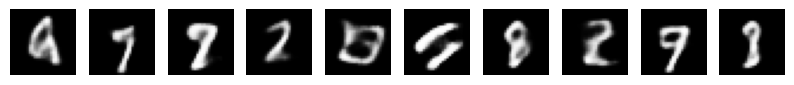

In [35]:
import matplotlib.pyplot as plt

def generate_images(model, num_samples=10, latent_dim=16, device="cuda"):
    model.eval()  
    with torch.no_grad():  
        z = torch.randn(num_samples, latent_dim).to(device)  
        generated_images = model.decoder(z)  
        generated_images = generated_images.cpu().numpy()  

    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples, 1.5))
    for i in range(num_samples):
        axes[i].imshow(generated_images[i, 0], cmap="gray")
        axes[i].axis("off")
    plt.show()

generate_images(vae, num_samples=10, latent_dim=16, device="cuda")

In [29]:
torch.save(vae.state_dict(), "vae.pth")